In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision

In [3]:
import os
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

### Скачиваем датасет

In [4]:
# !wget https://figshare.com/ndownloader/files/34792480 -O Confirmed_fronts.zip

In [5]:
# !unzip -q Confirmed_fronts.zip

### Парсим каталог с изображениями

In [6]:
!if [ -d dataset/ ]; then rm -r dataset/; fi

In [7]:
import glob
import re

map = {}
# max_len = 6095
for filename in glob.iglob('./confirmed_fronts/*/*/*[jpg]', recursive=True):
    x = re.search("([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$i([^$]+)", filename)
    if x:
        color = x.group(4).lower()
        if color not in map:
            map[color] = []

        # if len(map[color]) < max_len:
        map[color].append(filename)

print(map.keys())

dict_keys(['black', 'beige', 'red', 'blue', 'silver', 'grey', 'white', 'multicolour', 'purple', 'brown', 'green', 'unlisted', 'gold', 'yellow', 'bronze', 'orange', 'maroon', 'burgundy', 'pink', 'turquoise', 'navy', 'magenta', 'indigo'])


### Удаляем категории в которых мало изображений

In [8]:
min_len = 500

for cls in list(map.keys()):
    cls_len = len(map[cls])
    if cls_len < min_len:
        del map[cls]
        continue

# Удалил silver и grey так как они трудно-отличимы друг от друга и от black
del map['beige']
del map['silver']
del map['grey']
del map['unlisted']
print(map.keys())

dict_keys(['black', 'red', 'blue', 'white', 'brown', 'green', 'yellow', 'orange'])


### Выравниваем классы по количеству изображений

In [9]:
min_cls_len = 10e10
for cls in list(map.keys()):
    if len(map[cls]) < min_cls_len:
        min_cls_len = len(map[cls])

print(f"min_cls_len: {min_cls_len}")

for cls in list(map.keys()):
    map[cls] = map[cls][0:min_cls_len]

min_cls_len: 559


### Делим датасет на test и train и составляем список классов в labels.csv

In [10]:
import os
import shutil
import random
import numpy as np

classes = list(map.keys())
counter = 0
test_ratio = 0.05
labels = [('id', 'cls')]
test_images = []
train_images = []

for cls in classes:
    filenames = map[cls]
    num = len(filenames)
    test_size = int(num * test_ratio)
    test_files = random.sample(filenames, test_size)

    for fn in filenames:
        counter += 1
        id = f"{cls}_{counter}"
        new_fn = f"{id}.jpg"
        labels.append((id, cls))
        if fn in test_files:
            dest_path = f"./dataset/test/{new_fn}"
            test_images.append(dest_path)
        else:
            dest_path = f"./dataset/train/{new_fn}"
            train_images.append(dest_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(fn, dest_path)

np.savetxt('./dataset/labels.csv', labels, delimiter=',', fmt='%s')

In [11]:
import pandas as pd

dataset_root = './dataset'

labels = pd.read_csv(f'{dataset_root}/labels.csv')
labels.head()

id    cls
0  black_1  black
1  black_2  black
2  black_3  black
3  black_4  black
4  black_5  black

In [12]:
img_name_to_label = labels.set_index('id')['cls'].to_dict()
list(img_name_to_label.items())[:10]

[('black_1', 'black'),
 ('black_2', 'black'),
 ('black_3', 'black'),
 ('black_4', 'black'),
 ('black_5', 'black'),
 ('black_6', 'black'),
 ('black_7', 'black'),
 ('black_8', 'black'),
 ('black_9', 'black'),
 ('black_10', 'black')]

In [13]:
classes = sorted(labels['cls'].unique())
classes

['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']

./dataset/train/black_1.jpg


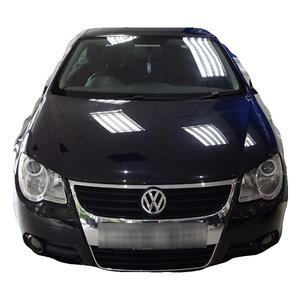

In [14]:
import cv2
from PIL import Image

print(train_images[0])
Image.open(train_images[0])

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

img_names = sorted(os.listdir(f'{dataset_root}/train'))
total_imgs = len(img_names)
targets = [img_name_to_label[img_name.replace('.jpg', '')] for img_name in img_names]
train_set_inds, test_set_inds = train_test_split(np.arange(total_imgs), test_size=0.1, random_state=42,
                                                 stratify=targets)

In [16]:
train_img_names = [img_names[ind] for ind in train_set_inds]
test_img_names = [img_names[ind] for ind in test_set_inds]

In [17]:
from torchvision import transforms as T

# ресайзим изображения до 224 (размер нашего входа)
img_sz = 224

# преобразуем в тензор и нормализуем
# стандартные значения нормализации вычисленные математически
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])
test_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])

### Инициализируем ImageDataset'ы для доступа к данным

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd


class ImageDataset(Dataset):
    def __init__(self, dataset_root, classes, img_name_to_label,
                 img_names, transform):
        self.dataset_root = dataset_root
        self.img_names = img_names
        self.img_name_to_label = img_name_to_label
        self.label_to_idx = {val: idx for idx, val in enumerate(classes)}
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img_path = f'{self.dataset_root}/{img_name}'
        label = self.img_name_to_label[img_name.replace('.jpg', '')]
        image = Image.open(img_path).convert('RGB')

        image_tensor = self.transform(image)
        image.close()
        return image_tensor, self.label_to_idx[label]

In [19]:
image_datasets = dict()
image_datasets['train'] = ImageDataset(dataset_root=f"{dataset_root}/train",
                                       classes=classes,
                                       img_name_to_label=img_name_to_label,
                                       img_names=train_img_names,
                                       transform=train_data_transforms)

image_datasets['test'] = ImageDataset(dataset_root=f"{dataset_root}/train",
                                      classes=classes,
                                      img_name_to_label=img_name_to_label,
                                      img_names=test_img_names,
                                      transform=test_data_transforms)

## Инициализируем DataLoader'ы

In [20]:
from torch.utils.data import DataLoader

batch_size = 256
num_workers = 16

dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

### Для обучения будем использовать 3 предобученные модели:
  - ResNet50
  - AlexNet
  - VGG19

(выбор пал на них, т.к. их мне лучше всего удалось дообучить)

### ResNet50

In [21]:
from torchvision import models
from torch import nn
import torch


def get_resnet(num_classes):
    net_features = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # net_features = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

    # net_features.requires_grad_(False)
    net_features.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return net_features

### AlexNet

In [22]:
from torchvision import models
from torch import nn
import torch


def get_alexnet(num_classes):
    net_features = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    # net_features.requires_grad_(False)

    dropout = 0.5

    net_features.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )
    return net_features

### VGG

In [23]:
from torchvision import models
from torch import nn
import torch


def get_vgg(num_classes):
    net_features = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    # net_features.requires_grad_(False)

    dropout = 0.5
    net_features.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, num_classes),
    )

    return net_features

### Инициализируем модели

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_models = {}
net_models['resnet'] = get_resnet(num_classes=len(classes)).to(device)
net_models['alexnet'] = get_alexnet(num_classes=len(classes)).to(device)
net_models['vgg'] = get_vgg(num_classes=len(classes)).to(device)

### Выводим полученные архитектуры нейронных сетей

In [25]:
from torchsummary import summary

for name in list(net_models.keys()):
    print(name)
    summary(net_models[name], input_size=(3, 224, 224))

resnet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-

### Обучение

In [26]:
from sklearn import metrics


def run_epoch(phase, dataloader):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0
    y_test = []
    y_pred = []
    all_elems_count = 0
    cur_tqdm = tqdm(dataloader)
    for inputs, labels in cur_tqdm:
        bz = inputs.shape[0]
        all_elems_count += bz

        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        running_loss += loss.item() * bz
        corrects_cnt = torch.sum(preds == labels.detach())
        running_corrects += corrects_cnt
        show_dict = {'Loss': f'{loss.item():.6f}',
                     'Corrects': f'{corrects_cnt.item()}/{bz}',
                     'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
        cur_tqdm.set_postfix(show_dict)

    conf_matrix = metrics.confusion_matrix(y_test, y_pred)

    print("Calculating metrics...")
    f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
    epoch_loss = running_loss / all_elems_count
    epoch_acc = running_corrects.float().item() / all_elems_count
    return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix


def test_epoch(dataloader):
    with torch.inference_mode():
        return run_epoch('test', dataloader)


def train_epoch(dataloader):
    return run_epoch('train', dataloader)

In [27]:
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

results = {}


def train_model(name, dataloaders, num_epochs=5):
    print(f"Training model with params:")
    print(f"Optim: {optimizer}")
    print(f"Criterion: {criterion}")

    phases = ['train', 'test']
    for phase in dataloaders:
        if phase not in phases:
            phases.append(phase)

    results[name] = {'train': (), 'test': ()}

    saved_epoch_losses = {phase: [] for phase in phases}
    saved_epoch_accuracies = {phase: [] for phase in phases}
    saved_epoch_f1_macros = {phase: [] for phase in phases}

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        print("=" * 100)
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            print("--- Cur phase:", phase)
            epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
                train_epoch(dataloaders[phase]) if phase == 'train' \
                    else test_epoch(dataloaders[phase])
            saved_epoch_losses[phase].append(epoch_loss)
            saved_epoch_accuracies[phase].append(epoch_acc)
            saved_epoch_f1_macros[phase].append(f1_macro)
            print(f'{phase} loss: {epoch_loss:.6f}, '
                  f'acc: {epoch_acc:.6f}, '
                  f'f05_macro: {f05_macro:.6f}, '
                  f'f1_macro: {f1_macro:.6f}')
            print("Confusion matrix:")
            print(conf_matrix)

            results[name][phase] = epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

        model.eval()
        if epoch > 1:
            plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel(criterion.__class__.__name__)
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/loss_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

            plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/acc_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

            plt.title(f'F1-macros during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_f1_macros['train'], label='Train F1')
            plt.plot(range(1, epoch + 1), saved_epoch_f1_macros['test'], label='Test F1')
            plt.xlabel('Epochs')
            plt.ylabel('F1')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/f1_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

        end_time = time.time()
        epoch_time = end_time - start_time
        print("-" * 10)
        print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

    print("*** Training Completed ***")

    return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros

### Инициализируем гиперпараметры и запускаем обучение

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.40it/s, Loss=1.533441, Corrects=172/256, Accuracy=67.188%]


Calculating metrics...
train loss: 1.886770, acc: 0.511440, f05_macro: 0.503425, f1_macro: 0.473597
Confusion matrix:
[[259  31  35   8   0  38  41  32]
 [150  94  31   7   0  58  74  44]
 [ 68  14 197  18   2  40  53  62]
 [ 61  10  81 112   0  46  36  98]
 [  1   0  17   2  78 173  17 162]
 [ 10   0  12   1   0 374  24  27]
 [ 14  12   8  12   0  63 306  24]
 [  2   1   0   1   0  13  17 413]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s, Loss=1.402232, Corrects=105/170, Accuracy=61.765%]


Calculating metrics...
test loss: 1.432311, acc: 0.624413, f05_macro: 0.618741, f1_macro: 0.590989
Confusion matrix:
[[24 17  0  1  0  0 11  0]
 [ 5 27  0  1  0  4 16  0]
 [ 7  6 10  3  2  3 17  5]
 [ 2  7  4 20  0  0  9 12]
 [ 0  1  0  0 25 22  0  5]
 [ 0  0  0  0  0 53  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]
----------
Epoch Time: 0:10
Epoch 2/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.60it/s, Loss=0.370461, Corrects=229/256, Accuracy=89.453%]


Calculating metrics...
train loss: 0.830380, acc: 0.810826, f05_macro: 0.818002, f1_macro: 0.804890
Confusion matrix:
[[419  19   4   4   0   1   2   0]
 [215 180   4  15   0   0  33   0]
 [ 68   6 310  25   7   0  22   2]
 [ 50   1  51 321   0   0   9  17]
 [  0   0  15   3 376  42   0  14]
 [  6   1   4   1  12 425   1   0]
 [  1   1   1   1   0   0 444   0]
 [  0   2   1   3  13   0   1 431]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s, Loss=0.389577, Corrects=141/170, Accuracy=82.941%]


Calculating metrics...
test loss: 0.391166, acc: 0.854460, f05_macro: 0.859395, f1_macro: 0.849237
Confusion matrix:
[[23 28  0  1  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 3  2 44  3  1  0  0  0]
 [ 0  2  7 44  0  0  0  1]
 [ 0  0  0  1 45  6  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


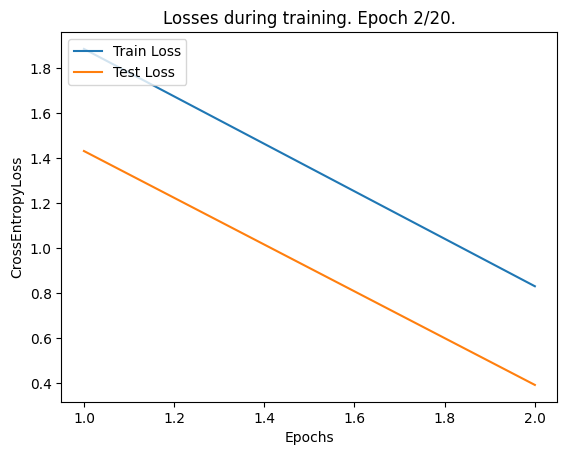

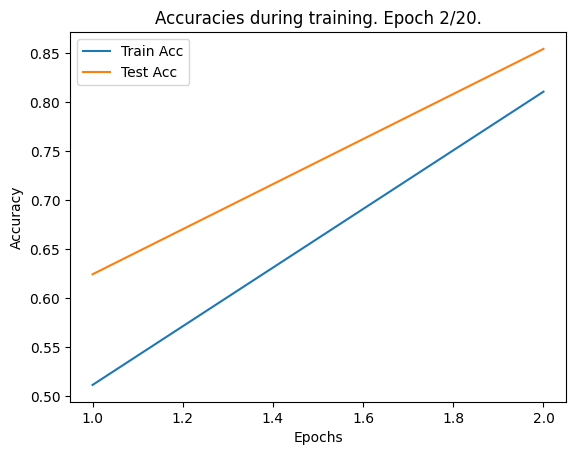

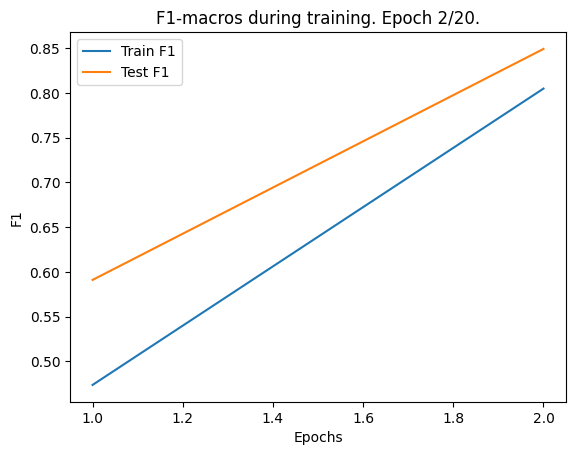

----------
Epoch Time: 0:09
Epoch 3/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.62it/s, Loss=0.161762, Corrects=243/256, Accuracy=94.922%]


Calculating metrics...
train loss: 0.238755, acc: 0.925502, f05_macro: 0.926661, f1_macro: 0.926152
Confusion matrix:
[[407  31   8   2   0   0   2   0]
 [ 41 398   5   5   0   0   3   0]
 [  9   5 418  16   3   0   2   0]
 [  3   9  33 404   0   0   0   2]
 [  0   0  15   4 411   9   0  10]
 [  0   3   7   1   5 425   0   0]
 [  0   4   3   0   0   0 437   0]
 [  0   1   1  10  14   0   1 417]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s, Loss=0.247308, Corrects=157/170, Accuracy=92.353%]


Calculating metrics...
test loss: 0.236585, acc: 0.927230, f05_macro: 0.928586, f1_macro: 0.925609
Confusion matrix:
[[37 13  1  1  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 0  0 50  3  0  0  0  0]
 [ 0  0  1 51  0  0  0  2]
 [ 0  0  0  1 49  2  0  1]
 [ 0  0  1  0  2 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


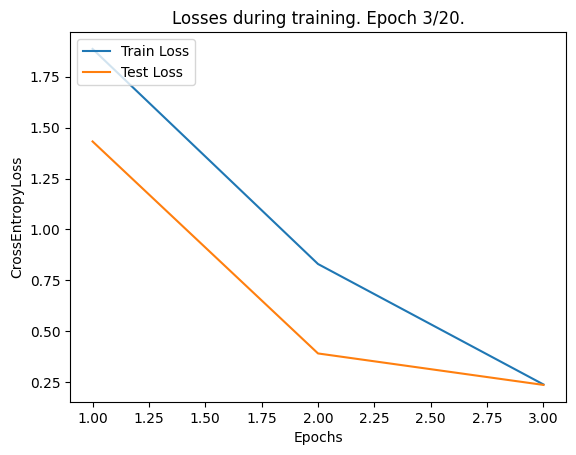

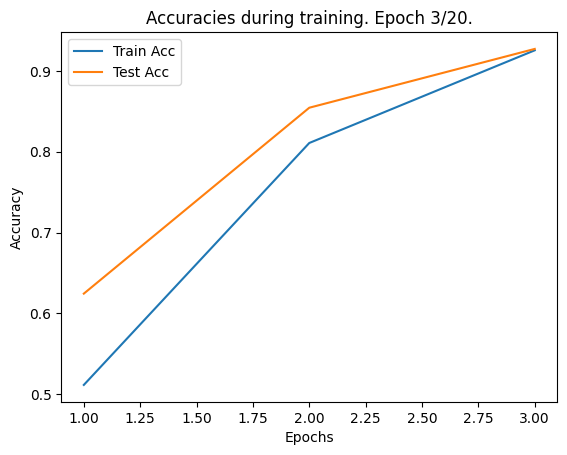

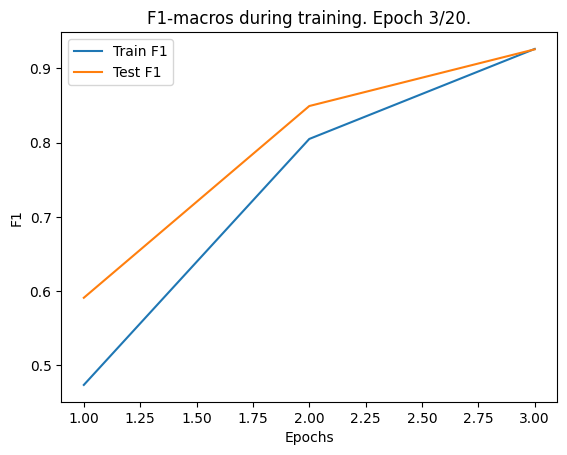

----------
Epoch Time: 0:09
Epoch 4/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=0.080228, Corrects=247/256, Accuracy=96.484%]


Calculating metrics...
train loss: 0.096728, acc: 0.967634, f05_macro: 0.967740, f1_macro: 0.967670
Confusion matrix:
[[435  11   2   0   0   1   0   0]
 [ 14 424   1   3   0   1   2   0]
 [  3   0 439   5   4   1   0   0]
 [  1   4   9 438   0   0   0   4]
 [  0   0  12   1 413   4   0  10]
 [  1   3   2   0   1 445   0   0]
 [  0   1   0   0   0   0 434   0]
 [  1   1   1   1  10   0   1 440]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s, Loss=0.191039, Corrects=158/170, Accuracy=92.941%]


Calculating metrics...
test loss: 0.172188, acc: 0.938967, f05_macro: 0.939696, f1_macro: 0.938948
Confusion matrix:
[[46  6  0  0  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 0  0 51  2  0  0  0  0]
 [ 0  0  3 50  0  0  0  1]
 [ 0  0  0  0 48  4  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  2  0  0  0  0 52  0]
 [ 0  0  1  0  0  0  0 52]]


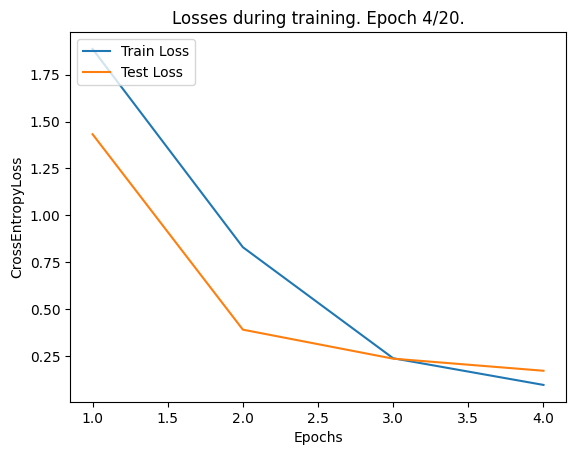

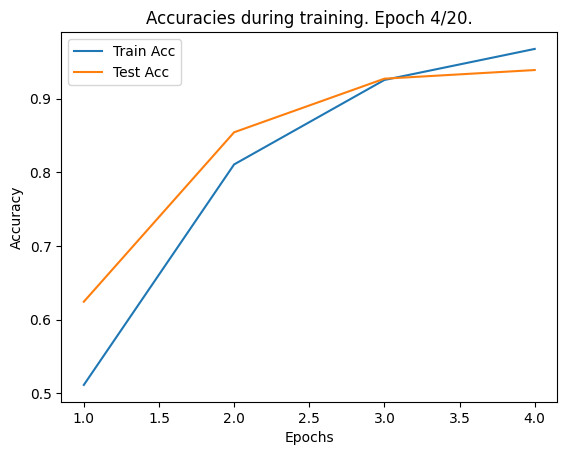

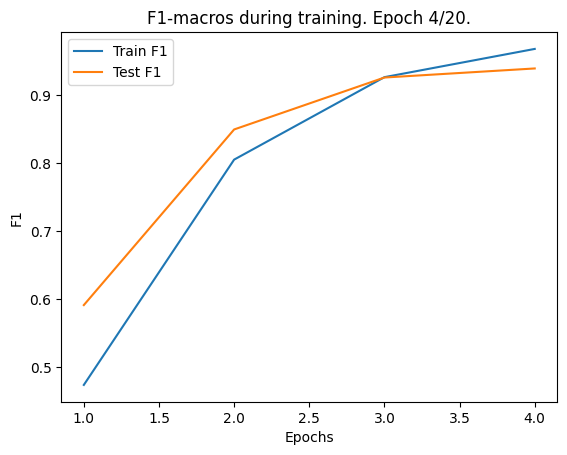

----------
Epoch Time: 0:09
Epoch 5/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.67it/s, Loss=0.047012, Corrects=253/256, Accuracy=98.828%]


Calculating metrics...
train loss: 0.038534, acc: 0.987165, f05_macro: 0.987141, f1_macro: 0.987136
Confusion matrix:
[[443   5   0   1   0   1   0   0]
 [  6 447   0   0   0   0   0   0]
 [  1   0 444   0   2   0   0   0]
 [  0   0   0 444   0   0   0   0]
 [  0   0   4   0 431   2   0   6]
 [  0   1   2   0   0 446   0   0]
 [  0   0   0   0   0   0 450   0]
 [  1   0   1   1  12   0   0 433]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s, Loss=0.200986, Corrects=159/170, Accuracy=93.529%]


Calculating metrics...
test loss: 0.181000, acc: 0.950704, f05_macro: 0.951946, f1_macro: 0.950636
Confusion matrix:
[[46  5  1  0  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  1  5 48  0  0  0  0]
 [ 0  0  0  0 51  1  0  1]
 [ 0  0  1  0  2 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


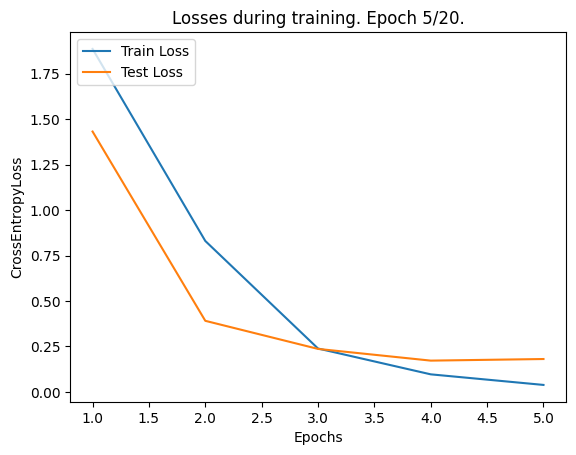

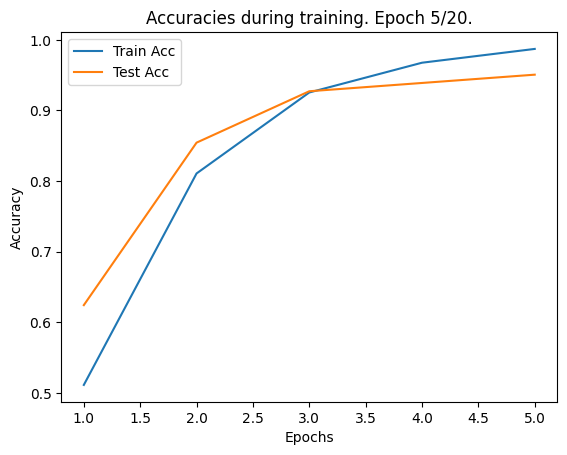

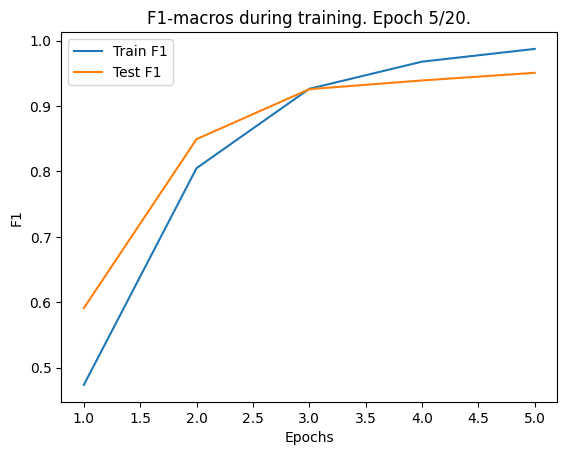

----------
Epoch Time: 0:09
Epoch 6/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.58it/s, Loss=0.014232, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.021350, acc: 0.993862, f05_macro: 0.993866, f1_macro: 0.993870
Confusion matrix:
[[442   0   1   0   0   1   0   0]
 [  0 442   0   0   0   0   1   0]
 [  1   0 446   1   1   0   0   0]
 [  0   0   0 445   0   0   0   0]
 [  0   0   2   0 441   0   0   4]
 [  0   0   1   0   0 455   0   0]
 [  0   0   1   0   0   0 445   0]
 [  1   1   0   2   4   0   0 446]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s, Loss=0.187632, Corrects=159/170, Accuracy=93.529%]


Calculating metrics...
test loss: 0.171985, acc: 0.953052, f05_macro: 0.953788, f1_macro: 0.953050
Confusion matrix:
[[49  1  1  1  0  0  1  0]
 [ 5 48  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  4 48  0  0  0  2]
 [ 0  0  0  0 51  1  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


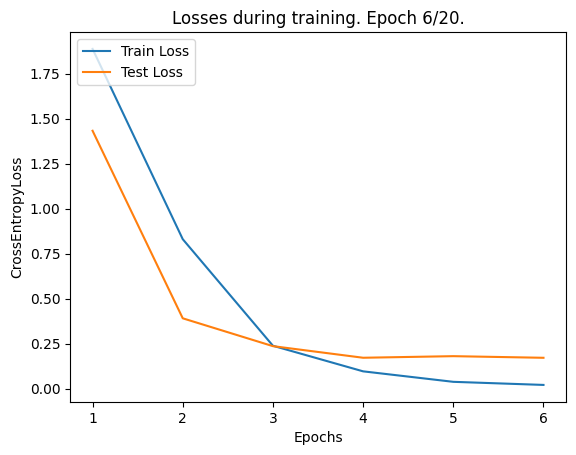

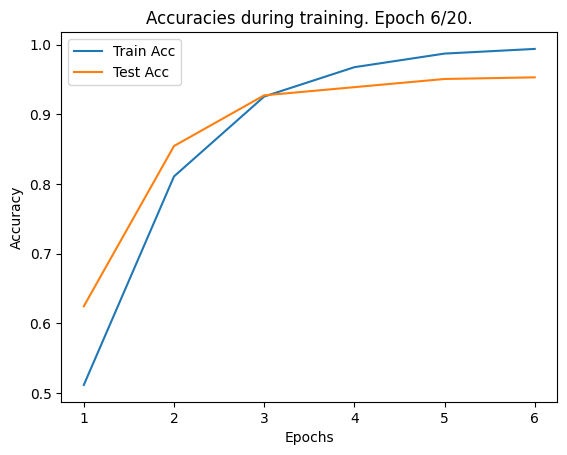

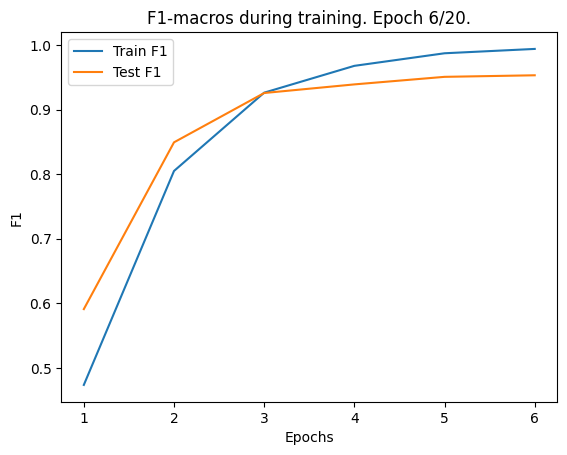

----------
Epoch Time: 0:10
Epoch 7/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.59it/s, Loss=0.004097, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.014164, acc: 0.995815, f05_macro: 0.995812, f1_macro: 0.995816
Confusion matrix:
[[434   0   0   0   0   1   0   0]
 [  1 443   0   0   0   1   0   0]
 [  0   0 449   0   2   0   0   0]
 [  0   0   0 447   0   0   0   0]
 [  0   0   1   0 445   0   0   2]
 [  0   1   1   0   0 450   0   0]
 [  0   0   0   0   0   0 453   0]
 [  1   1   0   1   2   0   0 448]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s, Loss=0.191553, Corrects=160/170, Accuracy=94.118%]


Calculating metrics...
test loss: 0.185361, acc: 0.948357, f05_macro: 0.949354, f1_macro: 0.947914
Confusion matrix:
[[44  7  1  0  0  0  1  0]
 [ 0 53  0  0  0  0  0  0]
 [ 0  0 50  3  0  0  0  0]
 [ 0  0  2 50  0  0  0  2]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


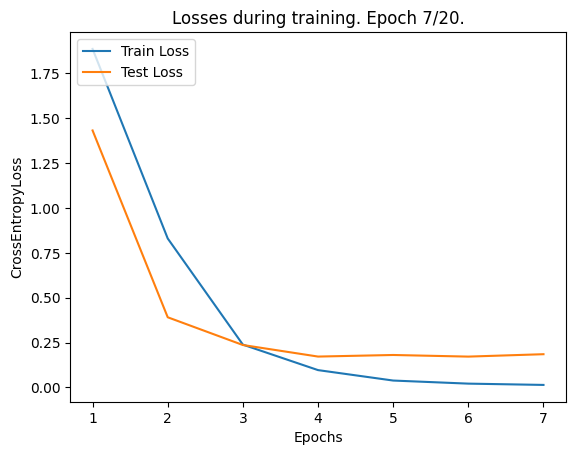

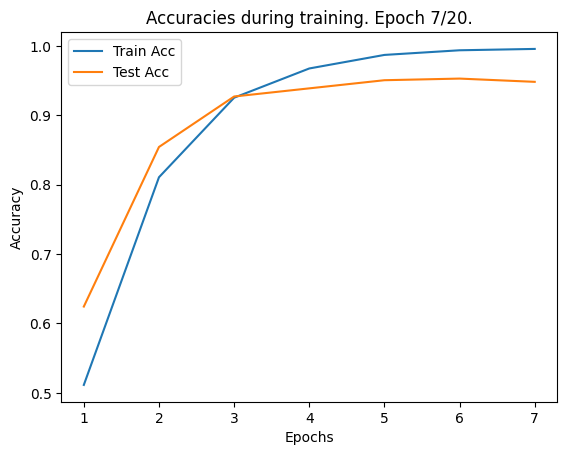

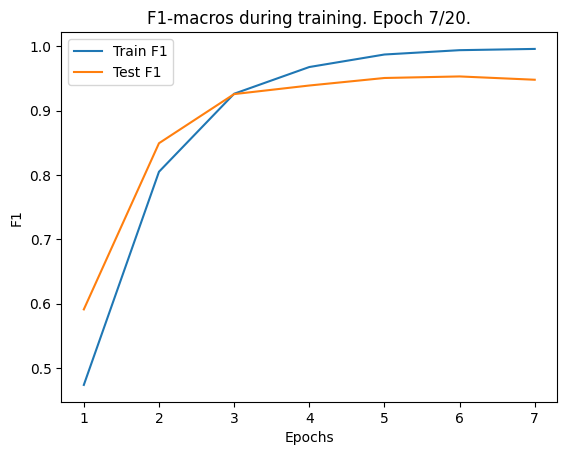

----------
Epoch Time: 0:09
Epoch 8/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s, Loss=0.002540, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.007542, acc: 0.998047, f05_macro: 0.998055, f1_macro: 0.998054
Confusion matrix:
[[449   0   0   0   0   1   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 453   1   1   0   0   0]
 [  0   0   0 442   0   0   0   0]
 [  0   0   1   0 454   0   0   0]
 [  0   0   1   0   0 450   0   0]
 [  0   0   0   0   0   0 441   0]
 [  0   0   0   2   0   0   0 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s, Loss=0.217072, Corrects=158/170, Accuracy=92.941%]


Calculating metrics...
test loss: 0.173603, acc: 0.955399, f05_macro: 0.955846, f1_macro: 0.955263
Confusion matrix:
[[48  4  0  0  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  4 48  0  0  0  2]
 [ 0  0  0  0 51  1  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


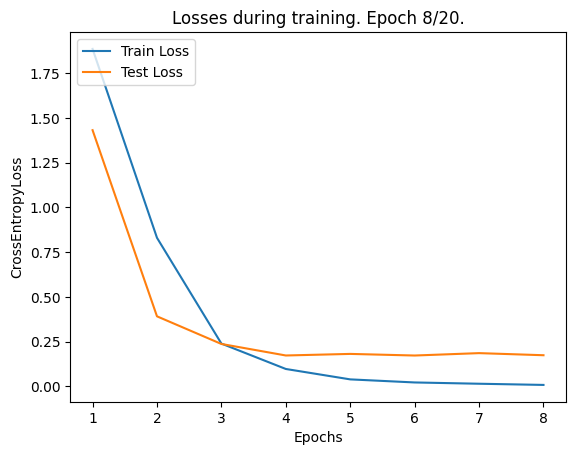

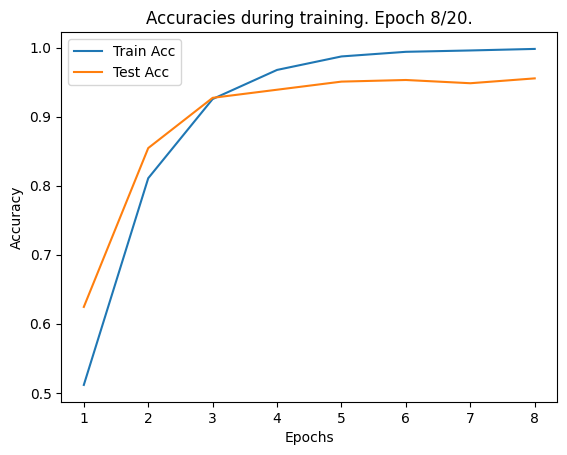

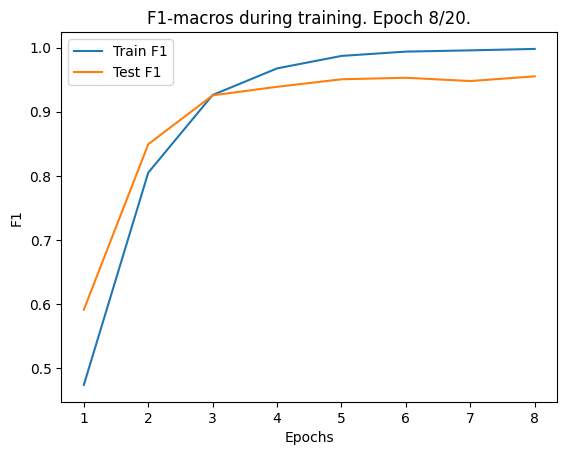

----------
Epoch Time: 0:10
Epoch 9/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, Loss=0.002077, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.005207, acc: 0.998884, f05_macro: 0.998887, f1_macro: 0.998886
Confusion matrix:
[[445   0   0   0   0   1   0   0]
 [  0 449   0   0   0   0   0   0]
 [  0   0 457   0   1   0   0   0]
 [  0   0   0 444   0   0   0   0]
 [  0   0   0   0 441   0   0   0]
 [  0   0   0   0   0 453   0   0]
 [  0   0   0   0   0   0 448   0]
 [  1   0   1   0   0   0   0 443]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s, Loss=0.199062, Corrects=161/170, Accuracy=94.706%]


Calculating metrics...
test loss: 0.174965, acc: 0.957746, f05_macro: 0.958506, f1_macro: 0.957796
Confusion matrix:
[[49  2  1  0  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  4 50  0  0  0  0]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


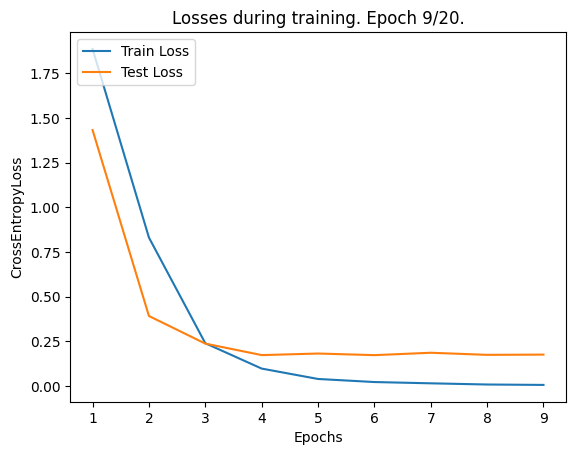

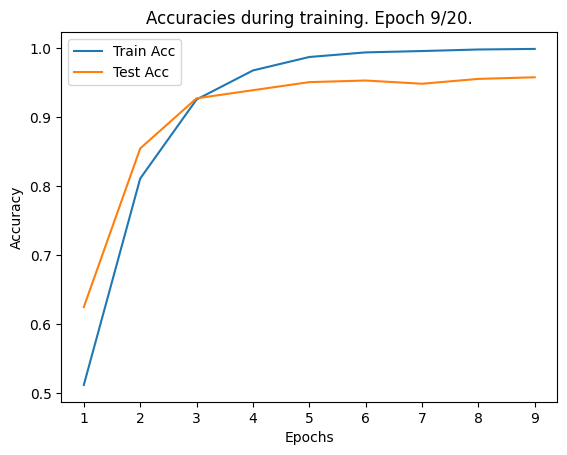

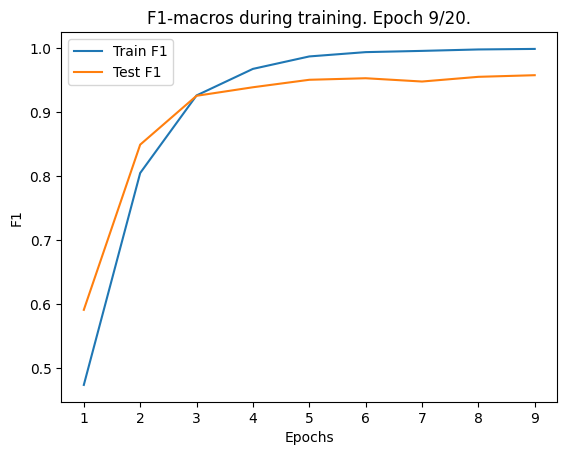

----------
Epoch Time: 0:10
Epoch 10/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s, Loss=0.001993, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.004007, acc: 0.999163, f05_macro: 0.999167, f1_macro: 0.999167
Confusion matrix:
[[450   0   0   0   0   1   0   0]
 [  0 442   0   0   0   0   0   0]
 [  0   0 452   0   1   0   0   0]
 [  0   0   0 445   0   0   0   0]
 [  0   0   0   0 448   0   0   0]
 [  0   0   0   0   0 450   0   0]
 [  0   0   0   0   0   0 447   0]
 [  1   0   0   0   0   0   0 447]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s, Loss=0.183517, Corrects=164/170, Accuracy=96.471%]


Calculating metrics...
test loss: 0.148787, acc: 0.969484, f05_macro: 0.969541, f1_macro: 0.969351
Confusion matrix:
[[49  2  0  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  1 53  0  0  0  0]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


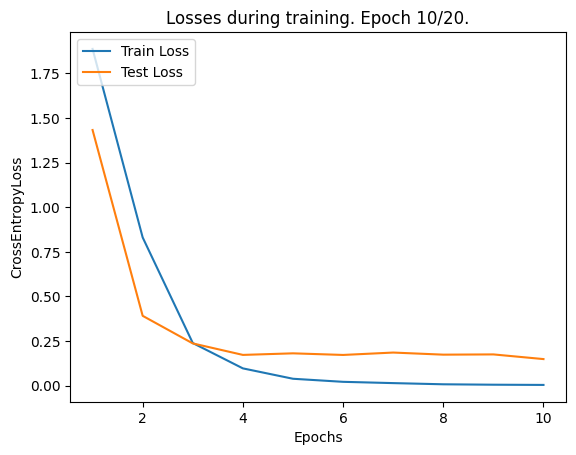

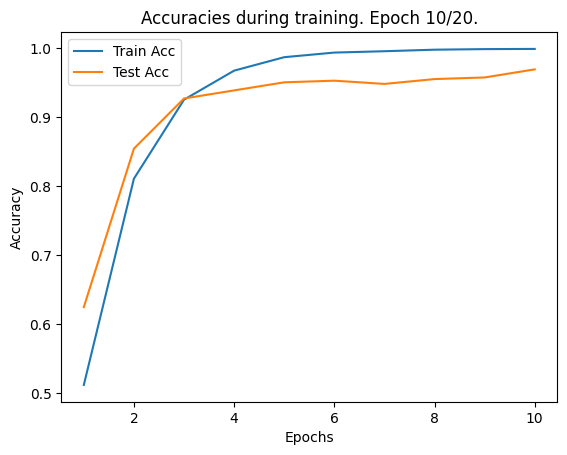

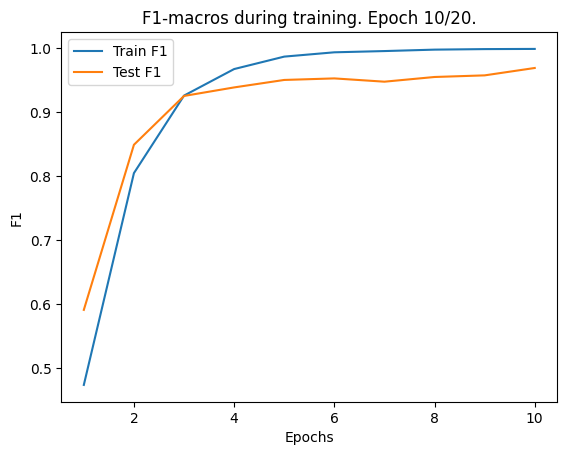

----------
Epoch Time: 0:10
Epoch 11/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.64it/s, Loss=0.007338, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.002542, acc: 0.999442, f05_macro: 0.999438, f1_macro: 0.999440
Confusion matrix:
[[451   0   0   0   0   1   0   0]
 [  0 451   0   0   0   0   0   0]
 [  0   0 448   0   1   0   0   0]
 [  0   0   0 450   0   0   0   0]
 [  0   0   0   0 439   0   0   0]
 [  0   0   0   0   0 447   0   0]
 [  0   0   0   0   0   0 449   0]
 [  0   0   0   0   0   0   0 447]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s, Loss=0.219668, Corrects=161/170, Accuracy=94.706%]


Calculating metrics...
test loss: 0.167641, acc: 0.962441, f05_macro: 0.962639, f1_macro: 0.962281
Confusion matrix:
[[47  4  1  0  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 52  0  0  0  0]
 [ 0  0  0  0 51  1  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


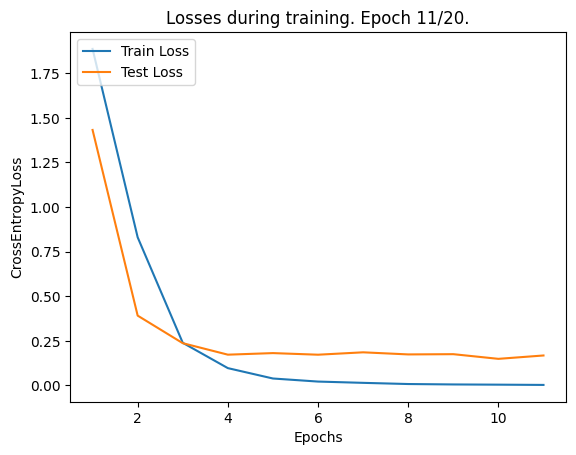

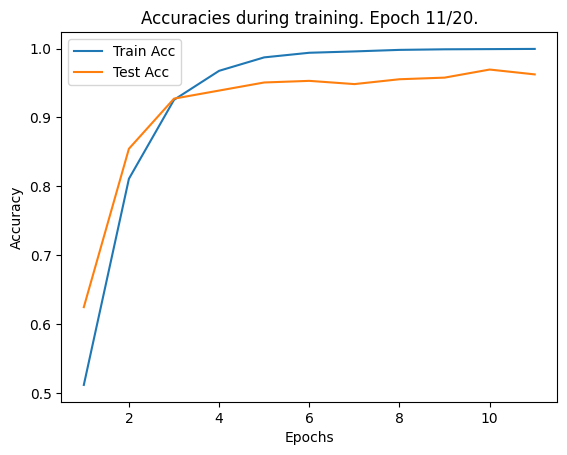

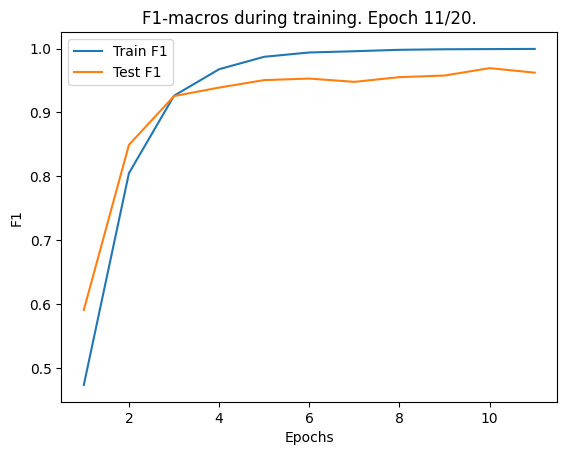

----------
Epoch Time: 0:09
Epoch 12/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.66it/s, Loss=0.000924, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.001764, acc: 0.999442, f05_macro: 0.999442, f1_macro: 0.999444
Confusion matrix:
[[448   0   0   0   0   1   0   0]
 [  0 439   0   0   0   0   0   0]
 [  0   0 456   0   1   0   0   0]
 [  0   0   0 443   0   0   0   0]
 [  0   0   0   0 446   0   0   0]
 [  0   0   0   0   0 447   0   0]
 [  0   0   0   0   0   0 447   0]
 [  0   0   0   0   0   0   0 456]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s, Loss=0.237577, Corrects=160/170, Accuracy=94.118%]


Calculating metrics...
test loss: 0.175644, acc: 0.957746, f05_macro: 0.958121, f1_macro: 0.957622
Confusion matrix:
[[47  4  1  0  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  3 51  0  0  0  0]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


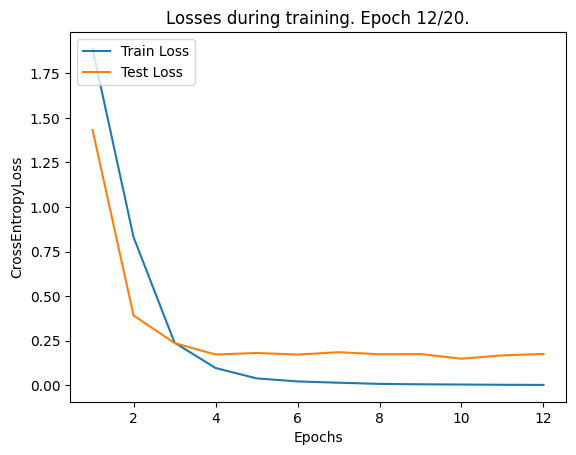

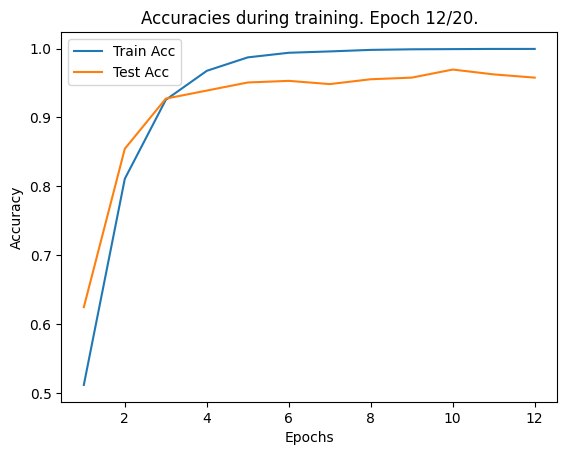

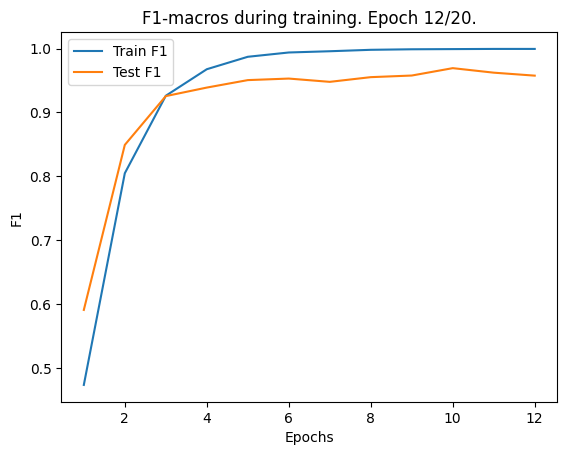

----------
Epoch Time: 0:09
Epoch 13/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, Loss=0.001614, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.002028, acc: 0.999442, f05_macro: 0.999444, f1_macro: 0.999442
Confusion matrix:
[[448   0   0   0   0   1   0   0]
 [  0 445   0   0   0   0   0   0]
 [  0   0 447   0   0   0   0   0]
 [  0   0   0 449   0   0   0   0]
 [  0   0   0   0 449   0   0   0]
 [  0   0   0   0   0 452   0   0]
 [  0   0   0   0   0   0 452   0]
 [  0   0   0   1   0   0   0 440]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.19it/s, Loss=0.234011, Corrects=160/170, Accuracy=94.118%]


Calculating metrics...
test loss: 0.171722, acc: 0.960094, f05_macro: 0.960617, f1_macro: 0.959973
Confusion matrix:
[[47  4  1  0  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  3 51  0  0  0  0]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


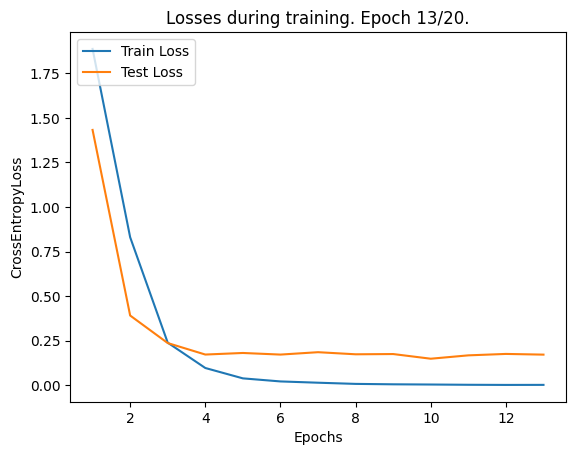

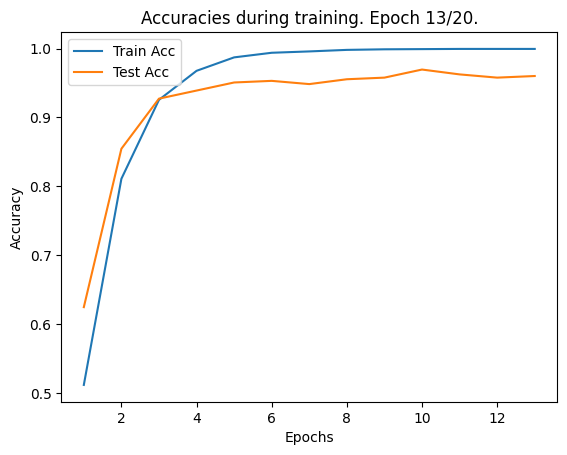

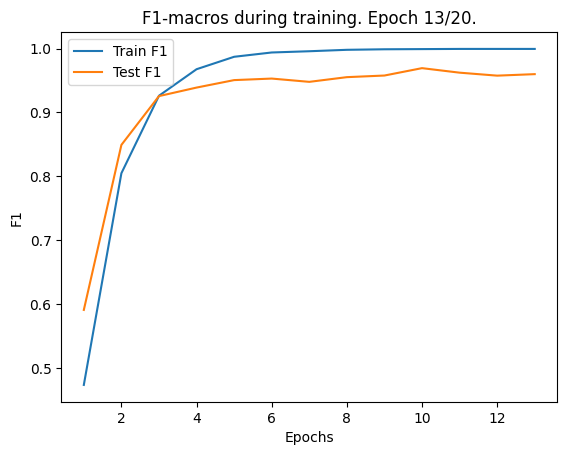

----------
Epoch Time: 0:10
Epoch 14/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.60it/s, Loss=0.001505, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.001433, acc: 1.000000, f05_macro: 1.000000, f1_macro: 1.000000
Confusion matrix:
[[444   0   0   0   0   0   0   0]
 [  0 452   0   0   0   0   0   0]
 [  0   0 451   0   0   0   0   0]
 [  0   0   0 449   0   0   0   0]
 [  0   0   0   0 442   0   0   0]
 [  0   0   0   0   0 444   0   0]
 [  0   0   0   0   0   0 447   0]
 [  0   0   0   0   0   0   0 455]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s, Loss=0.195621, Corrects=163/170, Accuracy=95.882%]


Calculating metrics...
test loss: 0.152197, acc: 0.969484, f05_macro: 0.969710, f1_macro: 0.969318
Confusion matrix:
[[48  4  0  0  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 52  0  0  0  0]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  0  0  0 53  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


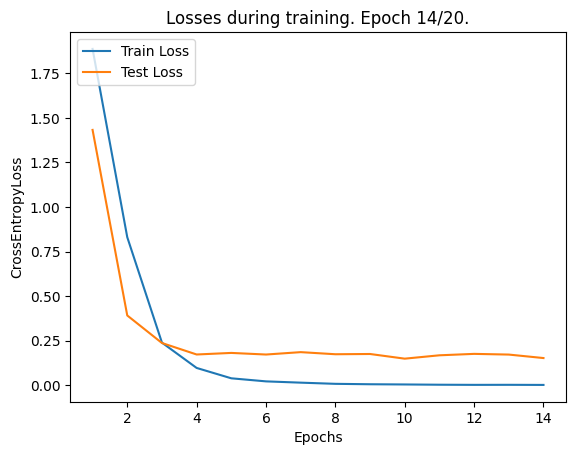

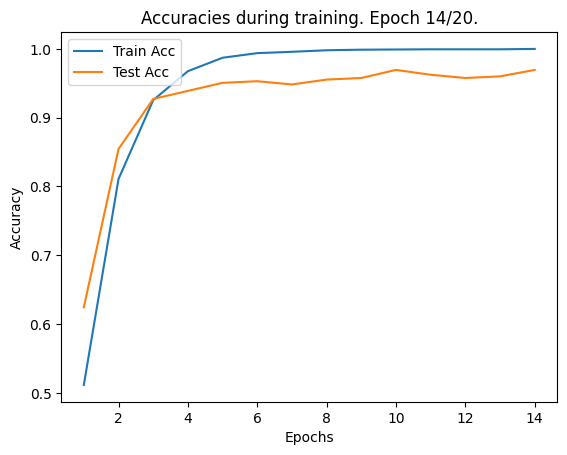

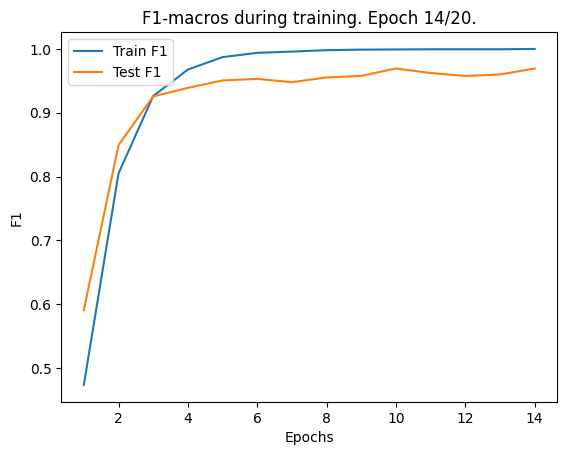

----------
Epoch Time: 0:09
Epoch 15/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s, Loss=0.002635, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.001714, acc: 0.999721, f05_macro: 0.999720, f1_macro: 0.999719
Confusion matrix:
[[444   0   0   0   0   1   0   0]
 [  0 453   0   0   0   0   0   0]
 [  0   0 456   0   0   0   0   0]
 [  0   0   0 443   0   0   0   0]
 [  0   0   0   0 442   0   0   0]
 [  0   0   0   0   0 446   0   0]
 [  0   0   0   0   0   0 451   0]
 [  0   0   0   0   0   0   0 448]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.21it/s, Loss=0.211428, Corrects=161/170, Accuracy=94.706%]


Calculating metrics...
test loss: 0.162696, acc: 0.964789, f05_macro: 0.965123, f1_macro: 0.964738
Confusion matrix:
[[49  3  0  0  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  3 50  0  0  0  1]
 [ 0  0  0  0 51  1  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


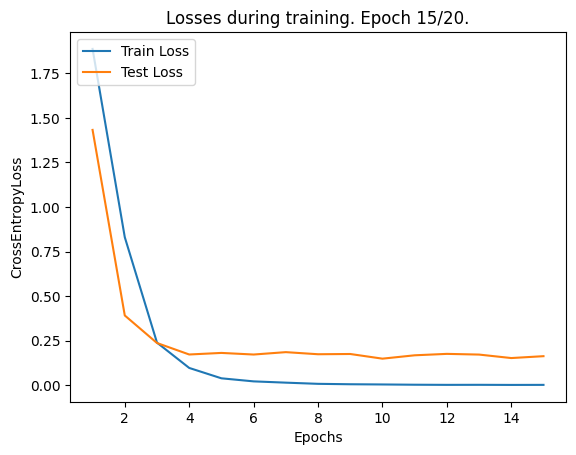

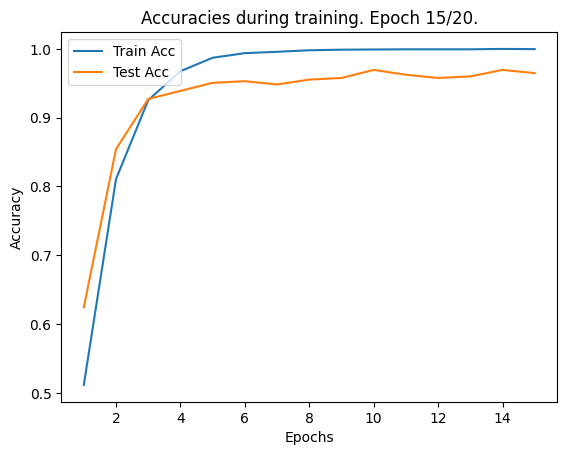

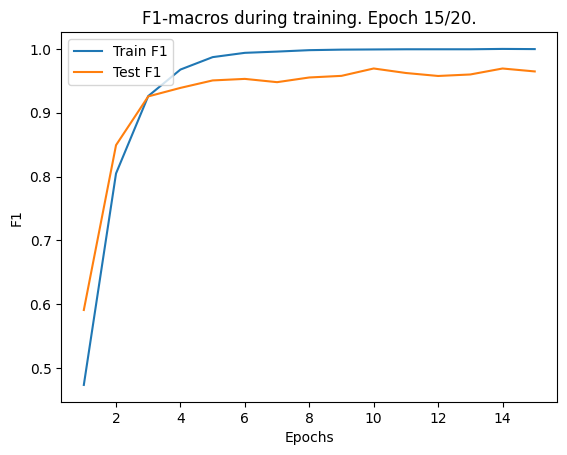

----------
Epoch Time: 0:10
Epoch 16/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.54it/s, Loss=0.001014, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.001292, acc: 0.999721, f05_macro: 0.999720, f1_macro: 0.999719
Confusion matrix:
[[441   0   0   0   0   0   0   0]
 [  0 457   0   0   0   0   0   0]
 [  0   0 443   0   1   0   0   0]
 [  0   0   0 455   0   0   0   0]
 [  0   0   0   0 447   0   0   0]
 [  0   0   0   0   0 455   0   0]
 [  0   0   0   0   0   0 446   0]
 [  0   0   0   0   0   0   0 439]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s, Loss=0.201774, Corrects=163/170, Accuracy=95.882%]


Calculating metrics...
test loss: 0.164105, acc: 0.967136, f05_macro: 0.967298, f1_macro: 0.967057
Confusion matrix:
[[49  2  0  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 52  0  0  0  0]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


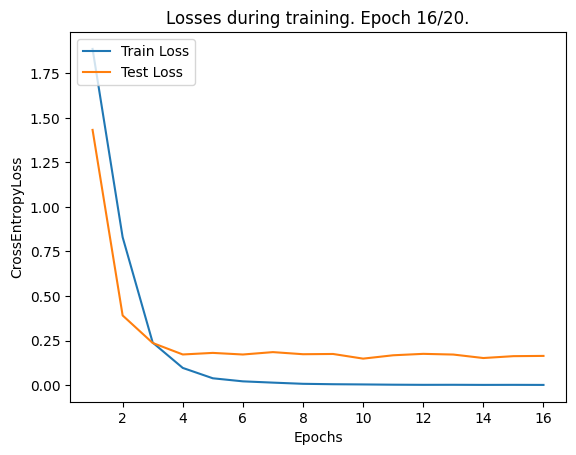

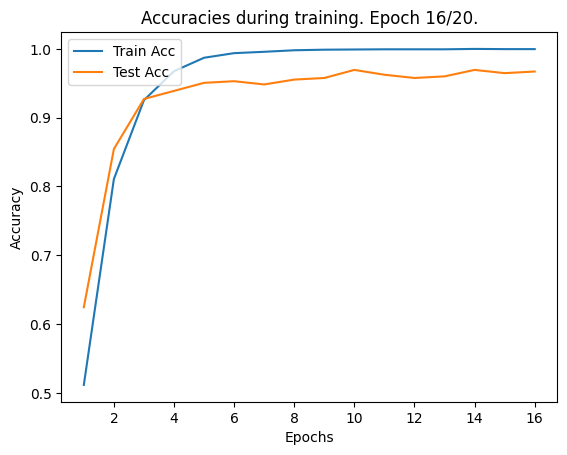

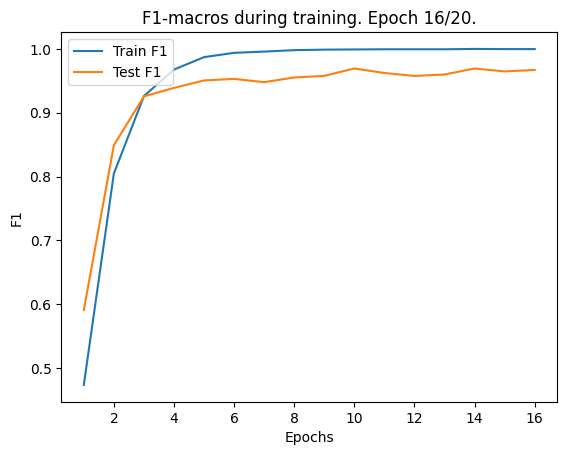

----------
Epoch Time: 0:10
Epoch 17/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, Loss=0.000384, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.000665, acc: 1.000000, f05_macro: 1.000000, f1_macro: 1.000000
Confusion matrix:
[[455   0   0   0   0   0   0   0]
 [  0 456   0   0   0   0   0   0]
 [  0   0 449   0   0   0   0   0]
 [  0   0   0 440   0   0   0   0]
 [  0   0   0   0 436   0   0   0]
 [  0   0   0   0   0 454   0   0]
 [  0   0   0   0   0   0 450   0]
 [  0   0   0   0   0   0   0 444]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s, Loss=0.205261, Corrects=163/170, Accuracy=95.882%]


Calculating metrics...
test loss: 0.170066, acc: 0.964789, f05_macro: 0.964934, f1_macro: 0.964700
Confusion matrix:
[[49  2  0  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 51  0  0  0  1]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


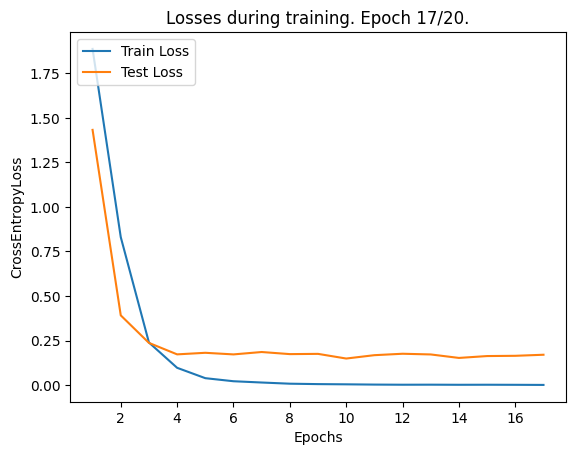

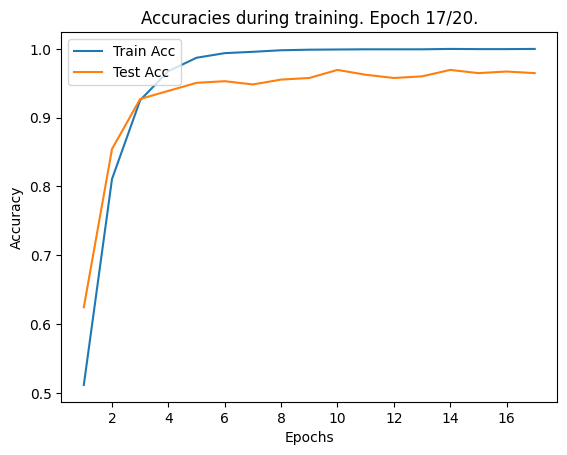

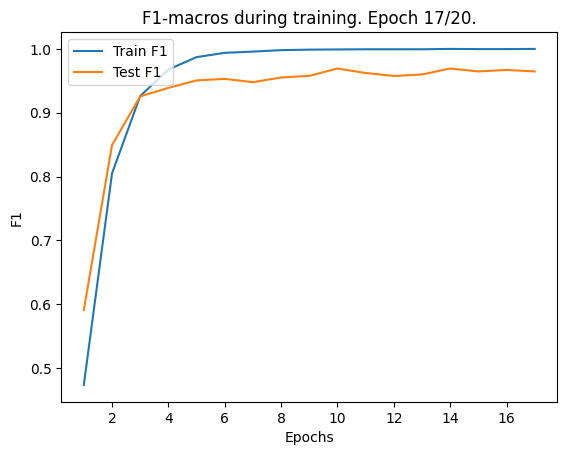

----------
Epoch Time: 0:10
Epoch 18/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s, Loss=0.000209, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.000832, acc: 1.000000, f05_macro: 1.000000, f1_macro: 1.000000
Confusion matrix:
[[449   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 444   0   0   0   0   0]
 [  0   0   0 450   0   0   0   0]
 [  0   0   0   0 456   0   0   0]
 [  0   0   0   0   0 459   0   0]
 [  0   0   0   0   0   0 443   0]
 [  0   0   0   0   0   0   0 436]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s, Loss=0.214577, Corrects=163/170, Accuracy=95.882%]


Calculating metrics...
test loss: 0.178594, acc: 0.962441, f05_macro: 0.962557, f1_macro: 0.962342
Confusion matrix:
[[49  2  0  1  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 51  0  0  0  1]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


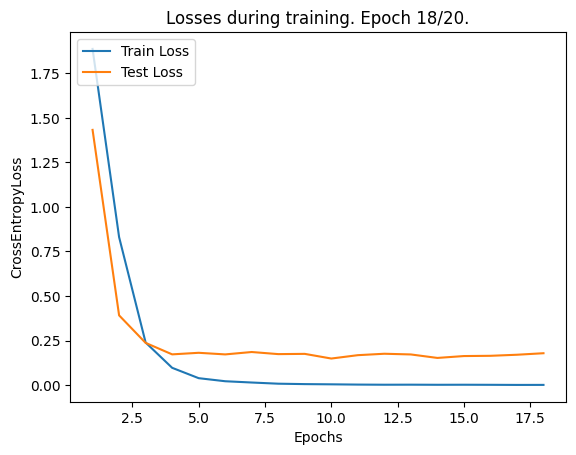

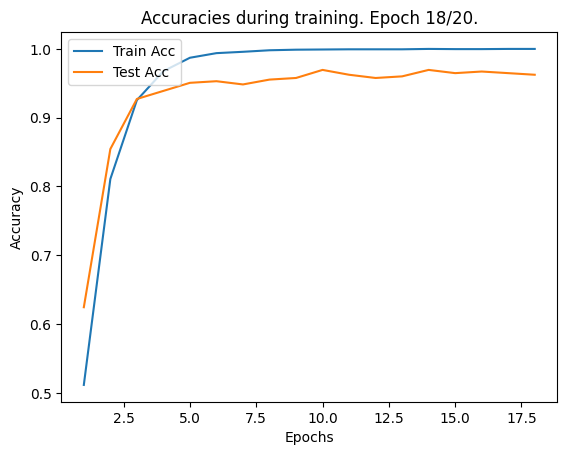

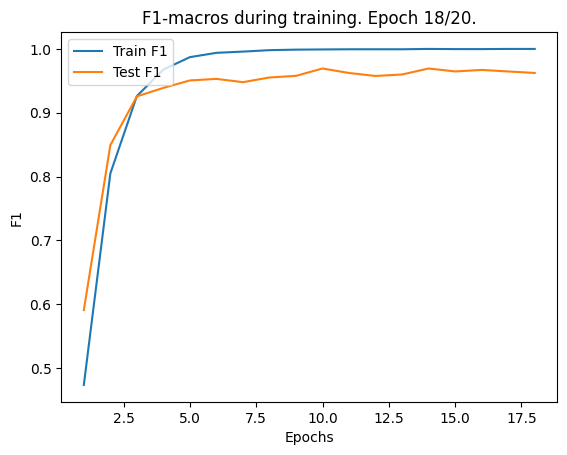

----------
Epoch Time: 0:10
Epoch 19/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.56it/s, Loss=0.000181, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.000432, acc: 1.000000, f05_macro: 1.000000, f1_macro: 1.000000
Confusion matrix:
[[447   0   0   0   0   0   0   0]
 [  0 445   0   0   0   0   0   0]
 [  0   0 448   0   0   0   0   0]
 [  0   0   0 453   0   0   0   0]
 [  0   0   0   0 438   0   0   0]
 [  0   0   0   0   0 453   0   0]
 [  0   0   0   0   0   0 451   0]
 [  0   0   0   0   0   0   0 449]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s, Loss=0.217133, Corrects=163/170, Accuracy=95.882%]


Calculating metrics...
test loss: 0.181288, acc: 0.964789, f05_macro: 0.964934, f1_macro: 0.964700
Confusion matrix:
[[49  2  0  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 51  0  0  0  1]
 [ 0  0  0  0 50  2  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


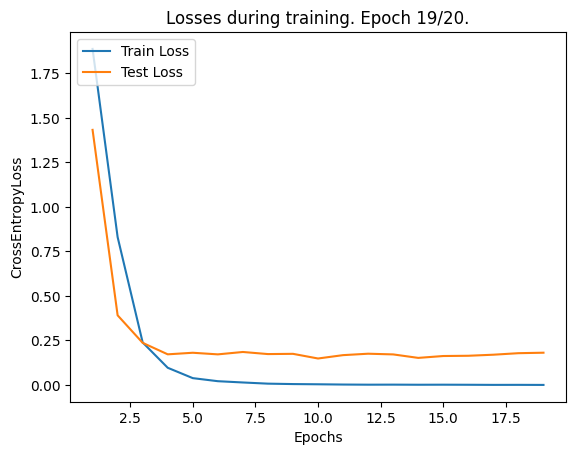

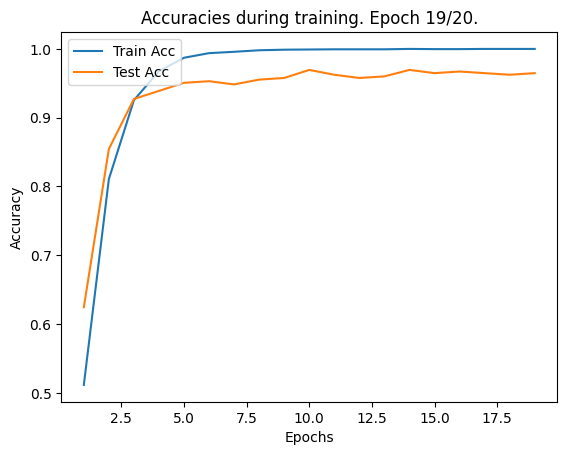

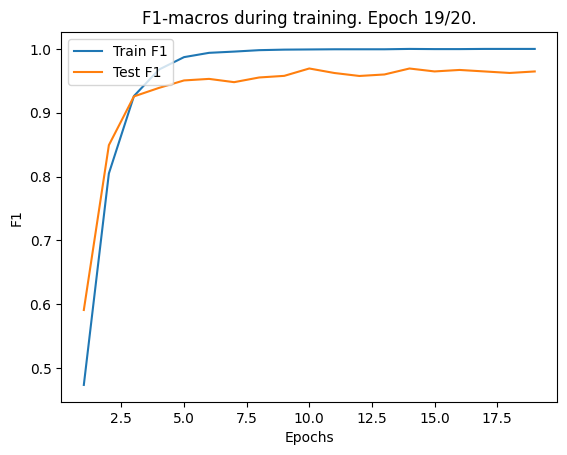

----------
Epoch Time: 0:10
Epoch 20/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.55it/s, Loss=0.000167, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.000392, acc: 1.000000, f05_macro: 1.000000, f1_macro: 1.000000
Confusion matrix:
[[450   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 438   0   0   0   0   0]
 [  0   0   0 455   0   0   0   0]
 [  0   0   0   0 453   0   0   0]
 [  0   0   0   0   0 446   0   0]
 [  0   0   0   0   0   0 449   0]
 [  0   0   0   0   0   0   0 446]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.23it/s, Loss=0.214854, Corrects=163/170, Accuracy=95.882%]


Calculating metrics...
test loss: 0.179982, acc: 0.962441, f05_macro: 0.962638, f1_macro: 0.962313
Confusion matrix:
[[49  2  0  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 51  0  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


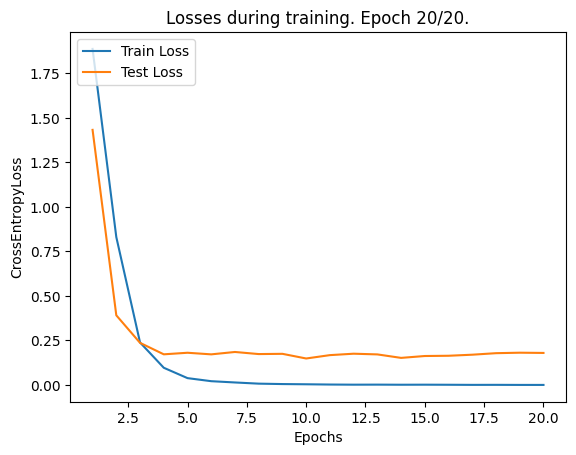

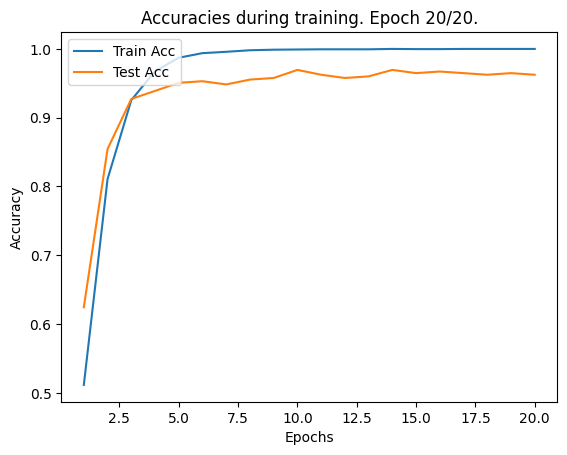

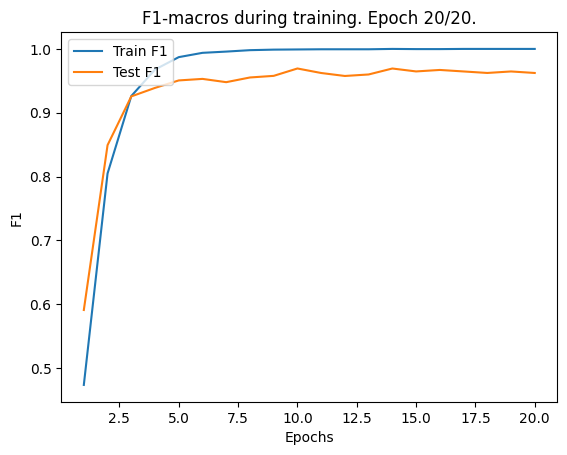

----------
Epoch Time: 0:10
*** Training Completed ***
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.61it/s, Loss=0.742456, Corrects=188/256, Accuracy=73.438%]


Calculating metrics...
train loss: 1.268866, acc: 0.550781, f05_macro: 0.545148, f1_macro: 0.543921
Confusion matrix:
[[210  88  51  25   5  17  40   9]
 [145 155  25  51   6  14  50   3]
 [ 87  40 132  92  15  17  55  15]
 [ 57  36  46 203  14  12  32  42]
 [ 28   5   7  20 243 109   3  35]
 [ 19  12   2   7  64 339   5   8]
 [ 33  28   4  25  11   2 337   3]
 [ 11  11   2  29  29   6   3 355]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s, Loss=0.563077, Corrects=134/170, Accuracy=78.824%]


Calculating metrics...
test loss: 0.618454, acc: 0.769953, f05_macro: 0.779280, f1_macro: 0.759749
Confusion matrix:
[[23 27  2  0  0  0  1  0]
 [ 7 45  1  0  0  0  0  0]
 [ 4  1 48  0  0  0  0  0]
 [ 0  8 25 20  0  0  0  1]
 [ 0  0  1  0 38 13  0  1]
 [ 0  1  0  0  3 49  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]
----------
Epoch Time: 0:03
Epoch 2/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.72it/s, Loss=0.503316, Corrects=215/256, Accuracy=83.984%]


Calculating metrics...
train loss: 0.510029, acc: 0.825893, f05_macro: 0.827027, f1_macro: 0.826211
Confusion matrix:
[[331  70  30  14   1   1   3   0]
 [ 97 314  10  12   0   0  10   0]
 [ 28  28 333  47   4   0   9   1]
 [ 22  24  66 323   1   0   5   6]
 [  0   0  12   5 386  20   0  20]
 [  2   3   9   0  20 409   0   0]
 [  1   8   4   0   0   0 446   0]
 [  1   0   5   7  18   0   0 418]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s, Loss=0.398195, Corrects=142/170, Accuracy=83.529%]

Calculating metrics...
test loss: 0.431173, acc: 0.847418, f05_macro: 0.847852, f1_macro: 0.846489
Confusion matrix:
[[38 13  0  1  0  0  1  0]
 [10 43  0  0  0  0  0  0]
 [ 4  1 37  9  0  1  1  0]
 [ 2  1  6 43  0  0  1  1]
 [ 0  0  0  1 44  7  0  1]
 [ 1  0  1  0  2 49  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


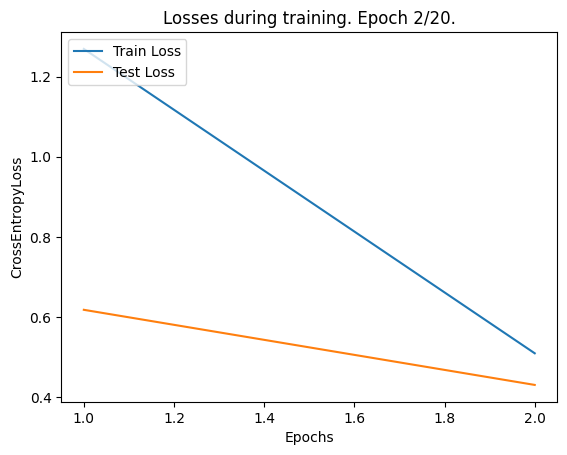

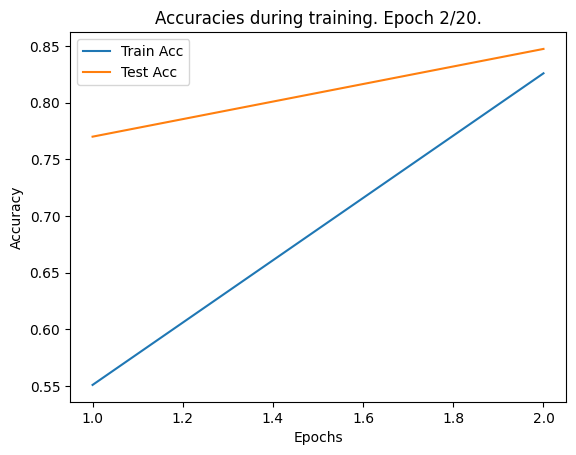

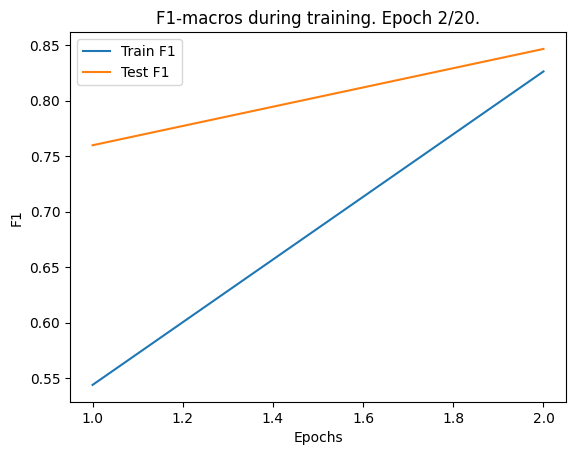

----------
Epoch Time: 0:03
Epoch 3/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.69it/s, Loss=0.280270, Corrects=231/256, Accuracy=90.234%]


Calculating metrics...
train loss: 0.342652, acc: 0.873326, f05_macro: 0.874575, f1_macro: 0.873934
Confusion matrix:
[[368  55  21   4   0   1   1   0]
 [ 72 350  10   9   1   0   4   0]
 [ 27  12 371  35   2   1   5   2]
 [ 10  14  51 357   0   0   6   4]
 [  2   1  17   1 401  17   0  16]
 [  3   1   4   1  15 427   0   0]
 [  0   2   4   1   0   0 437   0]
 [  0   1   1   3  17   0   0 419]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.99it/s, Loss=0.311952, Corrects=152/170, Accuracy=89.412%]

Calculating metrics...
test loss: 0.380480, acc: 0.877934, f05_macro: 0.880439, f1_macro: 0.878206
Confusion matrix:
[[40 12  0  0  0  0  1  0]
 [ 6 47  0  0  0  0  0  0]
 [ 3  4 41  4  0  1  0  0]
 [ 3  2  5 43  1  0  0  0]
 [ 0  0  0  0 47  5  0  1]
 [ 1  0  1  0  1 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


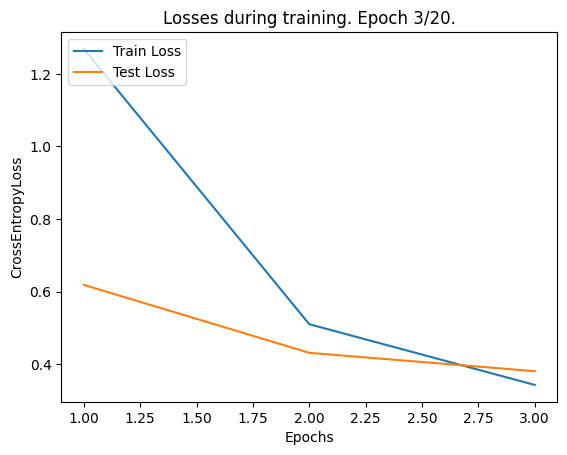

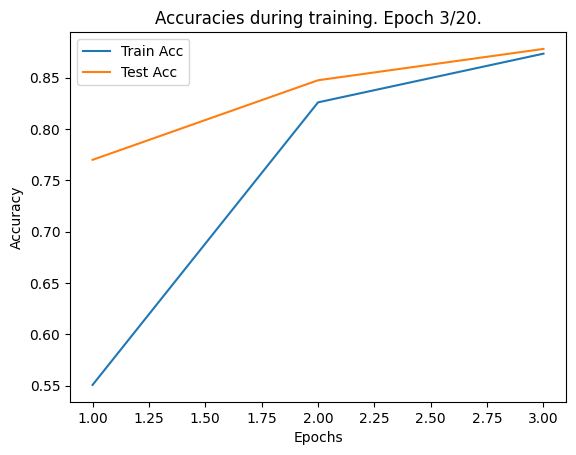

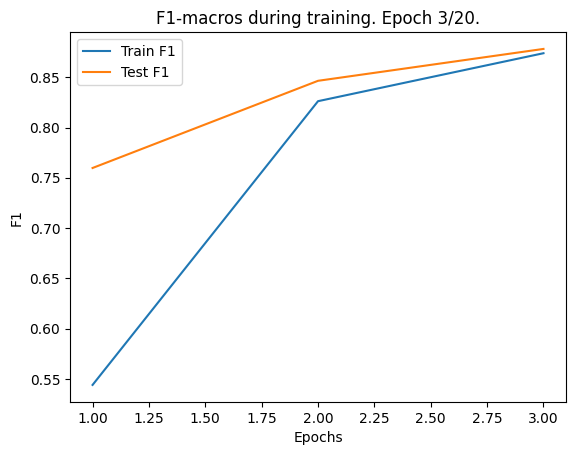

----------
Epoch Time: 0:03
Epoch 4/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.79it/s, Loss=0.231398, Corrects=233/256, Accuracy=91.016%]


Calculating metrics...
train loss: 0.236209, acc: 0.913783, f05_macro: 0.914361, f1_macro: 0.914070
Confusion matrix:
[[395  35  15   2   1   1   0   0]
 [ 43 390   4   7   0   1   1   0]
 [ 25   5 388  26   3   1   5   1]
 [  7  10  30 390   1   0   1   3]
 [  1   0  11   1 410  14   0   9]
 [  2   2   3   1   8 430   0   0]
 [  1   5   1   1   0   0 442   0]
 [  0   2   2   5  12   0   0 430]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s, Loss=0.332282, Corrects=153/170, Accuracy=90.000%]

Calculating metrics...
test loss: 0.388761, acc: 0.868545, f05_macro: 0.869183, f1_macro: 0.864688
Confusion matrix:
[[29 11  7  5  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 0  0 46  5  0  1  1  0]
 [ 0  1  5 46  1  0  1  0]
 [ 0  0  0  0 46  6  0  1]
 [ 0  0  2  0  1 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  3  0  0  0 49]]


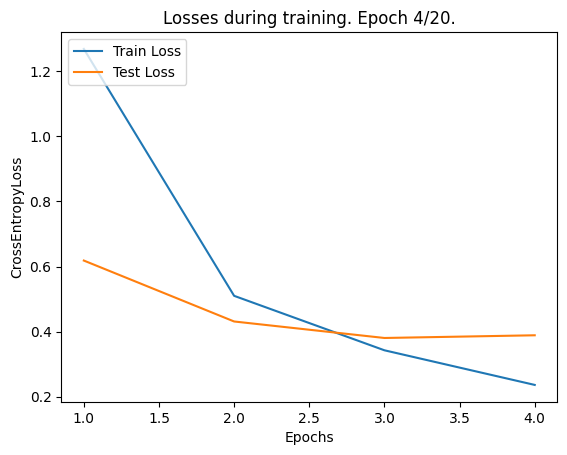

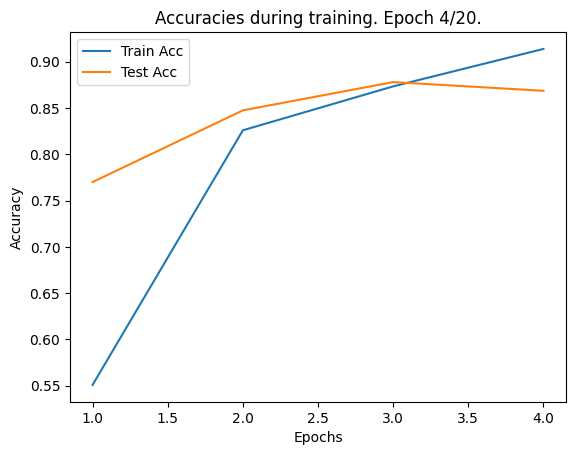

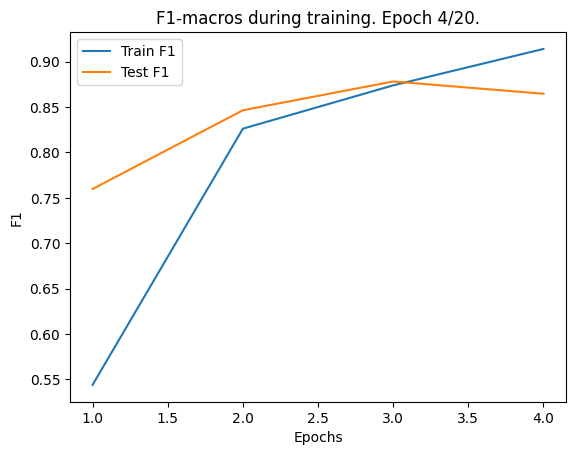

----------
Epoch Time: 0:03
Epoch 5/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.76it/s, Loss=0.164795, Corrects=245/256, Accuracy=95.703%]


Calculating metrics...
train loss: 0.194418, acc: 0.936942, f05_macro: 0.937383, f1_macro: 0.937171
Confusion matrix:
[[411  22  12   5   0   0   1   0]
 [ 37 402   2   6   0   1   2   0]
 [ 19   2 405  15   4   0   1   3]
 [  7   8  14 411   0   0   0   1]
 [  0   0   7   0 429   4   0  12]
 [  0   1   1   2   5 437   0   0]
 [  0   1   4   0   0   0 442   0]
 [  1   2   1   7  15   0   1 421]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s, Loss=0.263966, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.325523, acc: 0.901408, f05_macro: 0.901085, f1_macro: 0.900064
Confusion matrix:
[[39 10  2  1  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  1 46  4  0  0  1  0]
 [ 1  1  4 44  1  0  2  1]
 [ 0  0  0  0 48  4  0  1]
 [ 1  0  0  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


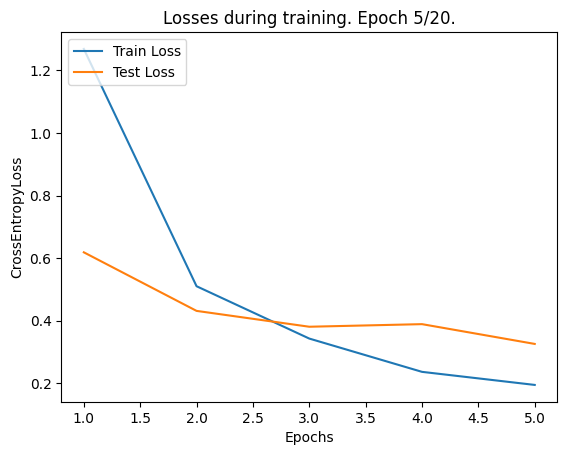

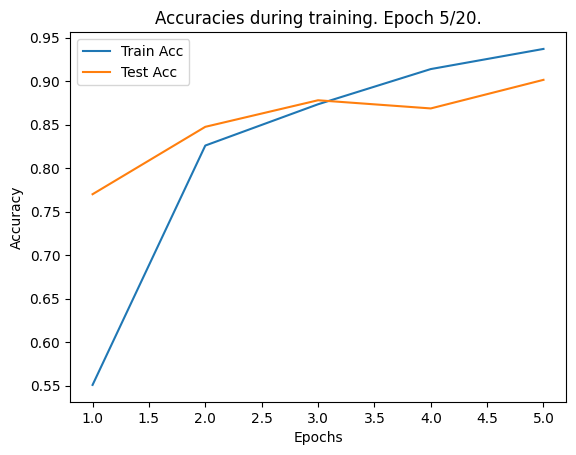

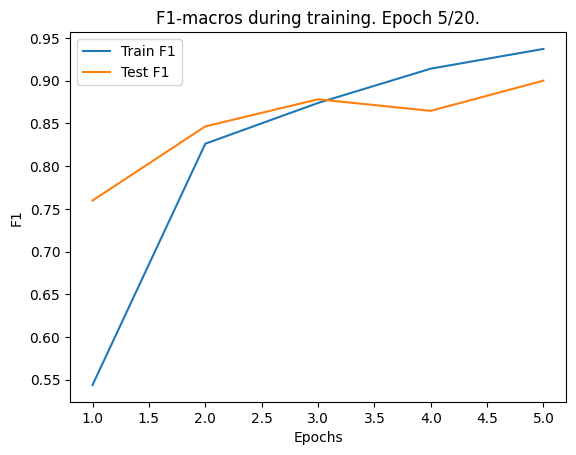

----------
Epoch Time: 0:03
Epoch 6/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.72it/s, Loss=0.091662, Corrects=249/256, Accuracy=97.266%]


Calculating metrics...
train loss: 0.109995, acc: 0.963170, f05_macro: 0.963155, f1_macro: 0.963075
Confusion matrix:
[[420  20   3   1   0   0   1   0]
 [ 20 411   1   5   0   0   2   0]
 [ 11   3 432   8   0   0   0   0]
 [  2   3  13 420   2   0   1   3]
 [  0   0   5   0 433   4   0   3]
 [  1   1   3   1   2 440   0   0]
 [  0   0   2   0   0   0 455   0]
 [  0   0   2   1   7   0   1 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s, Loss=0.288594, Corrects=159/170, Accuracy=93.529%]

Calculating metrics...
test loss: 0.340187, acc: 0.915493, f05_macro: 0.916583, f1_macro: 0.914966
Confusion matrix:
[[44  5  2  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 1  0 50  1  0  0  1  0]
 [ 1  1  5 45  0  0  1  1]
 [ 0  0  0  0 45  7  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


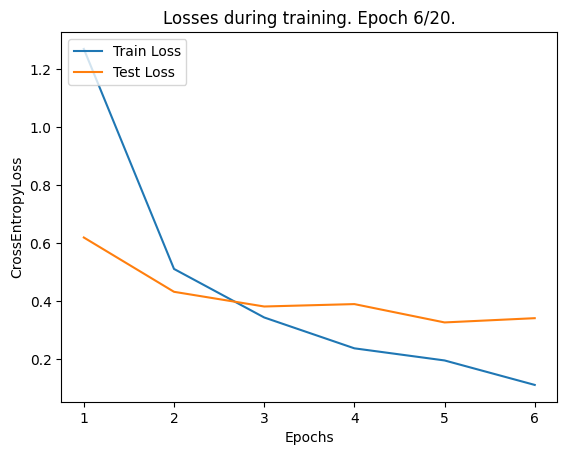

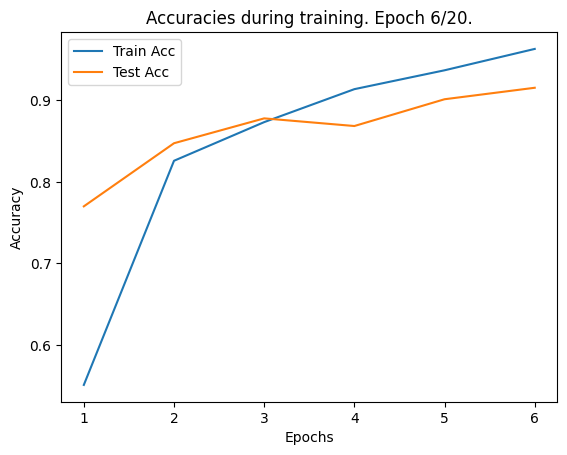

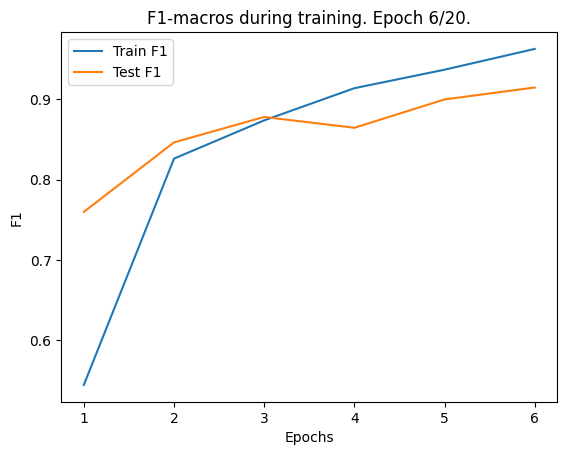

----------
Epoch Time: 0:03
Epoch 7/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.73it/s, Loss=0.058564, Corrects=250/256, Accuracy=97.656%]


Calculating metrics...
train loss: 0.082226, acc: 0.973493, f05_macro: 0.973585, f1_macro: 0.973534
Confusion matrix:
[[438  10   5   1   0   0   1   0]
 [ 19 424   1   1   0   0   3   0]
 [  5   1 438   6   2   0   2   0]
 [  0   2   3 450   1   0   0   0]
 [  0   0   3   0 425   6   0   6]
 [  0   1   1   1   3 432   0   0]
 [  0   2   0   0   0   0 452   0]
 [  0   0   2   3   4   0   0 430]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s, Loss=0.276743, Corrects=159/170, Accuracy=93.529%]

Calculating metrics...
test loss: 0.342756, acc: 0.910798, f05_macro: 0.912223, f1_macro: 0.910065
Confusion matrix:
[[42  7  2  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 1  1 48  2  0  0  1  0]
 [ 0  2  5 45  0  0  1  1]
 [ 0  0  0  0 45  7  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


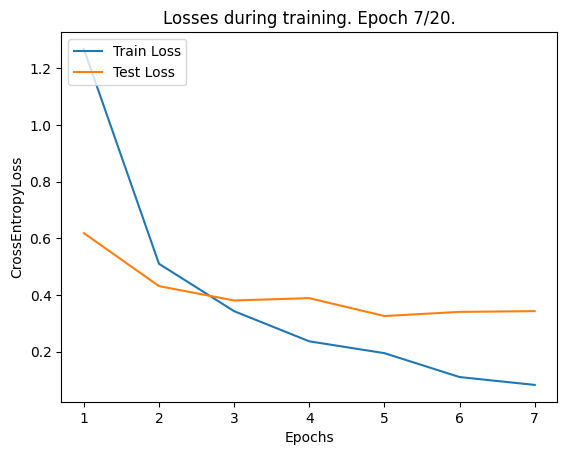

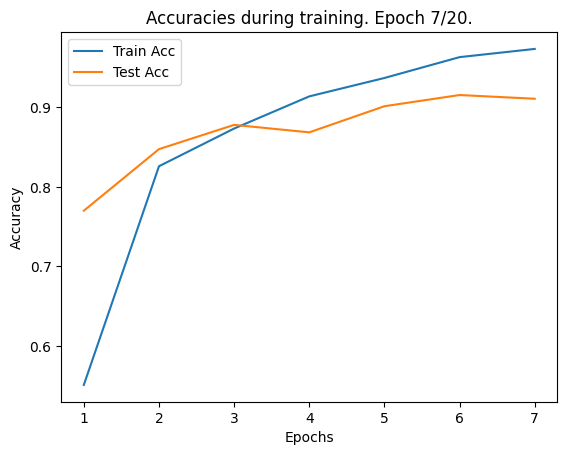

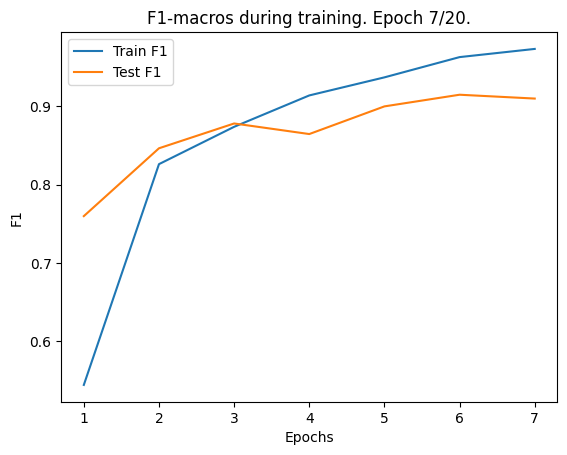

----------
Epoch Time: 0:03
Epoch 8/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.51it/s, Loss=0.063902, Corrects=250/256, Accuracy=97.656%]


Calculating metrics...
train loss: 0.045558, acc: 0.985491, f05_macro: 0.985464, f1_macro: 0.985464
Confusion matrix:
[[436   8   1   2   0   1   1   0]
 [  8 432   0   0   0   1   0   0]
 [  2   0 437   3   1   1   2   1]
 [  0   0   6 446   0   0   0   0]
 [  0   0   3   0 440   2   0   3]
 [  0   1   1   0   0 441   0   0]
 [  0   0   1   0   0   0 446   0]
 [  0   1   0   0   2   0   0 454]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s, Loss=0.347501, Corrects=155/170, Accuracy=91.176%]

Calculating metrics...
test loss: 0.367686, acc: 0.910798, f05_macro: 0.911976, f1_macro: 0.910982
Confusion matrix:
[[45  4  2  1  0  0  1  0]
 [ 5 48  0  0  0  0  0  0]
 [ 1  2 48  2  0  0  0  0]
 [ 1  1  4 45  1  0  0  2]
 [ 0  0  0  0 48  4  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  1  2  0  0  0 51  0]
 [ 0  0  1  0  0  0  0 52]]


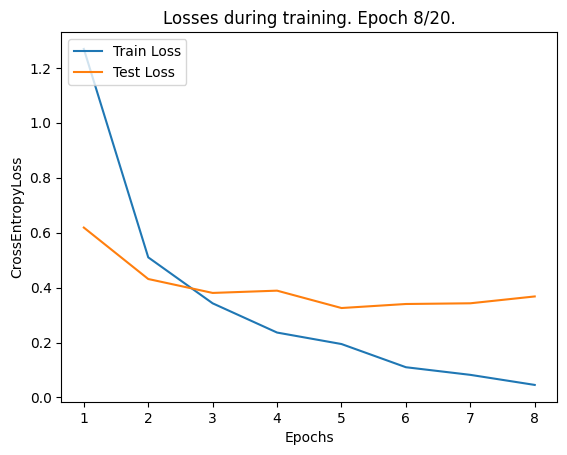

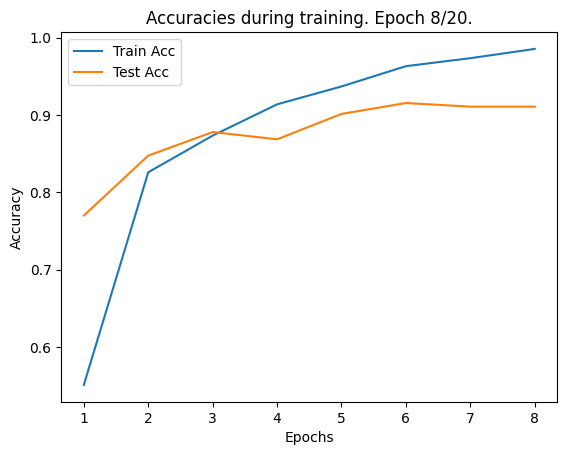

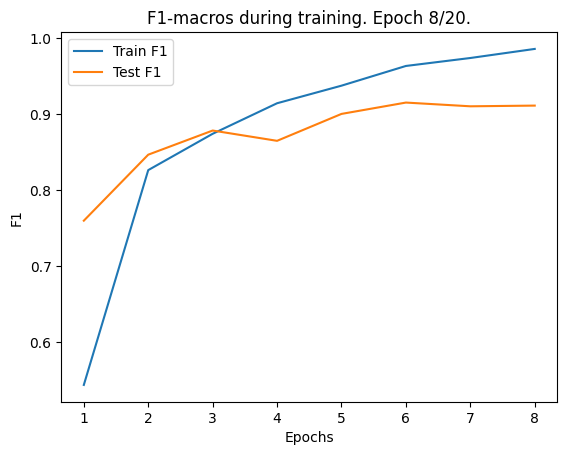

----------
Epoch Time: 0:04
Epoch 9/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.74it/s, Loss=0.018510, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.033383, acc: 0.989676, f05_macro: 0.989691, f1_macro: 0.989705
Confusion matrix:
[[436   1   1   0   0   1   0   0]
 [  4 441   0   1   0   0   0   0]
 [  1   2 438   4   2   0   0   0]
 [  1   2   4 452   0   0   0   1]
 [  0   0   0   0 448   2   0   7]
 [  0   0   0   0   0 447   0   0]
 [  0   0   0   0   0   0 443   0]
 [  0   0   1   1   1   0   0 442]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s, Loss=0.356952, Corrects=155/170, Accuracy=91.176%]

Calculating metrics...
test loss: 0.388286, acc: 0.906103, f05_macro: 0.905428, f1_macro: 0.905166
Confusion matrix:
[[43  5  2  2  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  1 43  6  0  0  1  1]
 [ 0  2  4 44  1  0  1  2]
 [ 0  0  0  0 49  3  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


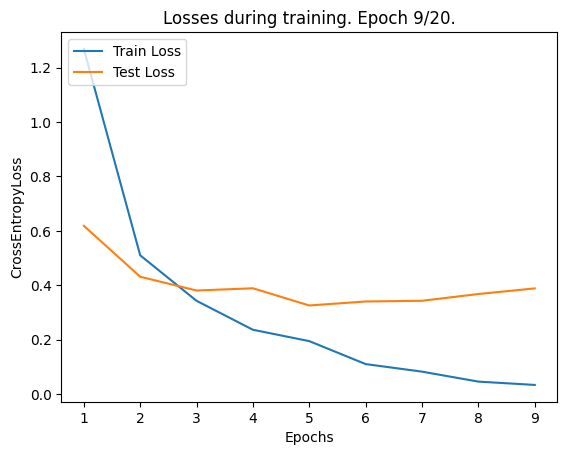

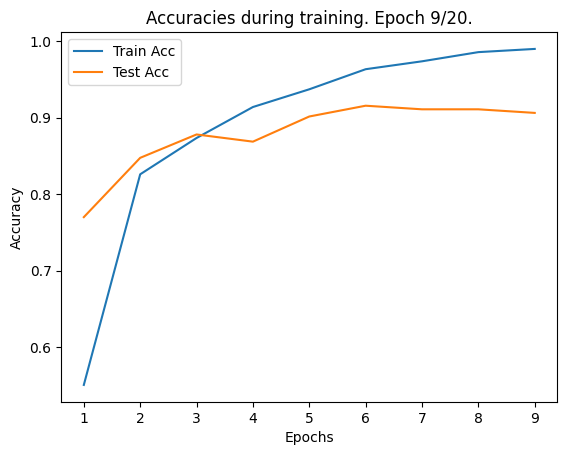

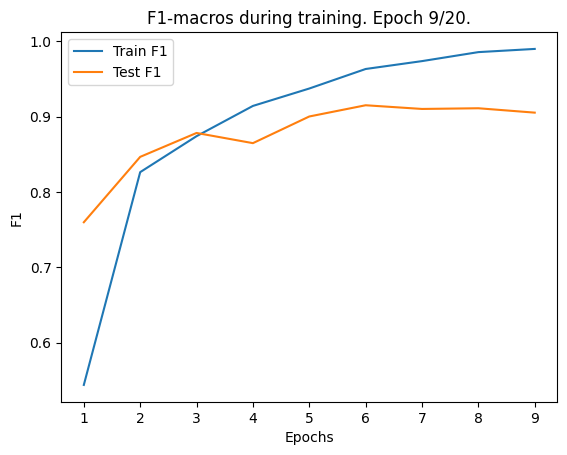

----------
Epoch Time: 0:03
Epoch 10/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.70it/s, Loss=0.022937, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.023023, acc: 0.993025, f05_macro: 0.993002, f1_macro: 0.992998
Confusion matrix:
[[430   3   2   1   0   0   0   0]
 [  5 443   0   0   0   0   1   0]
 [  2   1 450   0   0   0   0   0]
 [  0   0   2 442   0   0   0   1]
 [  0   0   2   0 445   0   0   1]
 [  0   1   0   0   0 453   0   0]
 [  0   0   0   0   0   0 447   0]
 [  0   0   0   0   3   0   0 449]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s, Loss=0.392948, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.442711, acc: 0.910798, f05_macro: 0.911384, f1_macro: 0.910124
Confusion matrix:
[[43  4  2  3  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  2 42  7  0  1  1  0]
 [ 0  2  3 48  1  0  0  0]
 [ 0  0  0  0 47  5  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


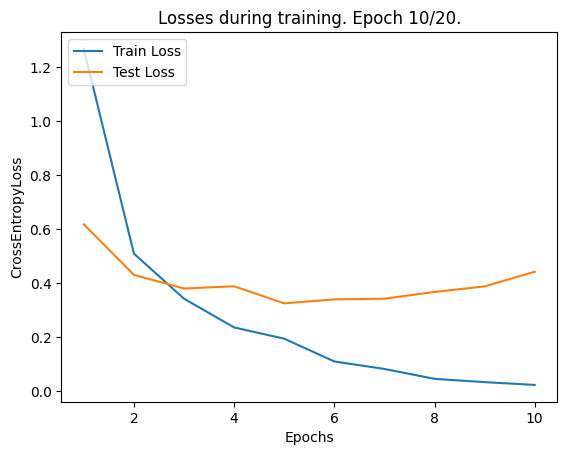

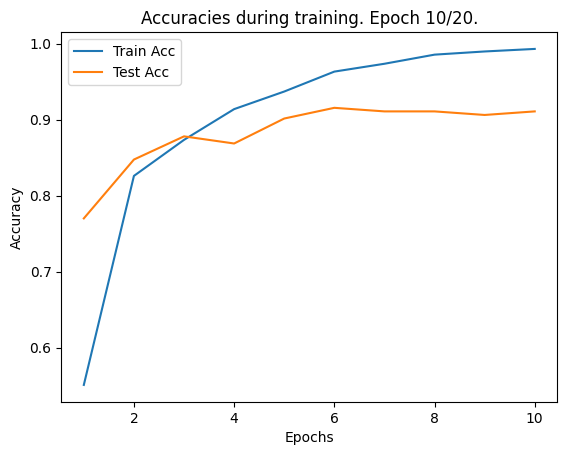

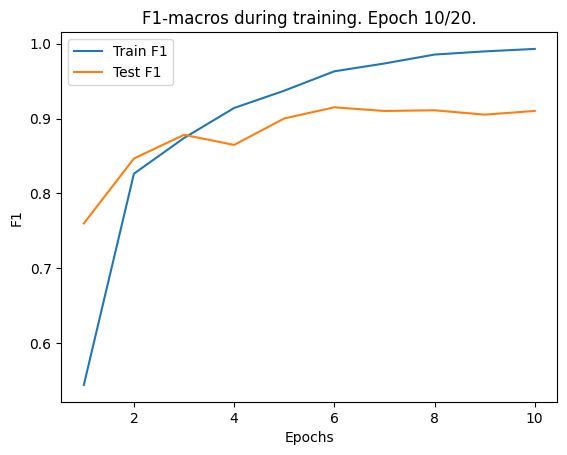

----------
Epoch Time: 0:03
Epoch 11/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.76it/s, Loss=0.014513, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.014486, acc: 0.994978, f05_macro: 0.994994, f1_macro: 0.994992
Confusion matrix:
[[447   3   0   0   0   1   0   0]
 [  4 447   0   1   0   0   0   0]
 [  1   0 446   3   0   0   0   0]
 [  0   1   0 444   0   0   0   0]
 [  0   0   1   0 444   0   0   0]
 [  0   0   0   0   1 439   0   0]
 [  0   0   0   0   0   0 448   0]
 [  0   0   0   2   0   0   0 451]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s, Loss=0.329697, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.398288, acc: 0.913146, f05_macro: 0.912241, f1_macro: 0.912303
Confusion matrix:
[[45  4  2  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 0  0 45  5  0  1  1  1]
 [ 1  1  4 44  1  0  1  2]
 [ 0  0  0  0 49  3  0  1]
 [ 1  0  0  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


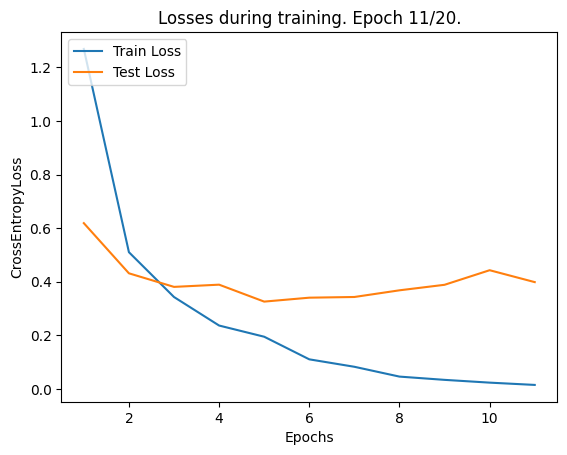

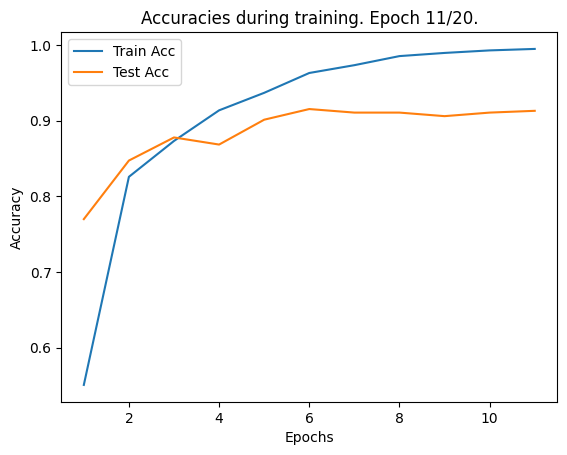

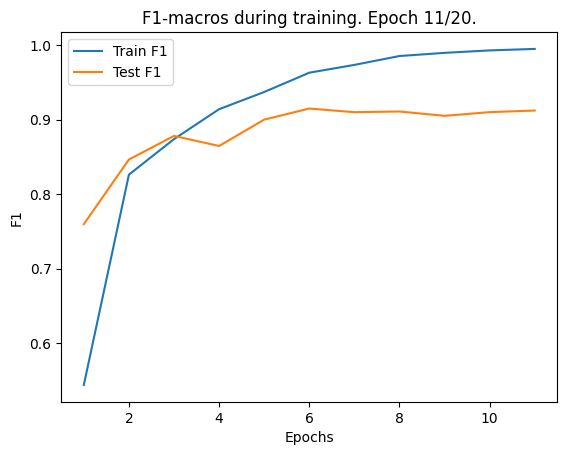

----------
Epoch Time: 0:03
Epoch 12/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.52it/s, Loss=0.023462, Corrects=254/256, Accuracy=99.219%]


Calculating metrics...
train loss: 0.014422, acc: 0.996373, f05_macro: 0.996383, f1_macro: 0.996377
Confusion matrix:
[[454   2   0   0   0   0   0   0]
 [  2 446   0   0   0   0   0   0]
 [  2   0 443   1   1   0   0   0]
 [  0   1   1 441   0   0   0   0]
 [  0   0   1   0 441   1   0   0]
 [  0   0   0   0   1 451   0   0]
 [  0   0   0   0   0   0 440   0]
 [  0   0   0   0   0   0   0 455]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s, Loss=0.342311, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.481002, acc: 0.913146, f05_macro: 0.913587, f1_macro: 0.912761
Confusion matrix:
[[44  5  1  2  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  0 47  4  0  0  1  0]
 [ 1  1  4 47  1  0  0  0]
 [ 0  0  0  0 45  7  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


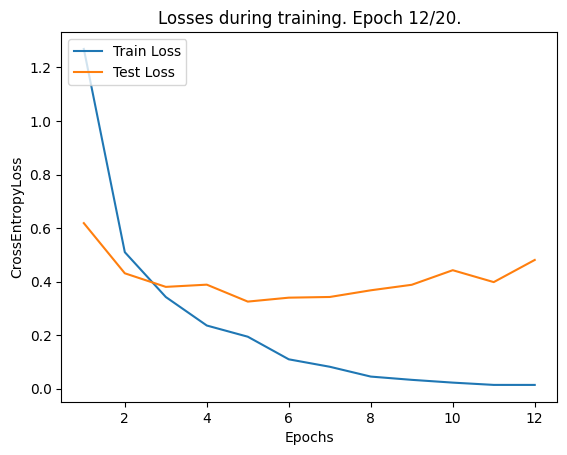

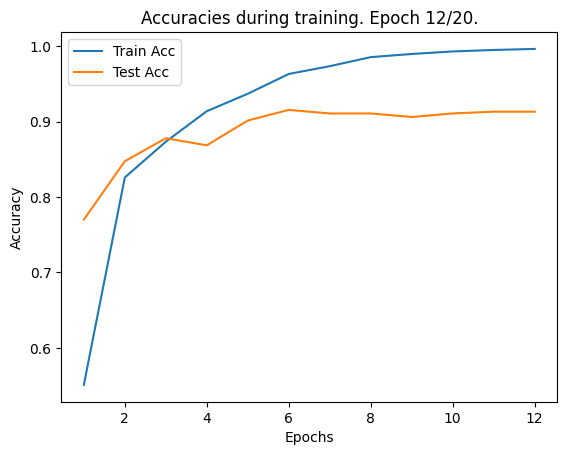

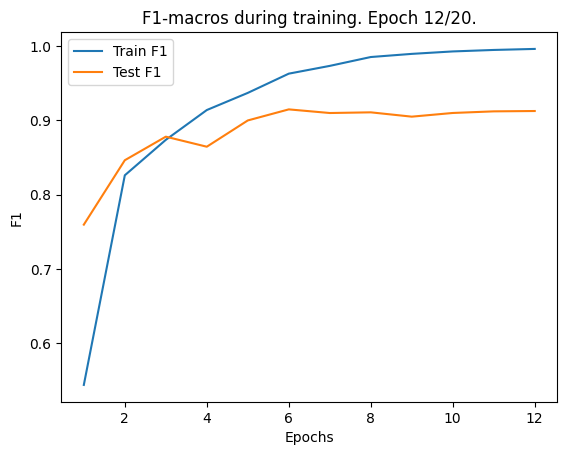

----------
Epoch Time: 0:04
Epoch 13/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.64it/s, Loss=0.004578, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.011199, acc: 0.996373, f05_macro: 0.996392, f1_macro: 0.996372
Confusion matrix:
[[458   1   0   0   0   0   0   0]
 [  4 443   0   0   0   0   0   0]
 [  0   1 440   0   0   1   0   0]
 [  0   0   2 433   0   0   0   1]
 [  0   0   0   0 447   2   0   0]
 [  0   0   0   0   0 452   0   0]
 [  0   0   0   0   0   0 452   0]
 [  0   0   0   0   1   0   0 446]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s, Loss=0.403695, Corrects=154/170, Accuracy=90.588%]

Calculating metrics...
test loss: 0.520414, acc: 0.889671, f05_macro: 0.892390, f1_macro: 0.888336
Confusion matrix:
[[38 12  0  2  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 1  3 39  8  0  0  1  1]
 [ 0  2  3 47  1  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 1  0  0  0  3 49  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


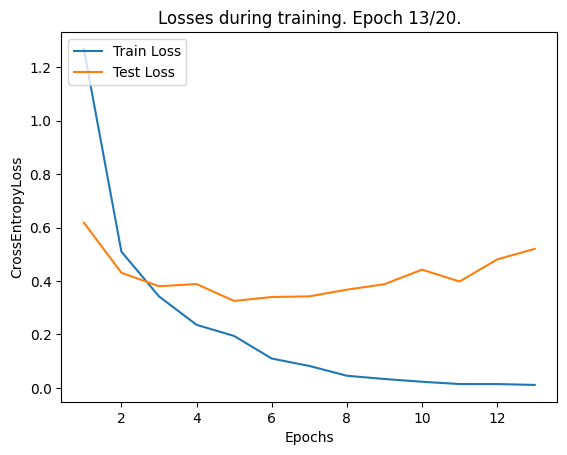

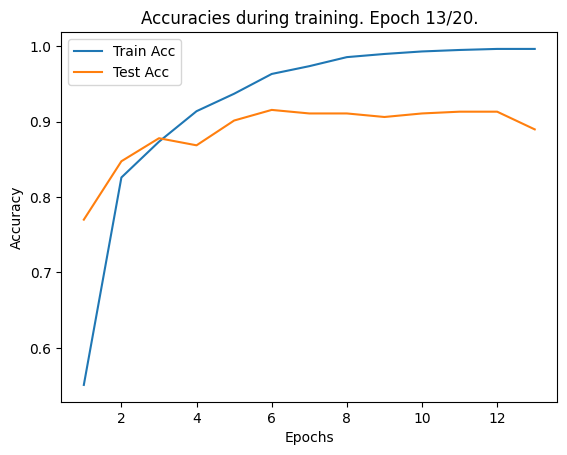

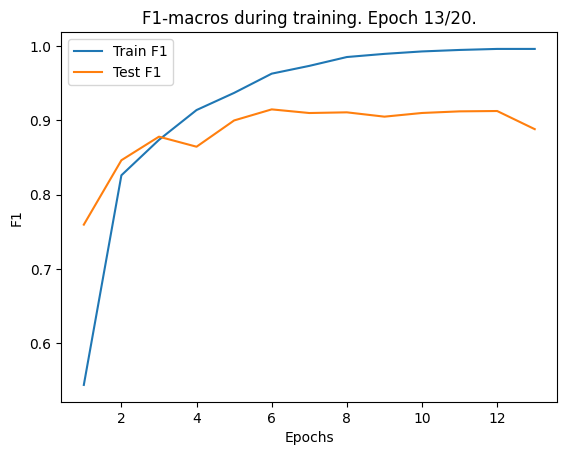

----------
Epoch Time: 0:03
Epoch 14/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.61it/s, Loss=0.023656, Corrects=254/256, Accuracy=99.219%]


Calculating metrics...
train loss: 0.014773, acc: 0.996094, f05_macro: 0.996103, f1_macro: 0.996104
Confusion matrix:
[[452   1   0   0   0   0   0   0]
 [  1 448   0   0   0   0   0   0]
 [  0   0 442   3   0   0   0   0]
 [  0   1   3 449   0   0   0   0]
 [  0   0   1   0 442   0   0   0]
 [  0   0   0   0   2 449   0   0]
 [  0   0   0   0   0   0 439   0]
 [  0   0   1   1   0   0   0 449]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s, Loss=0.352784, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.480359, acc: 0.910798, f05_macro: 0.911879, f1_macro: 0.910012
Confusion matrix:
[[45  4  3  0  0  0  1  0]
 [ 5 48  0  0  0  0  0  0]
 [ 0  0 50  1  0  1  1  0]
 [ 1  0  8 41  1  0  1  2]
 [ 0  0  0  0 48  4  0  1]
 [ 1  0  0  0  2 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


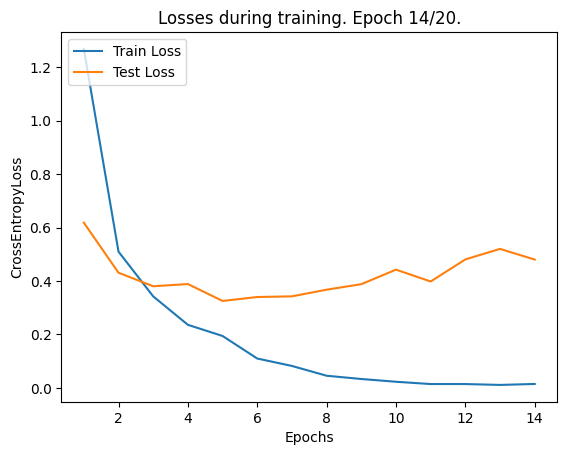

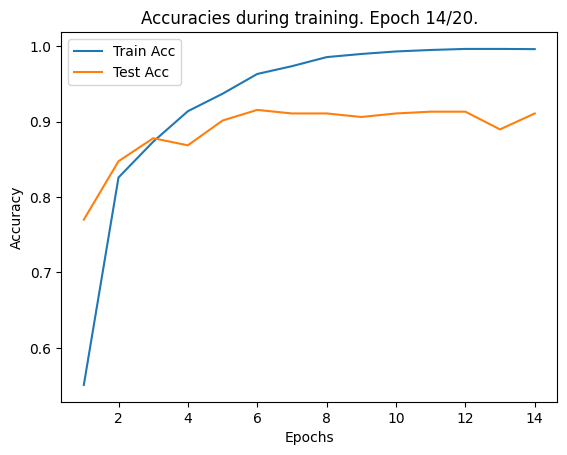

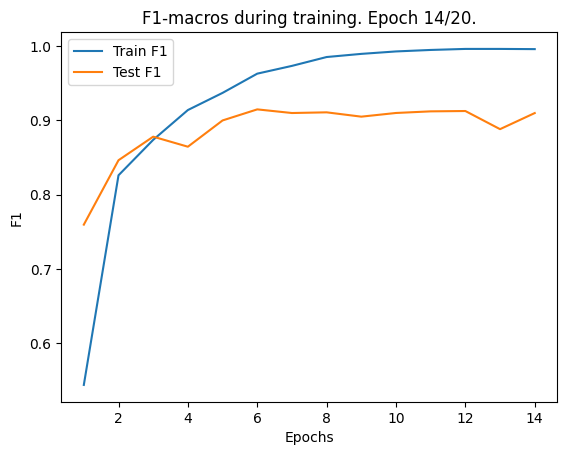

----------
Epoch Time: 0:03
Epoch 15/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.40it/s, Loss=0.020942, Corrects=254/256, Accuracy=99.219%]


Calculating metrics...
train loss: 0.015722, acc: 0.995257, f05_macro: 0.995250, f1_macro: 0.995249
Confusion matrix:
[[440   2   0   0   0   0   0   0]
 [  2 442   0   1   0   0   0   0]
 [  1   0 448   2   0   0   0   0]
 [  0   0   3 443   0   0   0   0]
 [  0   0   1   0 450   0   0   2]
 [  0   0   0   0   0 447   0   0]
 [  0   0   0   0   0   0 456   0]
 [  0   0   0   0   3   0   0 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s, Loss=0.464012, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.540819, acc: 0.899061, f05_macro: 0.904124, f1_macro: 0.898736
Confusion matrix:
[[37 14  1  0  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 1  3 46  1  0  0  1  1]
 [ 0  2  5 45  0  0  0  2]
 [ 0  0  0  0 47  4  0  2]
 [ 1  0  1  0  0 51  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


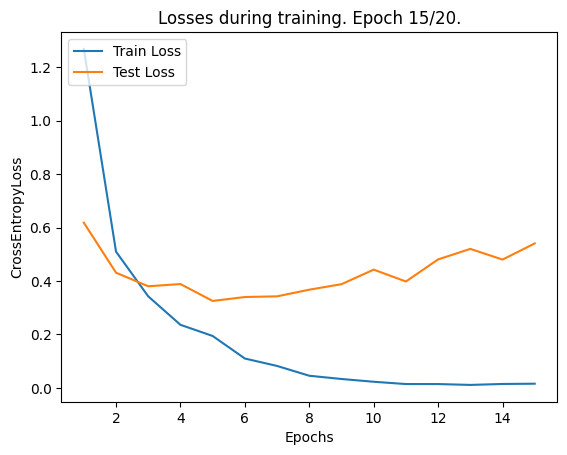

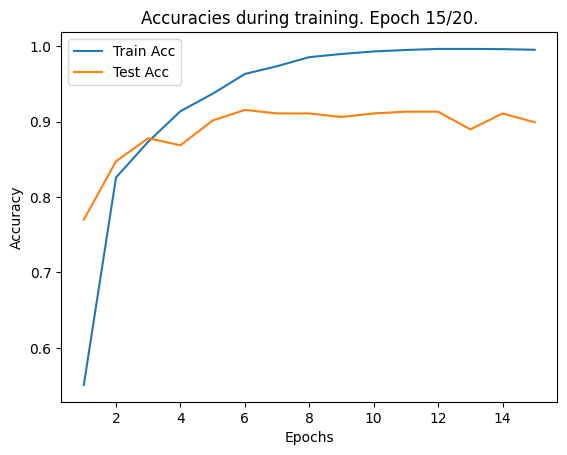

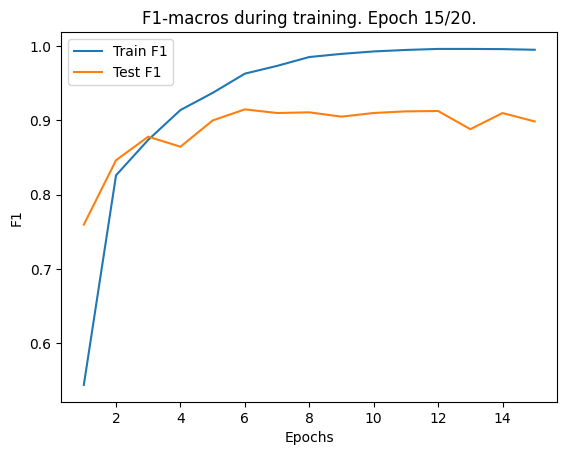

----------
Epoch Time: 0:04
Epoch 16/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.45it/s, Loss=0.006405, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.016493, acc: 0.994978, f05_macro: 0.994982, f1_macro: 0.994981
Confusion matrix:
[[449   1   0   1   0   0   0   0]
 [  2 435   0   0   0   0   0   0]
 [  1   0 445   0   1   0   0   0]
 [  1   0   1 444   0   0   0   0]
 [  0   0   0   0 448   0   0   4]
 [  0   1   0   0   0 454   0   0]
 [  0   0   0   0   0   0 447   0]
 [  0   0   0   2   3   0   0 444]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s, Loss=0.472803, Corrects=153/170, Accuracy=90.000%]

Calculating metrics...
test loss: 0.502059, acc: 0.908451, f05_macro: 0.908478, f1_macro: 0.907357
Confusion matrix:
[[45  5  1  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 1  3 41  5  0  0  1  2]
 [ 0  3  3 46  0  0  0  2]
 [ 0  0  0  0 48  4  0  1]
 [ 1  0  1  0  2 49  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


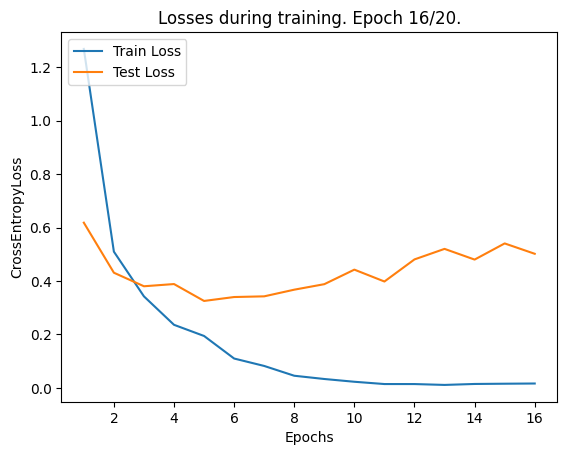

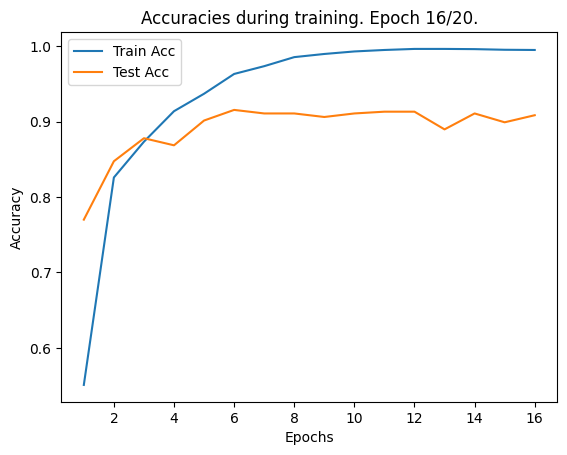

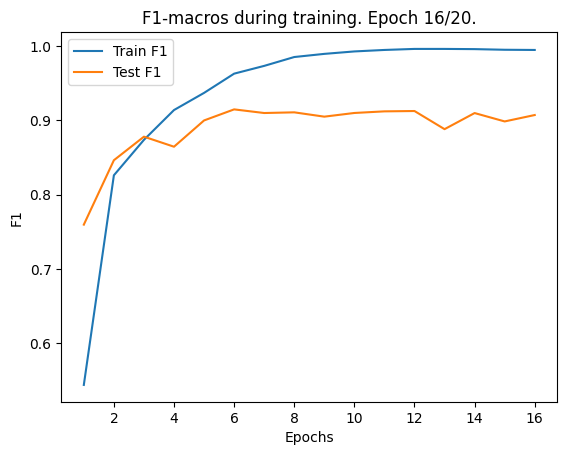

----------
Epoch Time: 0:04
Epoch 17/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.46it/s, Loss=0.007092, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.016019, acc: 0.995257, f05_macro: 0.995244, f1_macro: 0.995247
Confusion matrix:
[[444   3   0   0   0   0   0   0]
 [  2 433   0   1   0   0   0   0]
 [  2   0 447   1   1   0   0   0]
 [  0   0   0 447   0   0   0   1]
 [  0   0   1   0 446   1   0   1]
 [  0   0   1   0   1 457   0   0]
 [  0   0   0   0   0   0 448   0]
 [  0   0   0   0   1   0   0 445]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s, Loss=0.385048, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.479294, acc: 0.910798, f05_macro: 0.912114, f1_macro: 0.910574
Confusion matrix:
[[43  7  1  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 1  3 46  2  0  0  1  0]
 [ 0  2  3 46  2  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 1  0  1  0  3 48  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


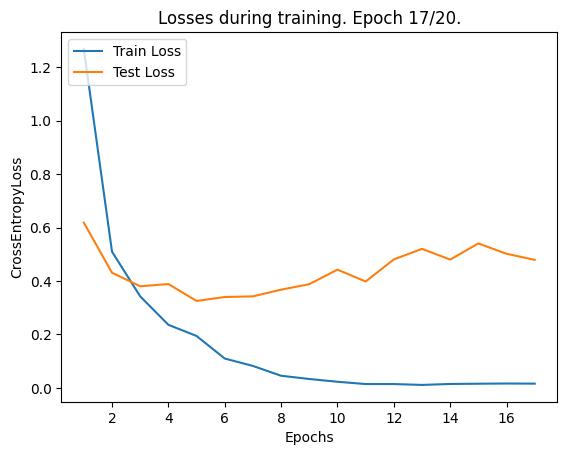

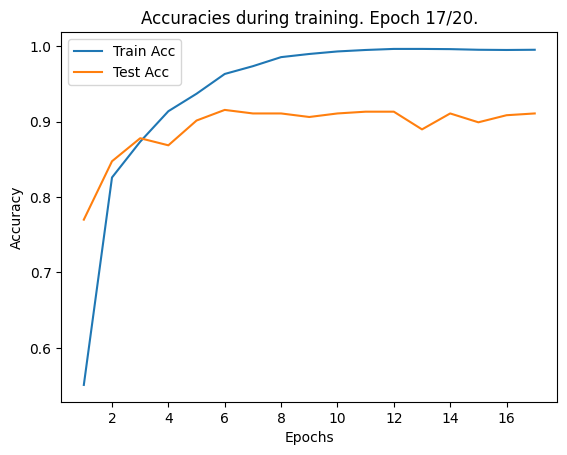

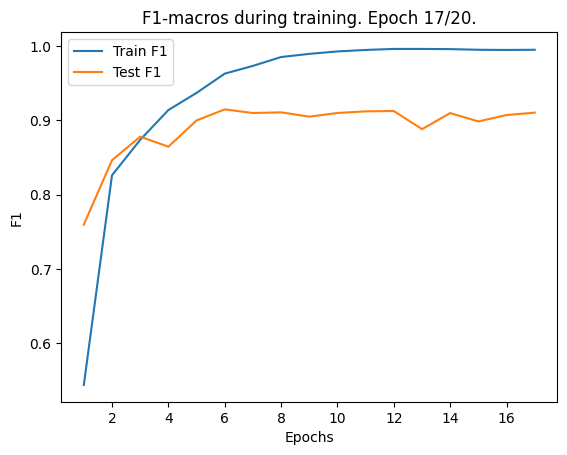

----------
Epoch Time: 0:04
Epoch 18/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.49it/s, Loss=0.016031, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.014266, acc: 0.996652, f05_macro: 0.996671, f1_macro: 0.996663
Confusion matrix:
[[444   3   1   0   0   0   0   0]
 [  2 455   0   0   0   0   0   0]
 [  0   0 448   2   0   0   0   0]
 [  0   0   0 443   0   0   0   1]
 [  0   0   2   0 441   0   0   1]
 [  0   0   0   0   0 439   0   0]
 [  0   0   0   0   0   0 449   0]
 [  0   0   0   0   0   0   0 453]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s, Loss=0.299739, Corrects=158/170, Accuracy=92.941%]

Calculating metrics...
test loss: 0.431055, acc: 0.917840, f05_macro: 0.918691, f1_macro: 0.918013
Confusion matrix:
[[46  4  1  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 0  3 47  1  0  1  1  0]
 [ 0  2  3 47  2  0  0  0]
 [ 0  0  0  0 50  3  0  0]
 [ 1  0  1  0  2 49  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  2  0  0  0 50]]


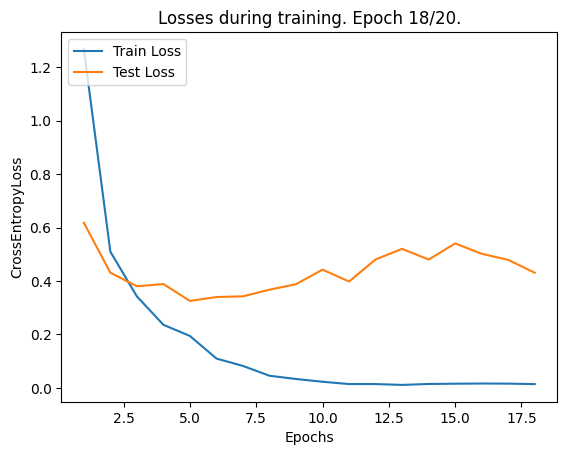

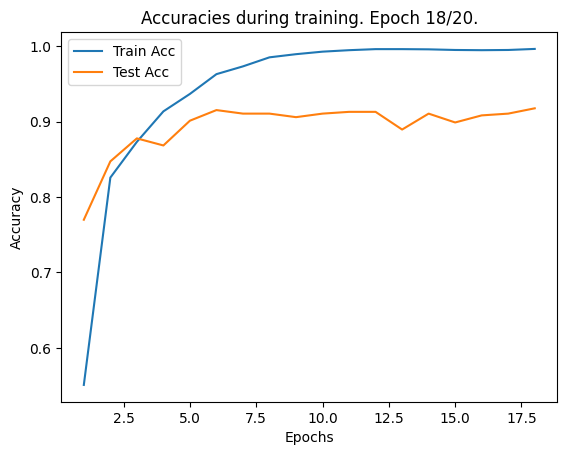

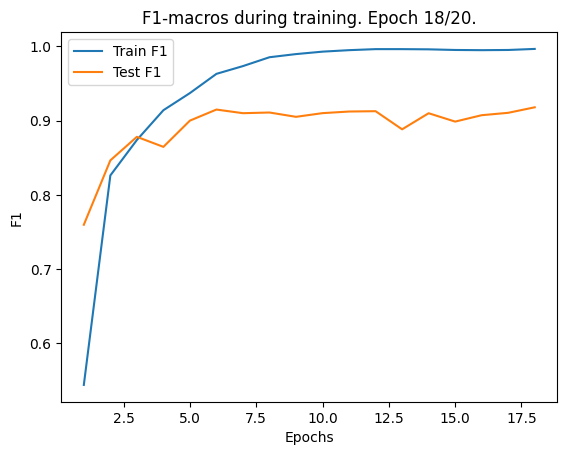

----------
Epoch Time: 0:04
Epoch 19/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.45it/s, Loss=0.004990, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.012278, acc: 0.997210, f05_macro: 0.997226, f1_macro: 0.997222
Confusion matrix:
[[454   2   0   0   0   0   0   0]
 [  0 446   0   0   0   0   0   0]
 [  2   0 444   1   0   0   0   0]
 [  0   2   0 448   0   0   0   0]
 [  0   0   0   0 448   0   0   1]
 [  0   0   0   0   0 444   0   0]
 [  0   0   0   0   0   0 443   0]
 [  0   0   0   2   0   0   0 447]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s, Loss=0.307659, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.437900, acc: 0.915493, f05_macro: 0.915963, f1_macro: 0.914953
Confusion matrix:
[[44  6  1  1  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 0  1 46  4  0  1  1  0]
 [ 1  1  3 47  0  0  0  2]
 [ 0  0  0  0 46  6  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


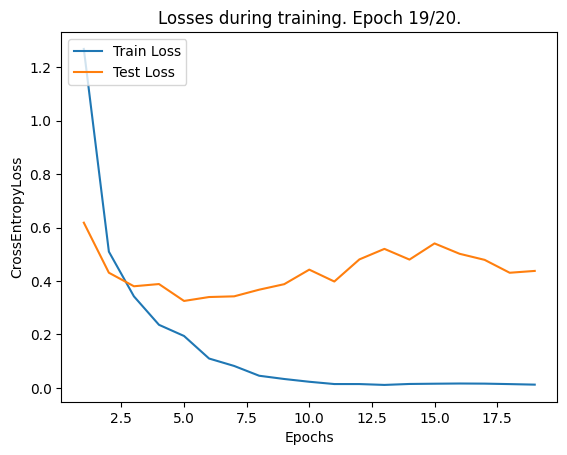

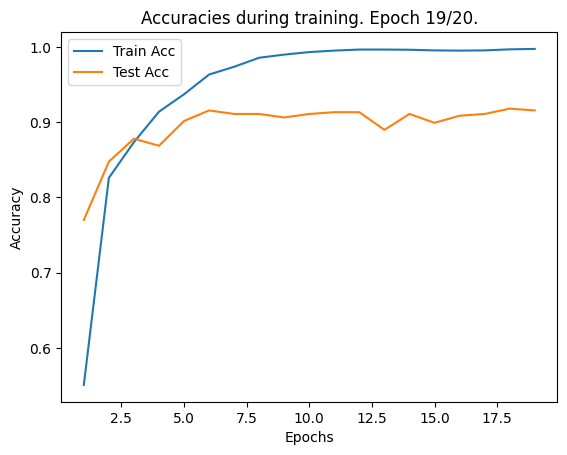

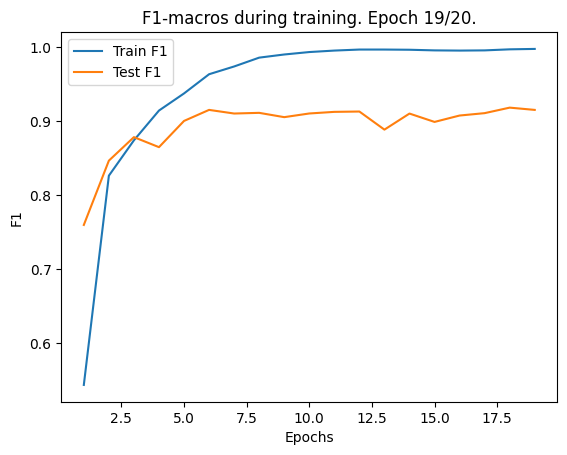

----------
Epoch Time: 0:04
Epoch 20/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.46it/s, Loss=0.015770, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.007459, acc: 0.998326, f05_macro: 0.998335, f1_macro: 0.998335
Confusion matrix:
[[447   2   1   0   0   0   0   0]
 [  2 448   0   0   0   0   0   0]
 [  0   0 451   0   0   0   0   0]
 [  0   0   0 437   0   0   0   0]
 [  0   0   0   0 453   0   0   0]
 [  0   0   0   0   0 445   0   0]
 [  0   0   0   0   0   0 445   0]
 [  0   0   0   0   1   0   0 452]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s, Loss=0.416293, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.492424, acc: 0.917840, f05_macro: 0.918218, f1_macro: 0.917456
Confusion matrix:
[[46  3  1  2  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 1  1 45  5  0  0  1  0]
 [ 1  1  3 47  0  0  0  2]
 [ 0  0  0  0 46  6  0  1]
 [ 1  0  1  0  0 51  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


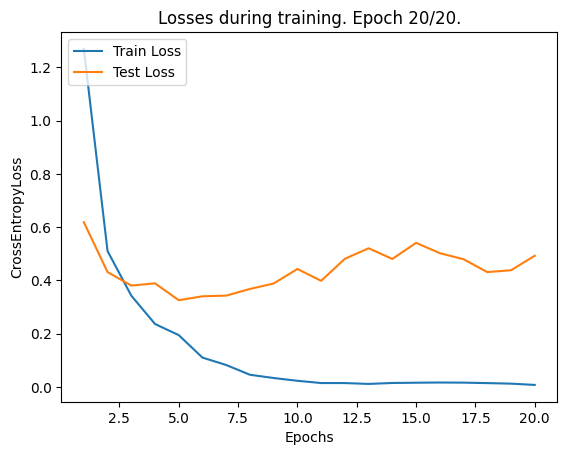

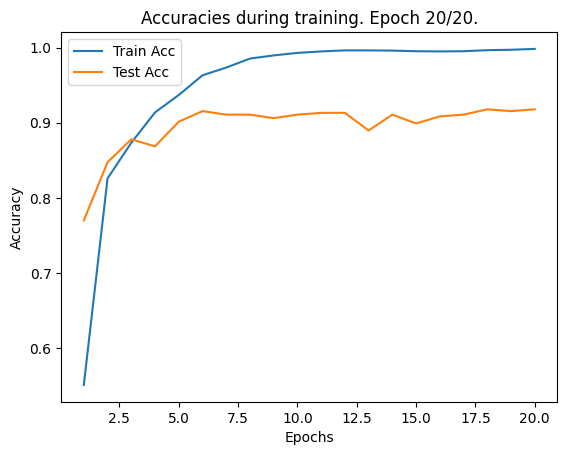

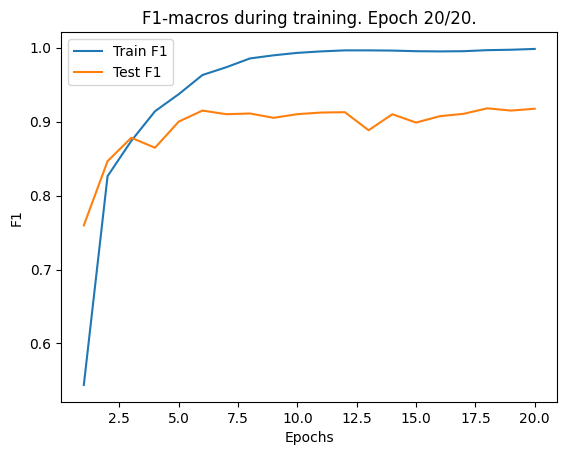

----------
Epoch Time: 0:04
*** Training Completed ***
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.57s/it, Loss=0.786598, Corrects=191/256, Accuracy=74.609%]


Calculating metrics...
train loss: 1.183146, acc: 0.564453, f05_macro: 0.565233, f1_macro: 0.559722
Confusion matrix:
[[218 121  19  22   2   3  39  27]
 [122 162  31  11   1   6  81  31]
 [ 38  44 198  61  13   5  37  49]
 [ 22  20 124 185   9   2  20  63]
 [ 12  14  13  14 264  56   0  78]
 [ 10  17   9   4  68 283  11  43]
 [ 13  51   5  10   1   4 326  36]
 [  9  14   7  13  19   4   3 387]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.622380, Corrects=129/170, Accuracy=75.882%]


Calculating metrics...
test loss: 0.619623, acc: 0.767606, f05_macro: 0.770797, f1_macro: 0.762720
Confusion matrix:
[[40  8  0  1  0  0  4  0]
 [17 27  0  1  0  0  8  0]
 [ 4  0 28 10  0  0 10  1]
 [ 1  1  7 42  0  0  3  0]
 [ 0  0  1  0 43  7  0  2]
 [ 1  0  0  0  4 48  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  8  0  0  0 45]]
----------
Epoch Time: 0:23
Epoch 2/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.46s/it, Loss=0.313870, Corrects=227/256, Accuracy=88.672%]


Calculating metrics...
train loss: 0.437660, acc: 0.851283, f05_macro: 0.851861, f1_macro: 0.851237
Confusion matrix:
[[377  63   6   9   0   1   2   0]
 [ 89 328   7   9   0   0  15   0]
 [ 25  20 329  51   4   1  16   1]
 [ 16   7  49 349   0   0   2   9]
 [  0   0  15   6 398  19   0  12]
 [  1   5   5   0   6 425   0   0]
 [  0   4  13   1   0   0 433   1]
 [  2   0   4  14  22   0   1 412]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.384233, Corrects=149/170, Accuracy=87.647%]

Calculating metrics...
test loss: 0.406119, acc: 0.875587, f05_macro: 0.882308, f1_macro: 0.875322
Confusion matrix:
[[46  4  2  0  0  0  1  0]
 [11 42  0  0  0  0  0  0]
 [ 3  0 49  1  0  0  0  0]
 [ 2  0 15 36  0  0  0  1]
 [ 0  0  1  0 51  0  0  1]
 [ 0  0  1  0  9 43  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  0  0  0  0  0 53]]


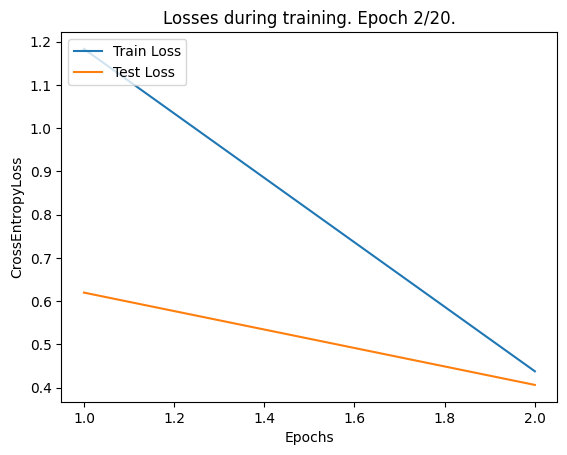

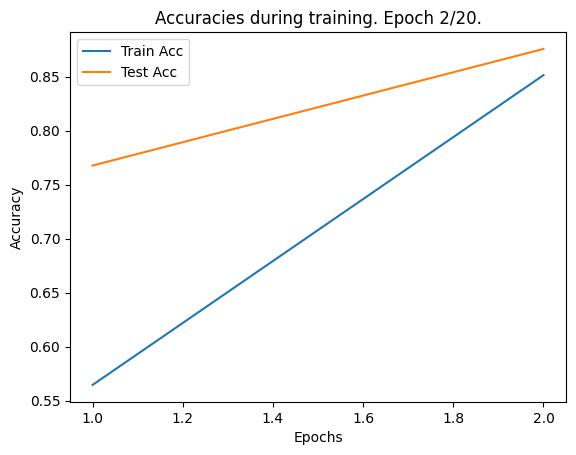

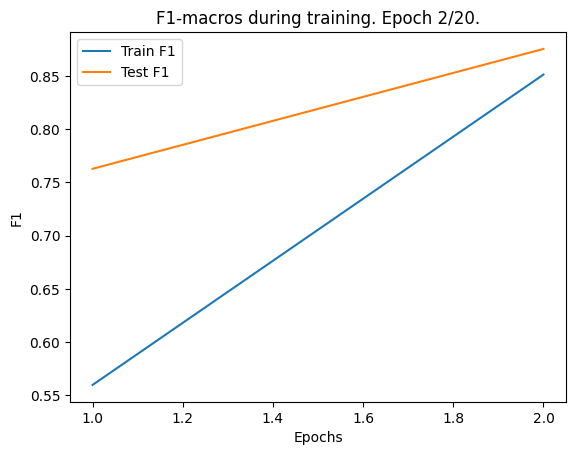

----------
Epoch Time: 0:22
Epoch 3/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.46s/it, Loss=0.243383, Corrects=235/256, Accuracy=91.797%]


Calculating metrics...
train loss: 0.235950, acc: 0.919643, f05_macro: 0.920276, f1_macro: 0.919892
Confusion matrix:
[[400  33  10   4   0   1   2   0]
 [ 36 406   5   5   0   0   3   0]
 [ 17   1 393  29   6   1   1   1]
 [ 12   6  40 378   1   0   2   4]
 [  0   0  14   2 406   5   0   9]
 [  2   1   3   0   7 437   0   0]
 [  1   3   3   1   0   0 446   0]
 [  0   1   4   4   8   0   0 430]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s, Loss=0.279945, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.320058, acc: 0.908451, f05_macro: 0.912769, f1_macro: 0.907949
Confusion matrix:
[[44  5  2  0  0  1  1  0]
 [ 5 48  0  0  0  0  0  0]
 [ 0  0 53  0  0  0  0  0]
 [ 0  1 12 40  0  0  0  1]
 [ 0  0  1  0 45  6  0  1]
 [ 0  0  1  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


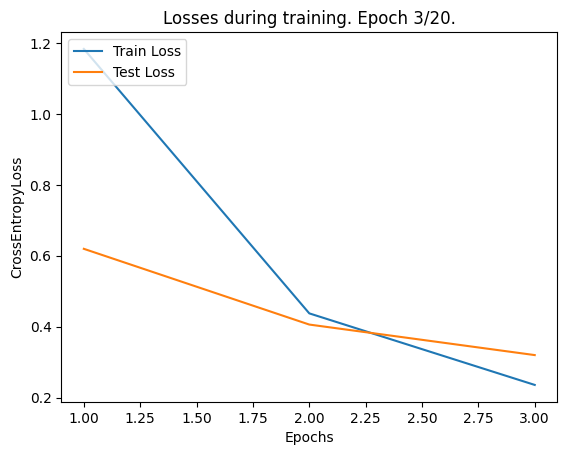

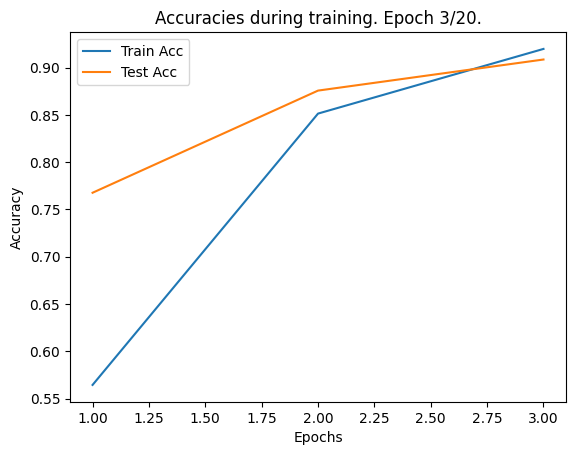

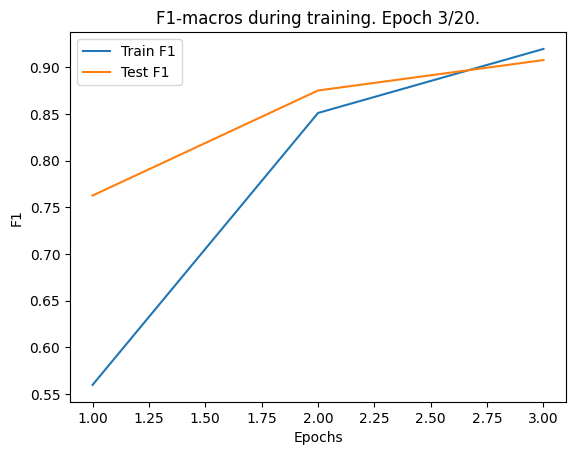

----------
Epoch Time: 0:22
Epoch 4/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.50s/it, Loss=0.149979, Corrects=246/256, Accuracy=96.094%]


Calculating metrics...
train loss: 0.130847, acc: 0.959821, f05_macro: 0.959925, f1_macro: 0.959855
Confusion matrix:
[[434   9   2   2   0   1   2   0]
 [ 18 424   2   4   0   0   5   0]
 [  6   0 421  13   4   0   1   0]
 [  3   2  16 425   0   0   0   1]
 [  0   0   8   0 426   8   0   9]
 [  1   2   2   0   2 442   0   0]
 [  0   2   1   0   0   0 440   0]
 [  1   0   2   3  10   0   2 428]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.249956, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.271693, acc: 0.927230, f05_macro: 0.927506, f1_macro: 0.926931
Confusion matrix:
[[49  2  1  0  0  0  1  0]
 [ 5 48  0  0  0  0  0  0]
 [ 3  0 45  5  0  0  0  0]
 [ 0  1  4 47  0  0  0  2]
 [ 0  0  0  0 48  3  0  2]
 [ 1  0  0  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


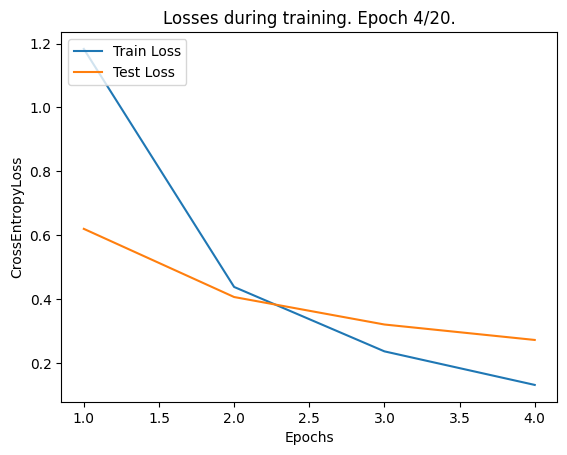

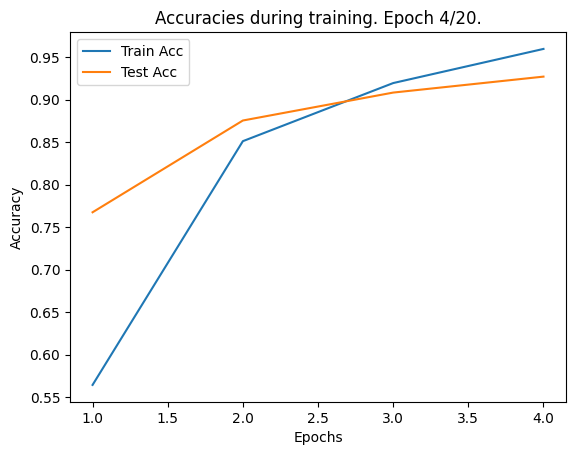

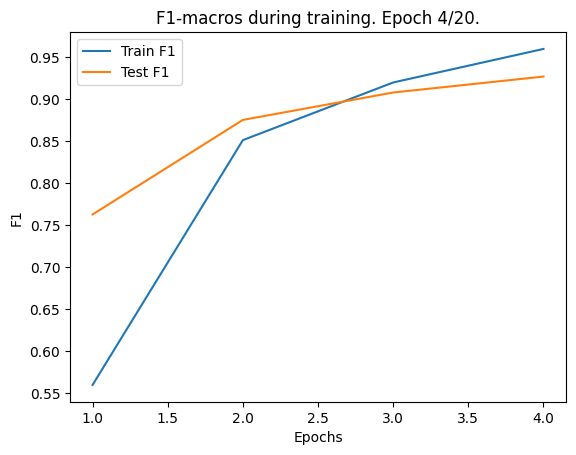

----------
Epoch Time: 0:22
Epoch 5/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it, Loss=0.197069, Corrects=238/256, Accuracy=92.969%]


Calculating metrics...
train loss: 0.100125, acc: 0.965123, f05_macro: 0.965163, f1_macro: 0.965100
Confusion matrix:
[[416  24   6   2   0   1   0   0]
 [ 13 424   1   1   0   1   3   0]
 [  6   0 424  10   4   0   1   1]
 [  1   4  14 434   0   0   0   0]
 [  0   0   8   0 431   2   0   7]
 [  0   0   1   1   0 456   0   0]
 [  0   3   0   0   0   0 436   0]
 [  0   0   2   2   6   0   0 438]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.374904, Corrects=148/170, Accuracy=87.059%]

Calculating metrics...
test loss: 0.394458, acc: 0.887324, f05_macro: 0.890098, f1_macro: 0.881584
Confusion matrix:
[[27 22  1  2  0  0  1  0]
 [ 0 53  0  0  0  0  0  0]
 [ 0  0 44  7  0  1  1  0]
 [ 0  0  4 48  0  0  0  2]
 [ 0  0  0  0 48  3  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


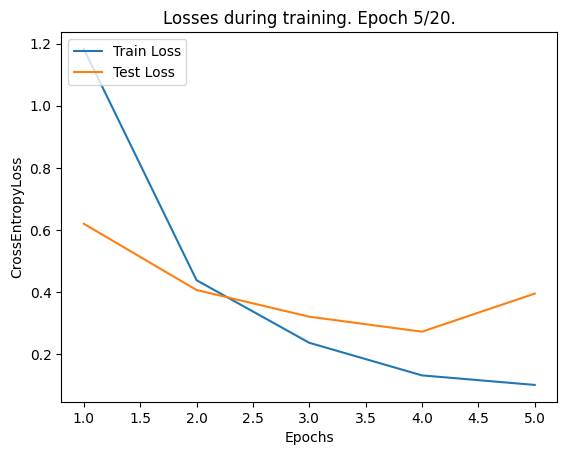

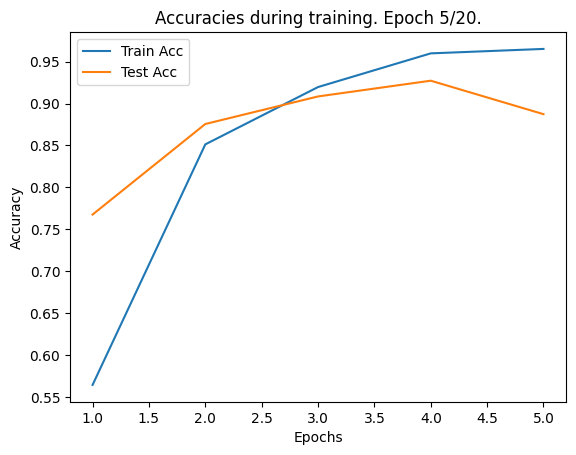

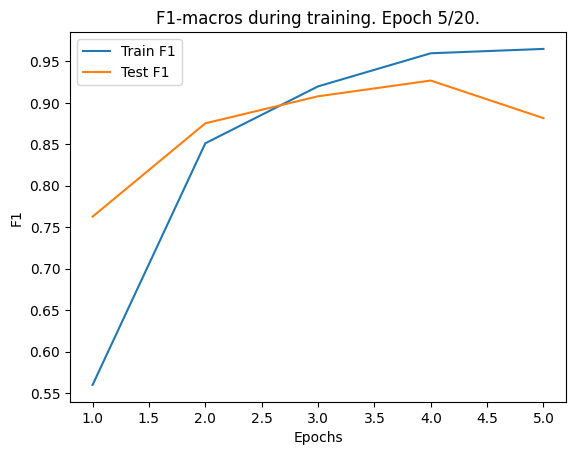

----------
Epoch Time: 0:22
Epoch 6/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.50s/it, Loss=0.071870, Corrects=251/256, Accuracy=98.047%]


Calculating metrics...
train loss: 0.089478, acc: 0.969308, f05_macro: 0.969462, f1_macro: 0.969422
Confusion matrix:
[[406  37   2   0   0   0   0   0]
 [ 32 418   1   1   0   0   1   0]
 [  2   0 438   2   2   0   0   0]
 [  3   0   2 447   0   0   0   3]
 [  0   0   3   0 439   0   0   6]
 [  1   0   1   0   2 443   0   0]
 [  1   1   0   0   0   0 436   0]
 [  2   0   0   0   4   0   1 447]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.206192, Corrects=159/170, Accuracy=93.529%]

Calculating metrics...
test loss: 0.254902, acc: 0.934272, f05_macro: 0.935490, f1_macro: 0.934198
Confusion matrix:
[[49  2  1  0  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 2  0 49  2  0  0  0  0]
 [ 2  0  7 44  0  0  0  1]
 [ 0  0  0  0 48  4  0  1]
 [ 1  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


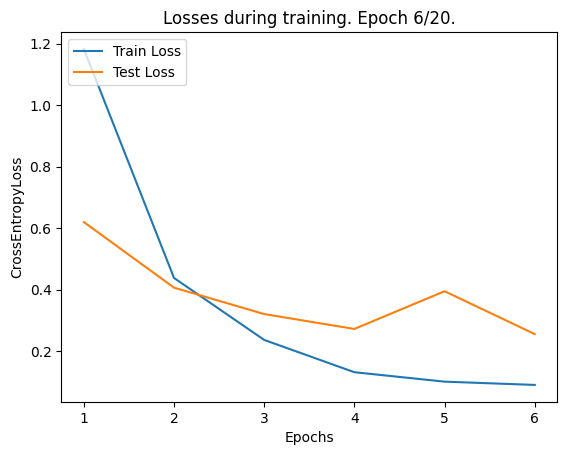

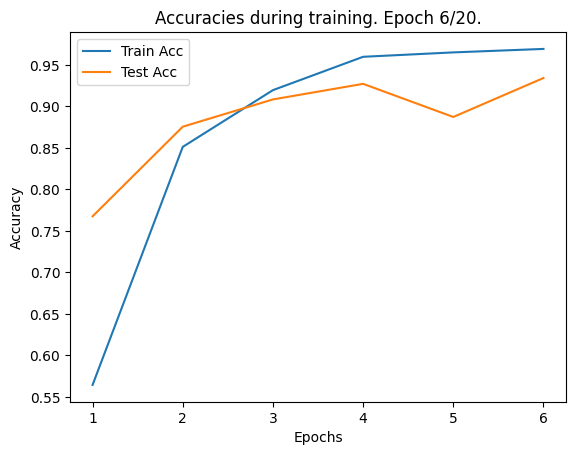

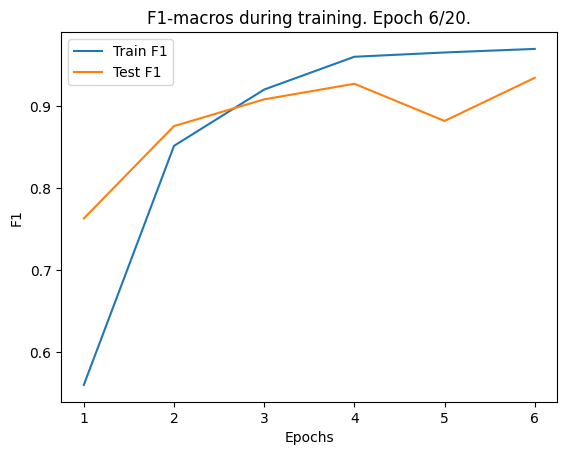

----------
Epoch Time: 0:22
Epoch 7/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it, Loss=0.008031, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.027512, acc: 0.991908, f05_macro: 0.991911, f1_macro: 0.991900
Confusion matrix:
[[445   3   1   0   0   0   0   0]
 [  3 448   0   0   0   0   0   0]
 [  3   0 445   0   1   0   0   0]
 [  0   0   1 439   0   0   1   2]
 [  0   0   1   0 445   0   0   3]
 [  1   2   0   0   0 443   0   0]
 [  0   1   0   0   0   0 453   0]
 [  0   0   0   4   2   0   0 437]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.382730, Corrects=155/170, Accuracy=91.176%]

Calculating metrics...
test loss: 0.331891, acc: 0.936620, f05_macro: 0.937228, f1_macro: 0.936038
Confusion matrix:
[[44  5  2  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  6 46  1  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


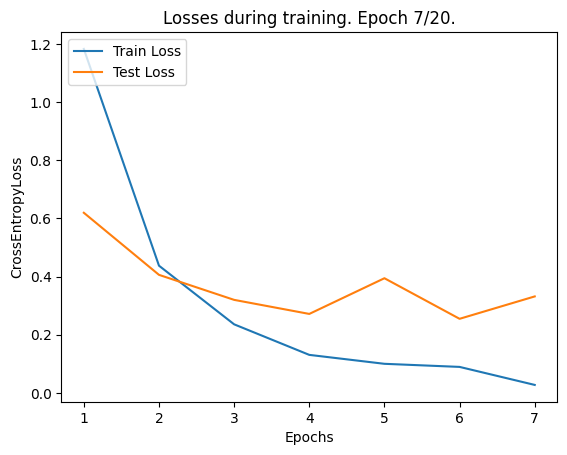

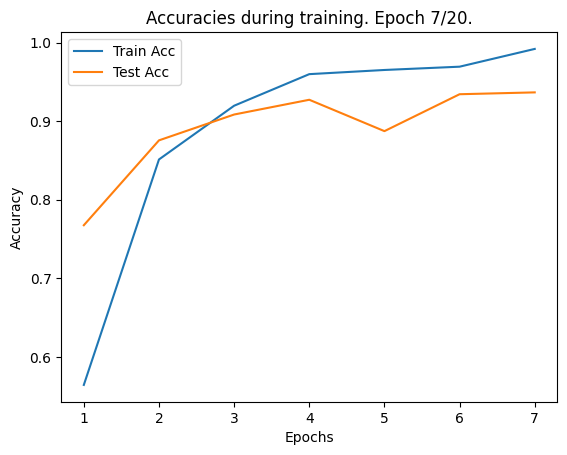

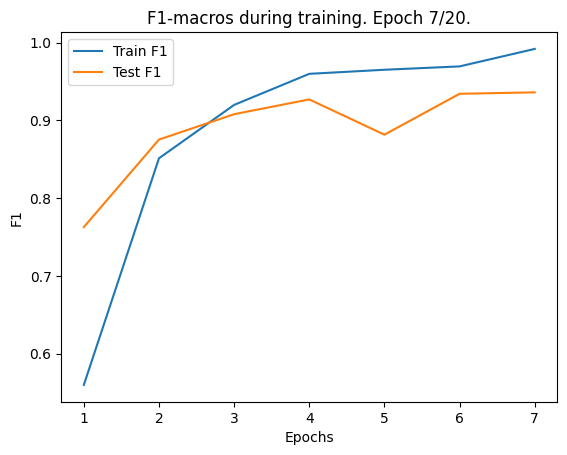

----------
Epoch Time: 0:22
Epoch 8/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.49s/it, Loss=0.005497, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.018960, acc: 0.993862, f05_macro: 0.993831, f1_macro: 0.993830
Confusion matrix:
[[427   5   1   0   0   0   0   0]
 [  2 453   0   0   0   0   3   0]
 [  2   0 434   0   1   0   0   0]
 [  0   0   0 450   0   0   0   0]
 [  0   0   1   0 443   0   0   2]
 [  0   0   0   0   0 458   0   0]
 [  0   0   0   0   0   0 446   0]
 [  1   0   0   1   3   0   0 451]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.451650, Corrects=154/170, Accuracy=90.588%]

Calculating metrics...
test loss: 0.374681, acc: 0.927230, f05_macro: 0.929302, f1_macro: 0.927094
Confusion matrix:
[[43  4  3  2  0  0  1  0]
 [ 1 51  0  1  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  7 45  1  0  0  1]
 [ 0  0  0  0 51  1  0  1]
 [ 0  0  0  0  3 50  0  0]
 [ 0  2  1  0  0  0 51  0]
 [ 0  0  1  0  0  0  0 52]]


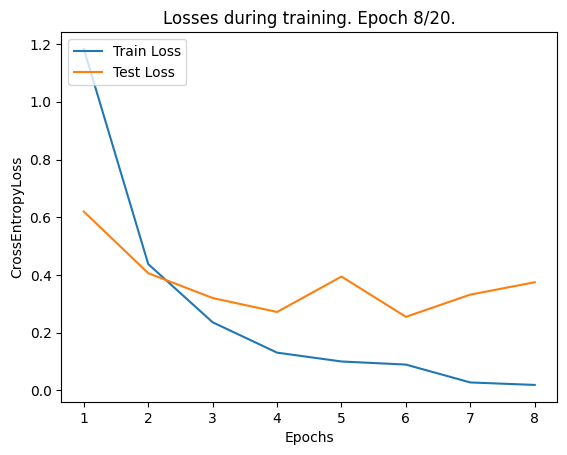

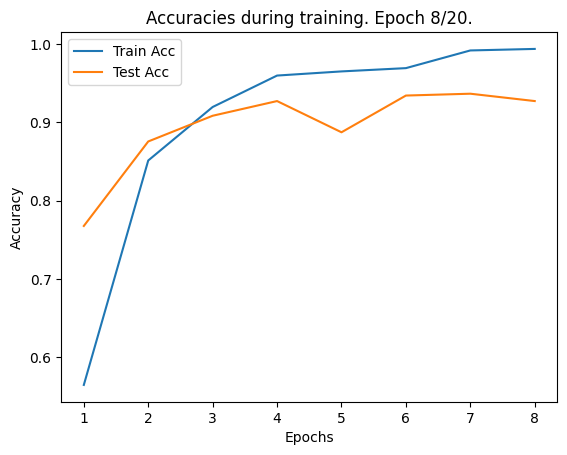

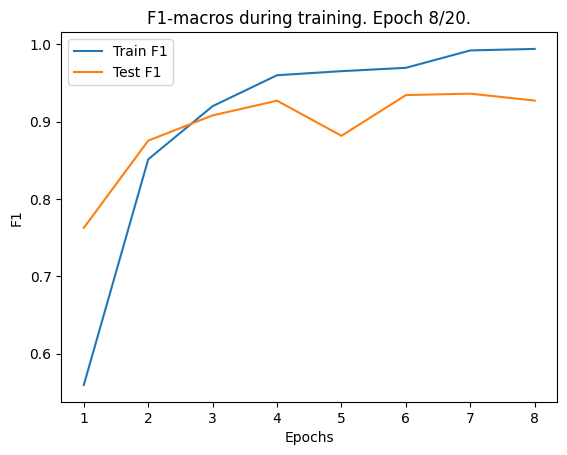

----------
Epoch Time: 0:22
Epoch 9/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it, Loss=0.006453, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.016706, acc: 0.995536, f05_macro: 0.995548, f1_macro: 0.995546
Confusion matrix:
[[441   0   1   0   0   0   0   0]
 [  1 448   0   1   0   0   0   0]
 [  0   0 450   0   0   0   1   0]
 [  1   1   1 443   0   0   0   0]
 [  0   0   1   0 449   2   0   1]
 [  0   0   0   0   3 447   0   0]
 [  0   1   0   0   0   0 443   0]
 [  0   0   0   0   1   0   0 447]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.345037, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.438676, acc: 0.917840, f05_macro: 0.920473, f1_macro: 0.917619
Confusion matrix:
[[47  3  1  1  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  0 40 11  0  0  0  1]
 [ 0  0  1 52  0  0  0  1]
 [ 0  0  0  0 47  4  0  2]
 [ 1  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  3  0  0  0 49]]


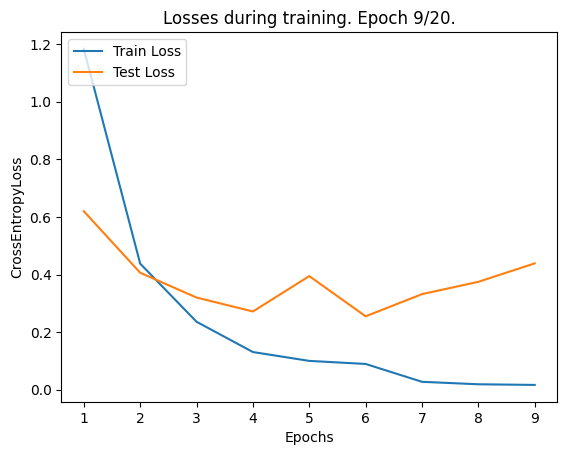

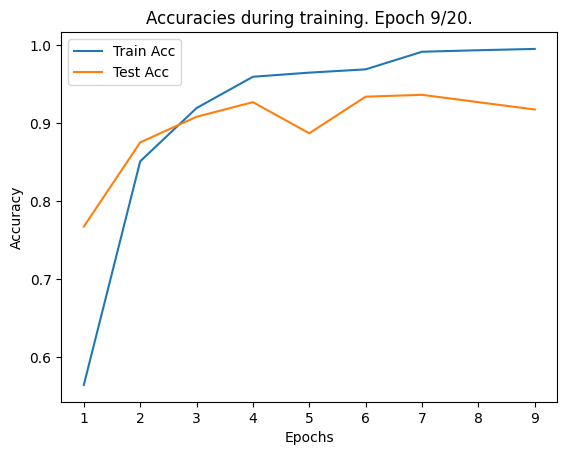

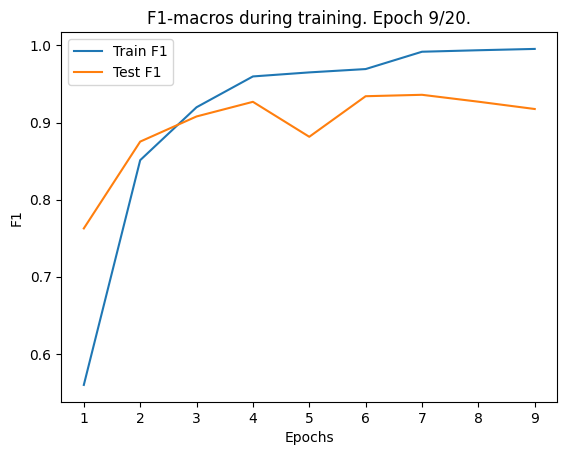

----------
Epoch Time: 0:22
Epoch 10/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it, Loss=0.018412, Corrects=254/256, Accuracy=99.219%]


Calculating metrics...
train loss: 0.018400, acc: 0.995257, f05_macro: 0.995258, f1_macro: 0.995258
Confusion matrix:
[[446   0   1   0   0   0   0   0]
 [  0 445   0   0   0   0   0   0]
 [  1   0 449   2   1   0   0   0]
 [  0   1   1 450   0   0   0   1]
 [  0   0   1   0 441   4   0   1]
 [  0   0   0   0   1 442   0   0]
 [  0   0   0   0   0   0 453   0]
 [  0   0   0   2   0   0   0 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.355716, Corrects=155/170, Accuracy=91.176%]

Calculating metrics...
test loss: 0.373595, acc: 0.920188, f05_macro: 0.920356, f1_macro: 0.920110
Confusion matrix:
[[46  3  2  1  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  0 47  5  0  0  0  0]
 [ 0  0  5 48  0  0  0  1]
 [ 0  0  0  0 47  4  0  2]
 [ 1  0  0  0  3 49  0  0]
 [ 0  0  1  0  0  0 53  0]
 [ 0  0  1  0  0  0  0 52]]


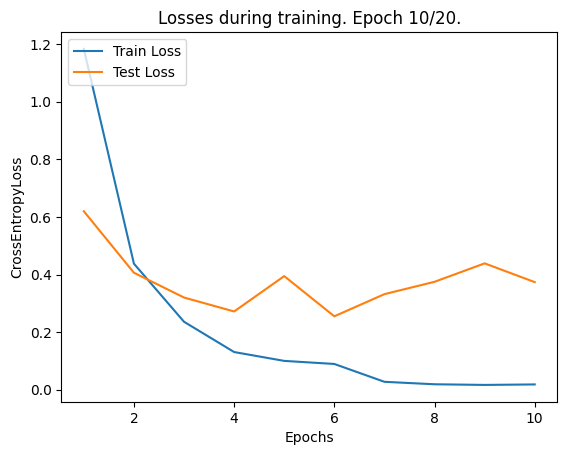

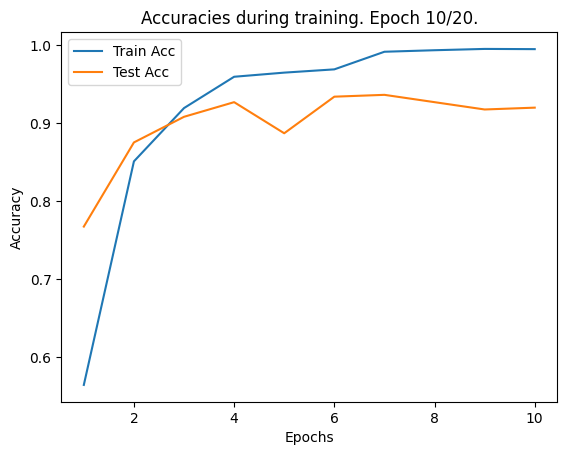

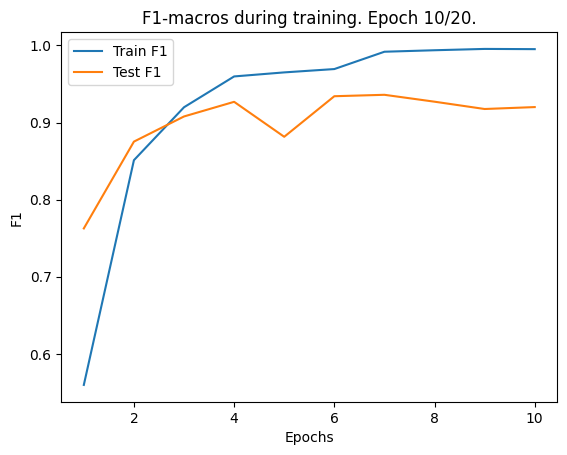

----------
Epoch Time: 0:22
Epoch 11/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.50s/it, Loss=0.019885, Corrects=253/256, Accuracy=98.828%]


Calculating metrics...
train loss: 0.010494, acc: 0.995815, f05_macro: 0.995813, f1_macro: 0.995814
Confusion matrix:
[[441   0   3   0   0   0   0   0]
 [  1 443   0   0   0   0   0   0]
 [  3   0 444   1   0   0   0   0]
 [  0   0   0 442   0   0   0   1]
 [  0   0   0   0 451   1   0   2]
 [  0   0   0   0   1 455   0   0]
 [  0   0   0   0   0   0 447   0]
 [  0   0   0   1   1   0   0 446]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.466213, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.436991, acc: 0.922535, f05_macro: 0.924526, f1_macro: 0.922607
Confusion matrix:
[[45  4  3  0  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  0 50  2  0  0  0  0]
 [ 0  0  9 44  0  0  0  1]
 [ 0  0  0  0 48  3  0  2]
 [ 0  0  1  0  2 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


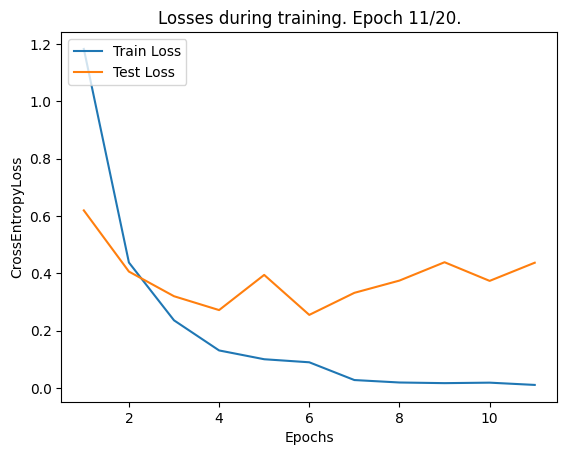

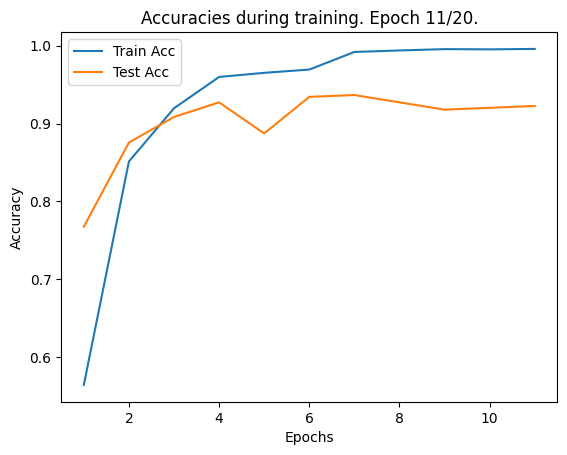

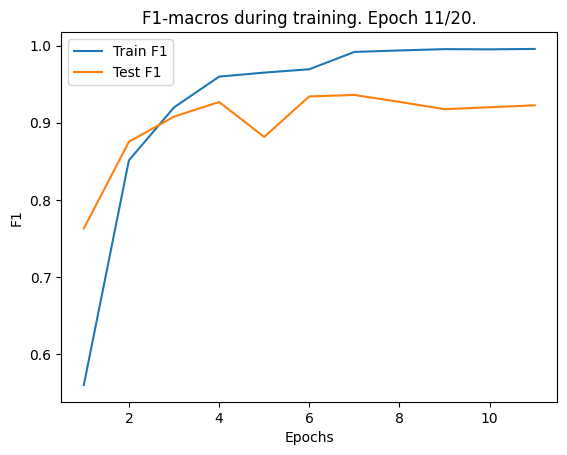

----------
Epoch Time: 0:22
Epoch 12/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.50s/it, Loss=0.005360, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.008684, acc: 0.997768, f05_macro: 0.997787, f1_macro: 0.997780
Confusion matrix:
[[445   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 442   0   1   0   0   0]
 [  0   0   0 449   0   0   0   1]
 [  0   0   0   0 454   1   0   0]
 [  0   0   0   0   2 447   0   0]
 [  0   1   0   0   0   0 446   0]
 [  0   0   0   1   1   0   0 446]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.472967, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.529740, acc: 0.917840, f05_macro: 0.920200, f1_macro: 0.917176
Confusion matrix:
[[44  6  2  0  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 0  0 50  1  0  1  1  0]
 [ 0  1  9 43  0  0  0  1]
 [ 0  0  0  0 45  6  0  2]
 [ 0  0  0  0  0 53  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


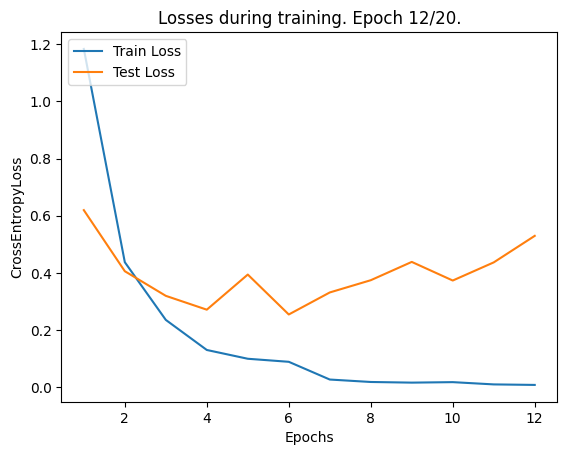

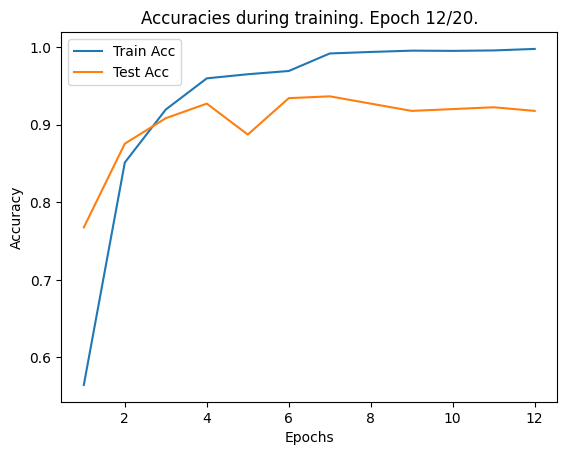

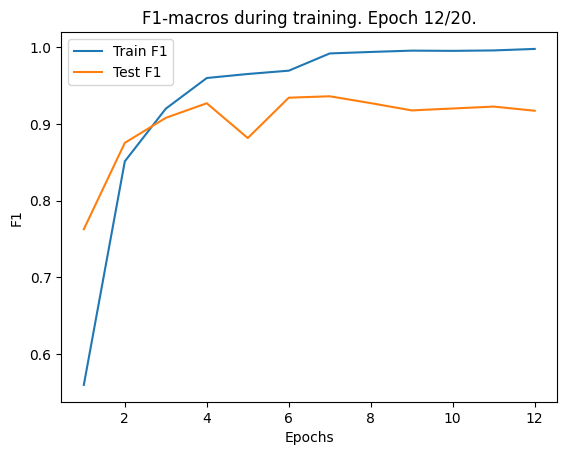

----------
Epoch Time: 0:22
Epoch 13/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it, Loss=0.001528, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.006140, acc: 0.998605, f05_macro: 0.998605, f1_macro: 0.998611
Confusion matrix:
[[449   0   0   0   0   0   0   0]
 [  0 453   0   0   0   0   0   0]
 [  0   0 445   0   0   0   0   0]
 [  0   0   0 443   0   0   0   1]
 [  0   0   1   0 455   1   0   1]
 [  0   0   0   0   0 439   0   0]
 [  0   0   0   0   0   0 444   0]
 [  0   0   0   1   0   0   0 451]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.364311, Corrects=158/170, Accuracy=92.941%]

Calculating metrics...
test loss: 0.417170, acc: 0.929577, f05_macro: 0.929111, f1_macro: 0.929185
Confusion matrix:
[[47  3  1  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 2  0 45  5  1  0  0  0]
 [ 0  0  4 48  1  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  0  0  1 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


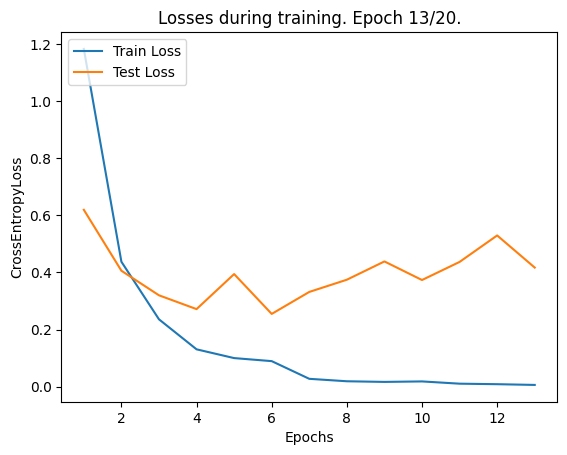

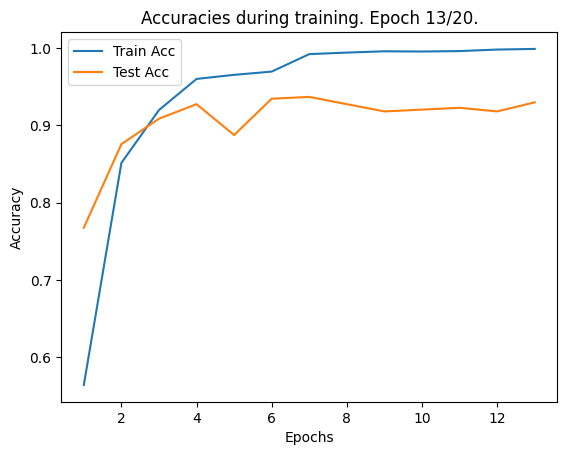

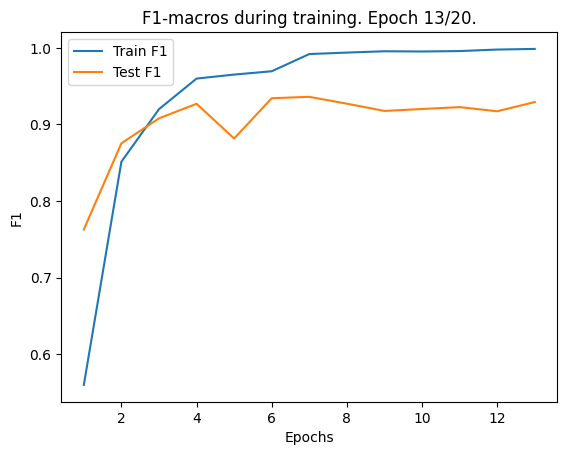

----------
Epoch Time: 0:22
Epoch 14/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.46s/it, Loss=0.005611, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.003555, acc: 0.999163, f05_macro: 0.999156, f1_macro: 0.999158
Confusion matrix:
[[457   0   0   0   0   0   0   0]
 [  0 452   0   0   0   0   0   0]
 [  0   0 452   0   0   0   0   0]
 [  0   0   0 454   0   0   0   1]
 [  0   0   0   0 447   1   0   0]
 [  0   0   0   0   1 439   0   0]
 [  0   0   0   0   0   0 439   0]
 [  0   0   0   0   0   0   0 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.430795, Corrects=154/170, Accuracy=90.588%]

Calculating metrics...
test loss: 0.426622, acc: 0.929577, f05_macro: 0.929943, f1_macro: 0.929564
Confusion matrix:
[[46  3  2  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 1  0 48  4  0  0  0  0]
 [ 0  0  5 48  0  0  0  1]
 [ 0  0  0  0 50  1  0  2]
 [ 0  0  1  0  3 49  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


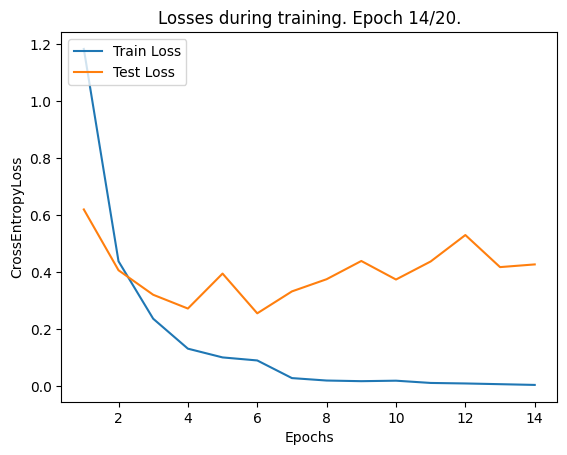

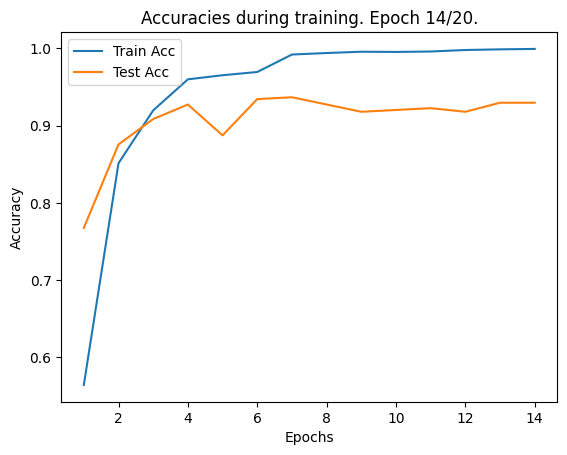

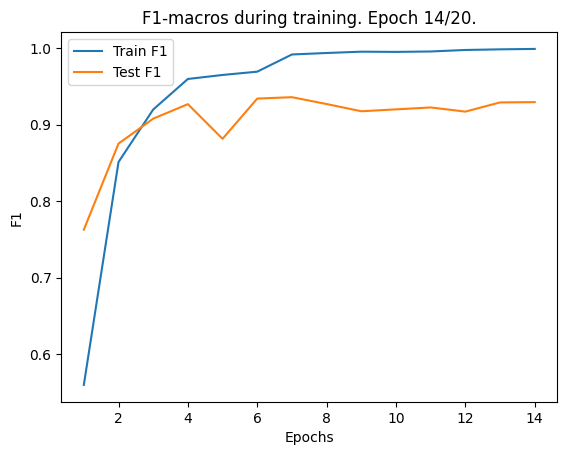

----------
Epoch Time: 0:22
Epoch 15/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it, Loss=0.000380, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.000778, acc: 1.000000, f05_macro: 1.000000, f1_macro: 1.000000
Confusion matrix:
[[450   0   0   0   0   0   0   0]
 [  0 443   0   0   0   0   0   0]
 [  0   0 447   0   0   0   0   0]
 [  0   0   0 447   0   0   0   0]
 [  0   0   0   0 451   0   0   0]
 [  0   0   0   0   0 452   0   0]
 [  0   0   0   0   0   0 444   0]
 [  0   0   0   0   0   0   0 450]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.397677, Corrects=158/170, Accuracy=92.941%]

Calculating metrics...
test loss: 0.450515, acc: 0.931925, f05_macro: 0.931973, f1_macro: 0.931604
Confusion matrix:
[[45  5  1  1  0  0  1  0]
 [ 3 50  0  0  0  0  0  0]
 [ 1  0 47  5  0  0  0  0]
 [ 0  0  4 49  0  0  0  1]
 [ 0  0  0  0 48  3  0  2]
 [ 1  0  0  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


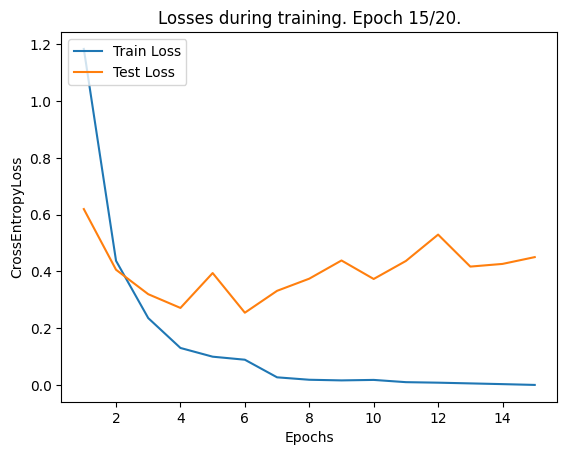

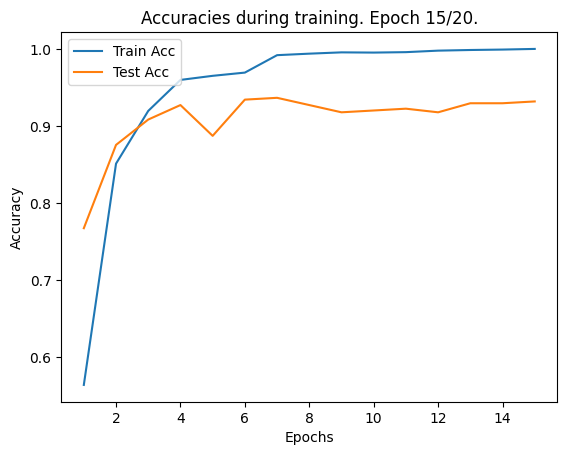

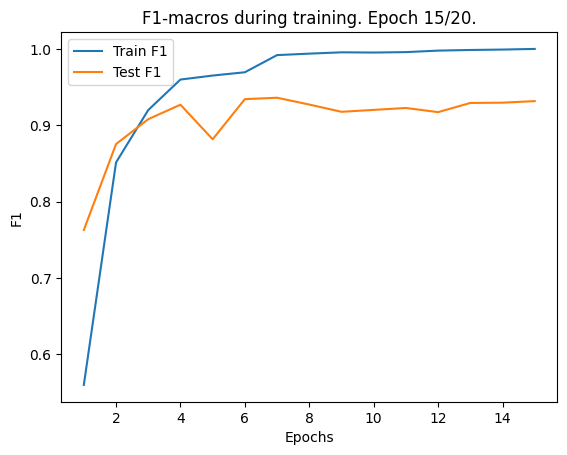

----------
Epoch Time: 0:22
Epoch 16/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.50s/it, Loss=0.000034, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.000771, acc: 0.999442, f05_macro: 0.999442, f1_macro: 0.999440
Confusion matrix:
[[442   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 440   0   1   0   0   0]
 [  0   0   0 455   0   0   0   0]
 [  0   0   0   0 442   0   0   0]
 [  0   0   0   0   0 455   0   0]
 [  0   0   0   0   0   0 453   0]
 [  0   0   0   1   0   0   0 448]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.475159, Corrects=154/170, Accuracy=90.588%]

Calculating metrics...
test loss: 0.485374, acc: 0.924883, f05_macro: 0.925184, f1_macro: 0.924629
Confusion matrix:
[[45  4  2  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 1  0 49  3  0  0  0  0]
 [ 0  0  7 46  0  0  0  1]
 [ 0  0  0  0 48  3  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


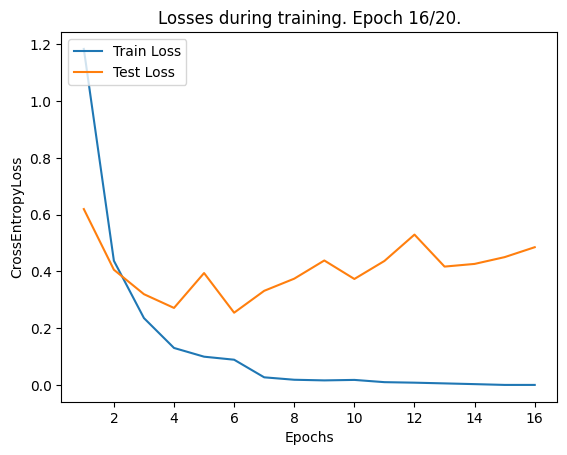

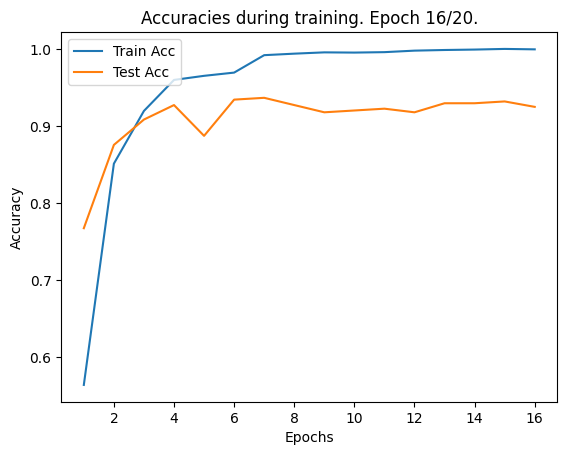

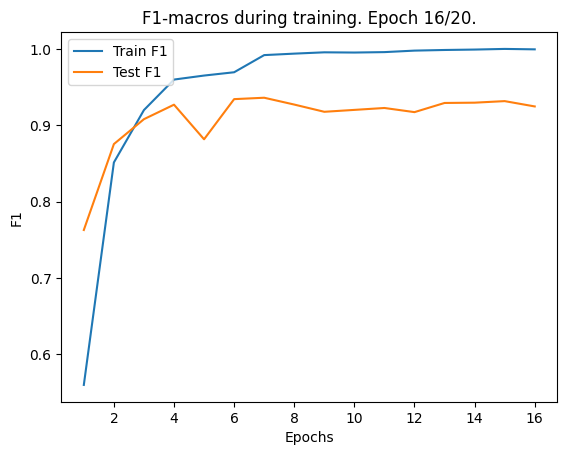

----------
Epoch Time: 0:22
Epoch 17/20
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it, Loss=0.016951, Corrects=255/256, Accuracy=99.609%]


Calculating metrics...
train loss: 0.004639, acc: 0.999163, f05_macro: 0.999155, f1_macro: 0.999156
Confusion matrix:
[[454   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 440   0   0   0   0   0]
 [  0   0   1 444   0   0   0   1]
 [  0   0   0   0 455   0   0   0]
 [  0   0   0   0   0 449   0   0]
 [  0   0   0   0   0   0 448   0]
 [  0   0   0   1   0   0   0 444]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.489566, Corrects=156/170, Accuracy=91.765%]

Calculating metrics...
test loss: 0.465276, acc: 0.929577, f05_macro: 0.930617, f1_macro: 0.929494
Confusion matrix:
[[47  3  2  0  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 1  0 50  2  0  0  0  0]
 [ 0  0  8 45  0  0  0  1]
 [ 0  0  0  0 48  3  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


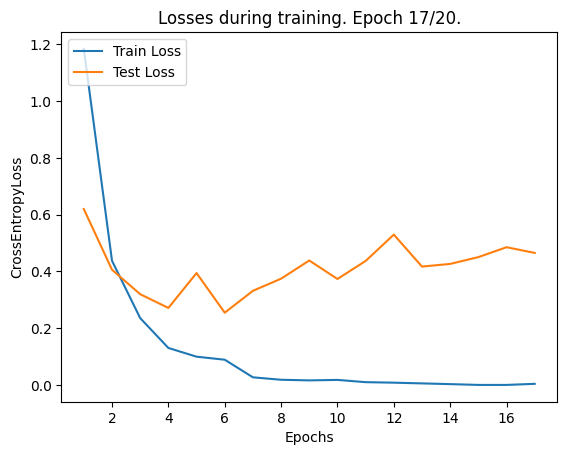

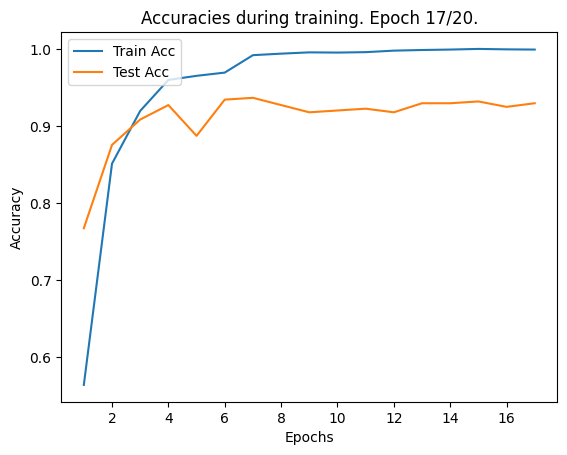

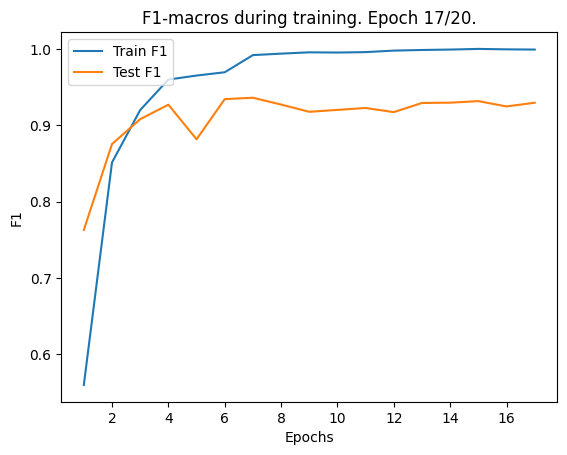

----------
Epoch Time: 0:22
Epoch 18/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it, Loss=0.002189, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.003412, acc: 0.999163, f05_macro: 0.999159, f1_macro: 0.999160
Confusion matrix:
[[446   0   0   0   0   0   0   0]
 [  0 454   0   0   0   0   0   0]
 [  0   0 448   1   0   0   0   0]
 [  0   0   0 446   0   0   0   1]
 [  0   0   1   0 447   0   0   0]
 [  0   0   0   0   0 454   0   0]
 [  0   0   0   0   0   0 446   0]
 [  0   0   0   0   0   0   0 440]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.469834, Corrects=155/170, Accuracy=91.176%]

Calculating metrics...
test loss: 0.424715, acc: 0.929577, f05_macro: 0.930056, f1_macro: 0.929554
Confusion matrix:
[[48  2  1  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 1  0 49  3  0  0  0  0]
 [ 0  0  7 46  0  0  0  1]
 [ 0  0  0  0 49  2  0  2]
 [ 1  0  0  0  3 49  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


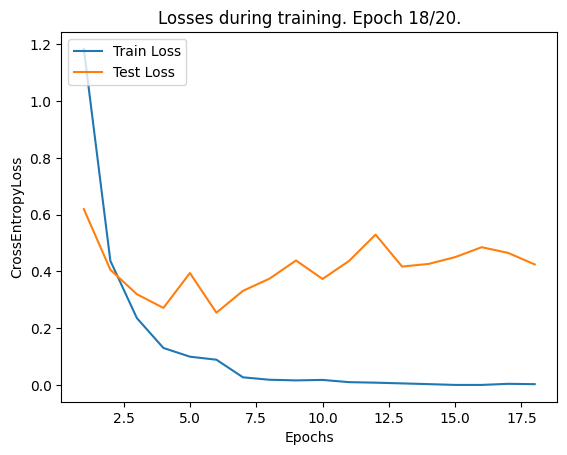

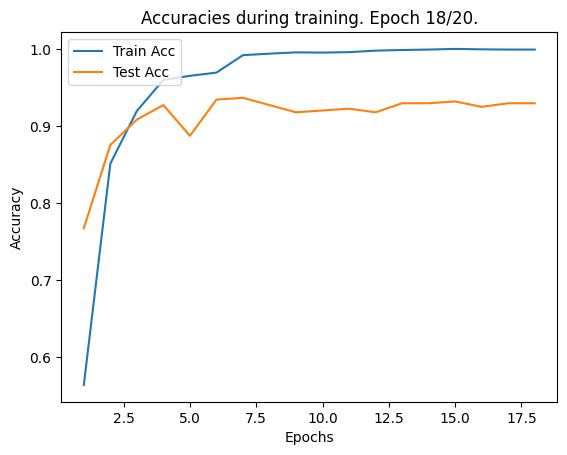

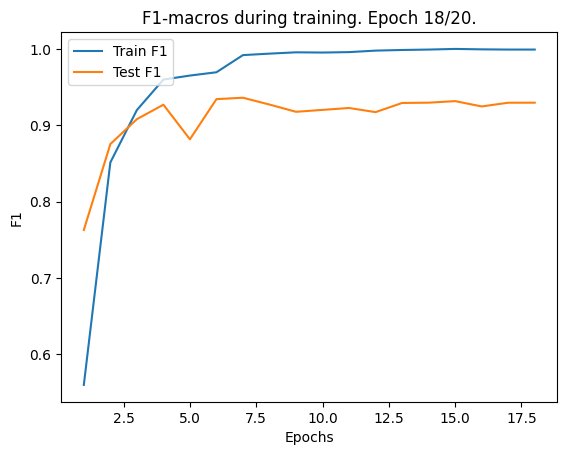

----------
Epoch Time: 0:22
Epoch 19/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.51s/it, Loss=0.001461, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.002107, acc: 0.999442, f05_macro: 0.999441, f1_macro: 0.999441
Confusion matrix:
[[446   0   0   0   0   0   0   0]
 [  0 450   0   1   0   0   0   0]
 [  0   0 448   0   0   0   0   0]
 [  0   1   0 443   0   0   0   0]
 [  0   0   0   0 447   0   0   0]
 [  0   0   0   0   0 458   0   0]
 [  0   0   0   0   0   0 442   0]
 [  0   0   0   0   0   0   0 448]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s, Loss=0.369238, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.423495, acc: 0.929577, f05_macro: 0.929178, f1_macro: 0.929238
Confusion matrix:
[[47  3  1  1  0  0  1  0]
 [ 4 49  0  0  0  0  0  0]
 [ 1  0 48  4  0  0  0  0]
 [ 0  2  4 46  1  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


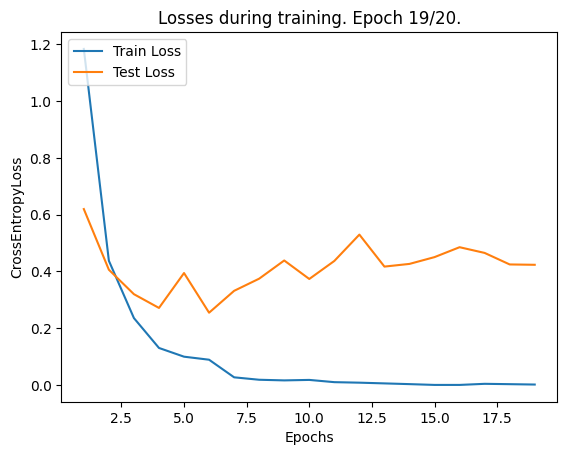

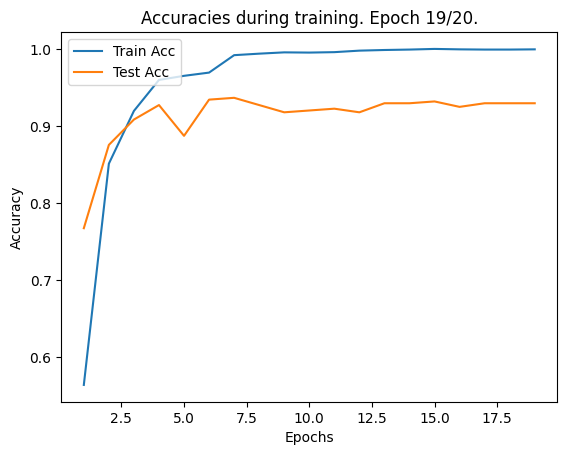

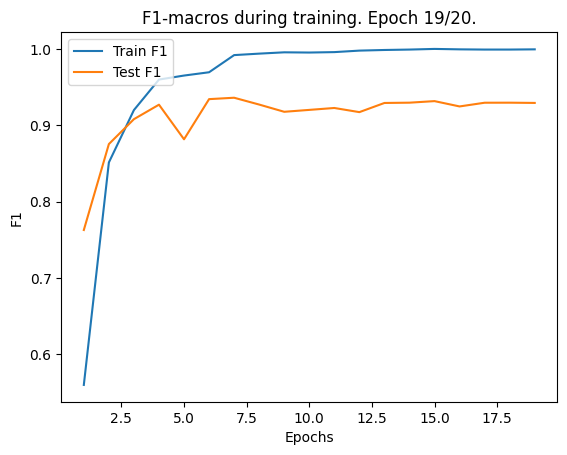

----------
Epoch Time: 0:22
Epoch 20/20
----------
--- Cur phase: train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:21<00:00,  1.52s/it, Loss=0.000093, Corrects=256/256, Accuracy=100.000%]


Calculating metrics...
train loss: 0.001517, acc: 0.999163, f05_macro: 0.999167, f1_macro: 0.999167
Confusion matrix:
[[450   0   0   0   0   0   0   0]
 [  1 449   0   0   0   0   0   0]
 [  0   0 452   0   1   0   0   0]
 [  0   0   0 444   0   0   0   0]
 [  0   0   1   0 446   0   0   0]
 [  0   0   0   0   0 446   0   0]
 [  0   0   0   0   0   0 443   0]
 [  0   0   0   0   0   0   0 451]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.434152, Corrects=157/170, Accuracy=92.353%]

Calculating metrics...
test loss: 0.444937, acc: 0.934272, f05_macro: 0.934225, f1_macro: 0.933739
Confusion matrix:
[[45  5  1  1  0  0  1  0]
 [ 1 52  0  0  0  0  0  0]
 [ 1  0 49  3  0  0  0  0]
 [ 0  0  5 47  1  0  0  1]
 [ 0  0  0  0 48  3  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]]


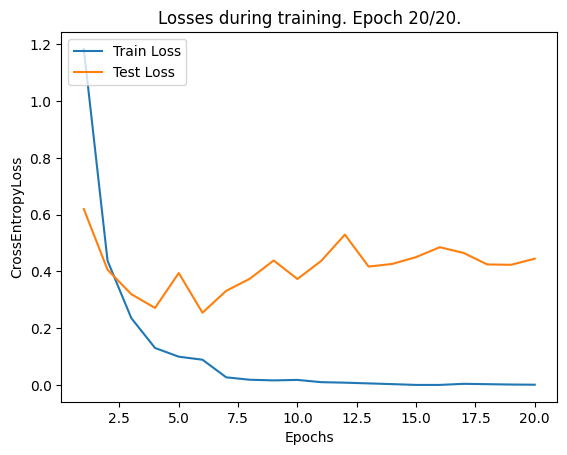

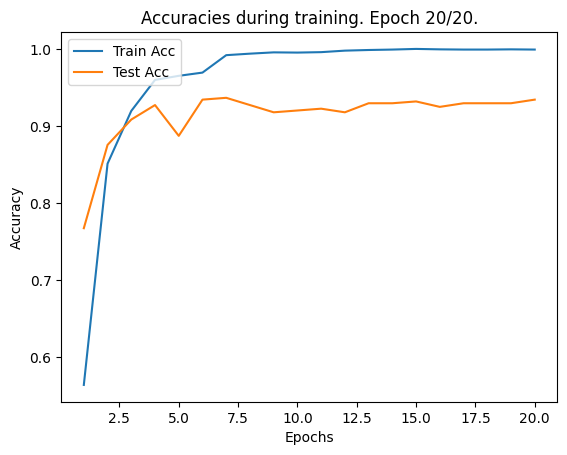

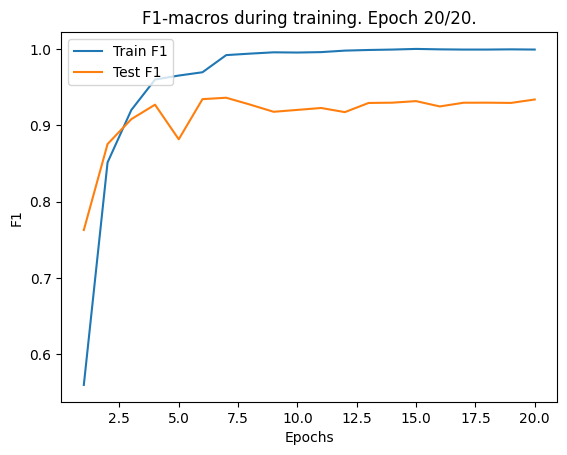

----------
Epoch Time: 0:22
*** Training Completed ***


In [28]:
from torch import optim

for name in list(net_models.keys()):
    model = net_models[name]

    learning_rate = 1e-4
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 20

    saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros = train_model(name, dataloaders, num_epochs)

    model_ckpt_path = f"{name}_trained.pth"
    torch.save(model.state_dict(), model_ckpt_path)

### Тестируем обученные модели

In [29]:
def load_random_image(image_dir):
    all_images = os.listdir(image_dir)
    random_image = random.choice(all_images)
    image_path = os.path.join(image_dir, random_image)
    image = Image.open(image_path)
    return image, random_image


def predict_cls(image, model):
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Добавляем дополнительную размерность для batch

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    return predicted_idx.item()

In [30]:
# Трансформации для тестового изображения
preprocess = T.Compose([
    T.Resize(224),  # Изменение размера изображения
    T.ToTensor(),  # Преобразование в тензор
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

In [31]:
def test_one_image(name, model):
    image_dir = './dataset/test'

    image, image_name = load_random_image(image_dir)

    plt.imshow(image)
    plt.title(f"Model: {name}, image: {image_name}")
    plt.axis('off')
    plt.show()

    model_ckpt_path = f"{name}_trained.pth"
    model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))
    predicted_class_idx = predict_cls(image, model)
    print(f'Predicted class: {classes[predicted_class_idx]}')

In [32]:
net_models = {}
net_models['resnet'] = get_resnet(num_classes=len(classes))
net_models['alexnet'] = get_alexnet(num_classes=len(classes))
net_models['vgg'] = get_vgg(num_classes=len(classes))

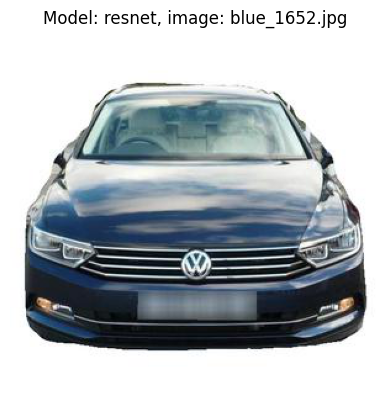

Predicted class: yellow


/tmp/ipykernel_12302/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


In [52]:
test_one_image('resnet', net_models['resnet'])

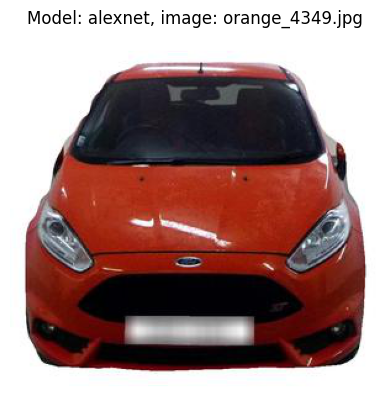

Predicted class: orange


/tmp/ipykernel_12302/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


In [69]:
test_one_image('alexnet', net_models['alexnet'])

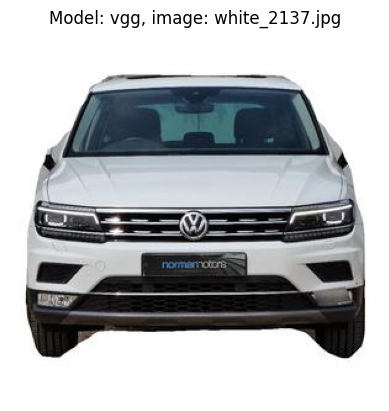

/tmp/ipykernel_12302/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


Predicted class: white


In [74]:
test_one_image('vgg', net_models['vgg'])

### Результаты

### Метрики

In [36]:
qualities = []
for name in list(net_models.keys()):
    quality_data = pd.DataFrame(
        columns=['Loss (Train)', 'Accuracy (Train)', 'F05_macro (Train)', 'F1_macro (Train)', 'Loss (Test)',
                 'Accuracy (Test)', 'F05_macro (Test)', 'F1_macro (Test)'], index=[name])

    epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = results[name]['train']
    quality_data['Loss (Train)'] = round(float(epoch_loss), 3)
    quality_data['Accuracy (Train)'] = round(float(epoch_acc), 3)
    quality_data['F05_macro (Train)'] = round(float(f05_macro), 3)
    quality_data['F1_macro (Train)'] = round(float(f1_macro), 3)

    epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = results[name]['test']
    quality_data['Loss (Test)'] = round(float(epoch_loss), 3)
    quality_data['Accuracy (Test)'] = round(float(epoch_acc), 3)
    quality_data['F05_macro (Test)'] = round(float(f05_macro), 3)
    quality_data['F1_macro (Test)'] = round(float(f1_macro), 3)

    qualities.append(quality_data)

models_report = pd.concat(qualities)
models_report

Loss (Train)  Accuracy (Train)  F05_macro (Train)  F1_macro (Train)  \
resnet          0.000             1.000              1.000             1.000   
alexnet         0.007             0.998              0.998             0.998   
vgg             0.002             0.999              0.999             0.999   

         Loss (Test)  Accuracy (Test)  F05_macro (Test)  F1_macro (Test)  
resnet         0.180            0.962             0.963            0.962  
alexnet        0.492            0.918             0.918            0.917  
vgg            0.445            0.934             0.934            0.934

### Графики

resnet


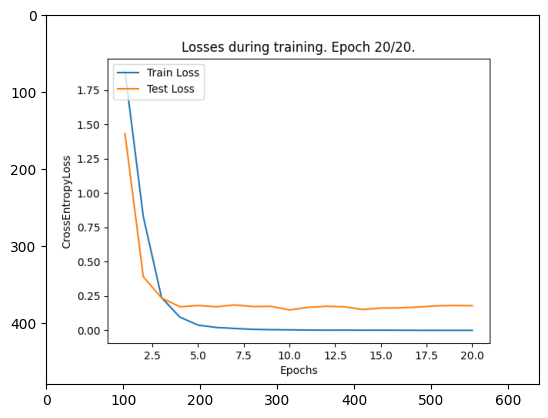

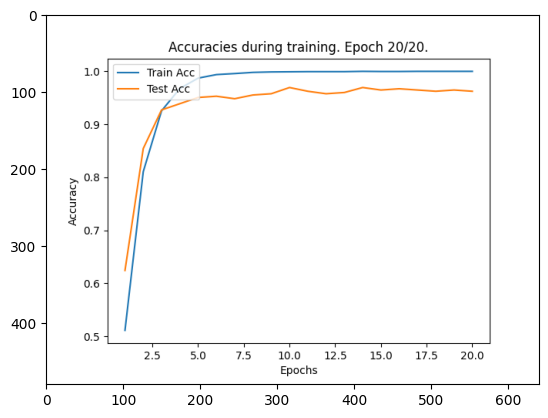

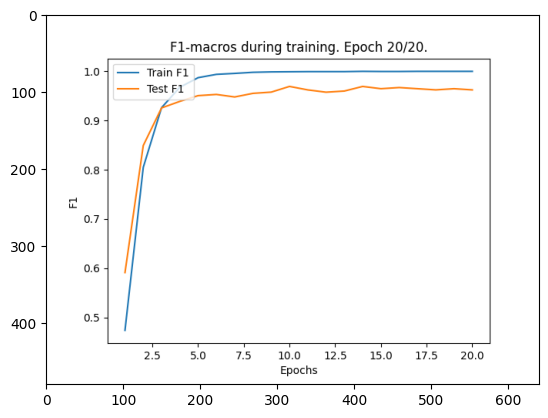

alexnet


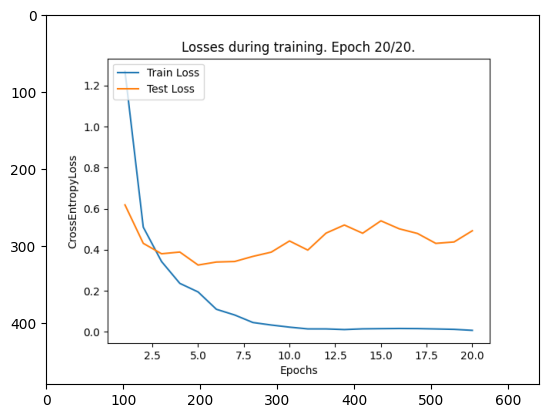

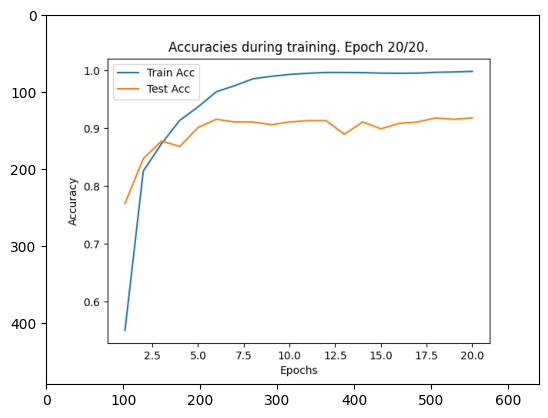

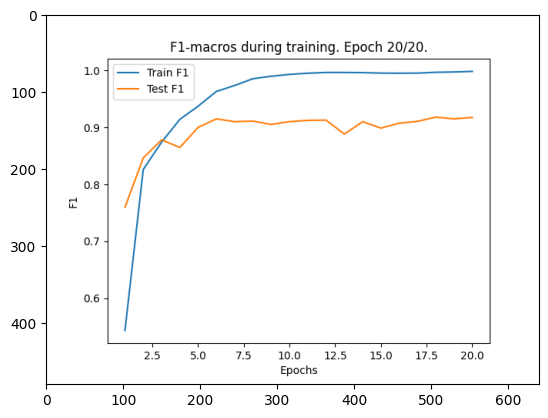

vgg


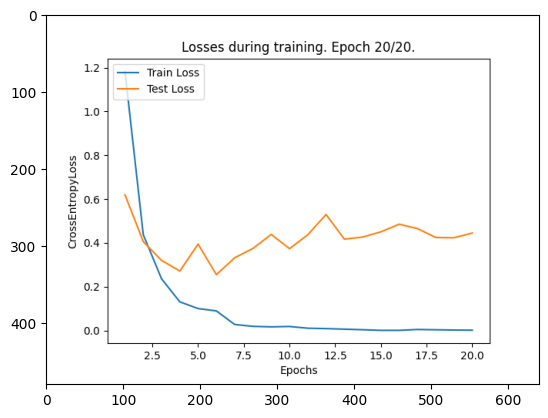

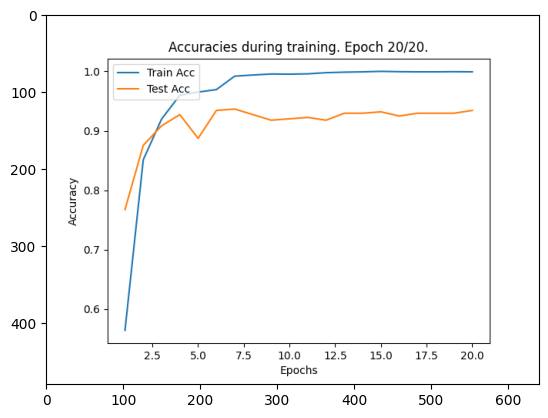

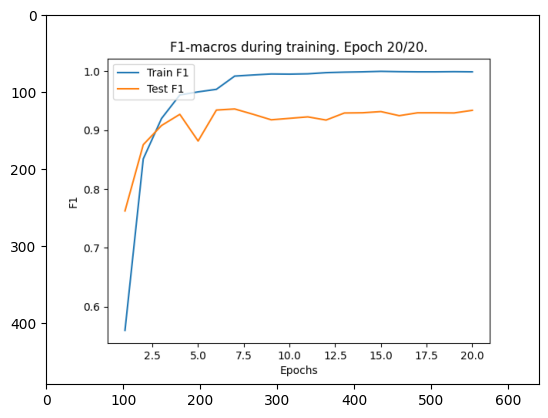

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for name in list(net_models.keys()):
    print(name)
    img = mpimg.imread(f'{log_folder}/loss_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()
    
    img = mpimg.imread(f'{log_folder}/acc_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()
    
    img = mpimg.imread(f'{log_folder}/f1_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()    

### Confusion Matrix

In [38]:
qualities = []

print(f"{classes}\n")

for name in list(net_models.keys()):
    _, _, _, _, conf_matrix_train = results[name]['train']
    _, _, _, _, conf_matrix_test = results[name]['test']

    print(f"{name} train: \n{conf_matrix_train} \n")
    print(f"{name} test: \n{conf_matrix_test} \n")

['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']

resnet train: 
[[450   0   0   0   0   0   0   0]
 [  0 447   0   0   0   0   0   0]
 [  0   0 438   0   0   0   0   0]
 [  0   0   0 455   0   0   0   0]
 [  0   0   0   0 453   0   0   0]
 [  0   0   0   0   0 446   0   0]
 [  0   0   0   0   0   0 449   0]
 [  0   0   0   0   0   0   0 446]] 

resnet test: 
[[49  2  0  1  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 0  0 52  1  0  0  0  0]
 [ 0  0  2 51  0  0  0  1]
 [ 0  0  0  0 49  3  0  1]
 [ 0  0  1  0  0 52  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  1  0  0  0  0 52]] 

alexnet train: 
[[447   2   1   0   0   0   0   0]
 [  2 448   0   0   0   0   0   0]
 [  0   0 451   0   0   0   0   0]
 [  0   0   0 437   0   0   0   0]
 [  0   0   0   0 453   0   0   0]
 [  0   0   0   0   0 445   0   0]
 [  0   0   0   0   0   0 445   0]
 [  0   0   0   0   1   0   0 452]] 

alexnet test: 
[[46  3  1  2  0  0  1  0]
 [ 2 51  0  0  0  0  0  0]
 [ 1  1 45  5  0  0  1  0]
 

### Выводы:

- обучение проводил на видеокарте nvidia rtx 3090
- попробовал различные предобученные сети, наилучших результатов по качеству обучения удалось достигнуть с:
    - ResNet50
    - AlexNet
    - VGG
- выбрал по 2м причинам: удобно использовать прямо из пакета torchvision и они лучше всего обучились
- попробовал различные гиперпараметры, наилучших результатов по качеству и скорости обучения удалось достигнуть с:
    - 20 эпох
    - размер батча 256
    - 16 воркеров
    - оптимизатор Адам
    - шаг обучения 1e-3
    - функция ошибки CrossEntropyLoss
- Лучший результат по Loss на тесте показала AlexNet (0.208)
- Лучший результат по Accuracy на тесте показала VGG (0.920)
- Лучший результат по F1 Macro на тесте показала AlexNet (0.920)